# CREDIT SCORING

### PROJECT

###  Цель:
Построить модель кредитного скоринга, которая будет предсказывать вероятность дефолта клиентов банка. Применить различные алгоритмы классификации.

### Структура:  
1. Импорт и вспомогательные функции  
2. Первичный осмотр данных   
3. Разведывательный анализ данных (EDA)  
   - Распределение признаков  
   - Преобразование переменных   
     (LabelEncoding, OneHotEncoding, логарифмирование)  
   - Корреляционный анализ
   - Анализ значимости переменных
4. Разделение выборки и нормализация данных
5. Обучение, валидация различных алгоритмов    
    - Логистическая регрессия  
    - Решающее дерево и бэггинг  
    - Случайный лес  
    - Градиентный бустинг  
    - **Cтекинг**  
    -**LightAutoMl**
6. Класс для быстрого проведения предобработки
7. Kaggle Submission   

# 1. Импорт и вспомогательные функции

In [ ]:
# !pip install -U pip
# !pip install -U lightautoml

In [1]:
import pandas as pd
import numpy as np 
from itertools import combinations
from tqdm import tqdm
import sys, joblib, json, logging  # imblearn
logging.basicConfig(format = '[%(asctime)s] (%(levelname)s): %(message)s', level = logging.INFO)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import lightautoml
from lightautoml.tasks import Task
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.report.report_deco import ReportDeco

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.base import clone
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, KFold, 
                                    StratifiedKFold, cross_val_score, cross_validate)  
from sklearn.metrics import (accuracy_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, 
                             precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc,
                             confusion_matrix, classification_report, precision_recall_curve,
                             ConfusionMatrixDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier,
                              ExtraTreesClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings                             # отключить некритичные предупреждения
warnings.filterwarnings("ignore")
plt.style.use('default')
pd.set_option('display.max_rows', 100)      # показывать больше строк
pd.set_option('display.max_columns', 50)    # показывать больше колонок
pd.set_option('display.max_colwidth', None) # показывать полный текст в ячейке вне зависимости от длины
plt.rcParams['figure.figsize'] = (5, 3) 

# Фиксируем параметры среды
RANDOM_SEED = 42
!pip freeze > requirements.txt


pd.options.display.float_format ='{:,.3f}'.format
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./kaggle/input'): # с точкой при запуске локально
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output 
                                                  # when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# conda install -c conda-forge imbalanced-learn

In [19]:
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

### Вспомогательные функции

In [3]:
def get_df_info(df, name):
    # Вывод основной информации о датасете
    print(f'\nДатасет {name}:')
    display(df.head())
    print(f'Размер датасета: {df.shape}\n')
    display(df.info())
    print(f'Количество пропущенных значений в {name}: \n{df.isna().sum()[df.isna().sum() > 0]}')
    print(f'\nКоличество уникальных значений в {name}: \n{df.nunique()}')
    print(f'\nСтатистическая информация по {name}:')
    display(df.describe())
    display(df.describe(include = 'object'))
    print()
    print('         ***  ~~~~~~~~ *** ~~~~~~~~ *** ~~~~~~~~ *** ')
    print()

In [4]:
def get_column_info(DF, col):
    # Вывод информации о колонке
    # DF - датафрейм, col - имя колонки 
    display(pd.DataFrame(DF[col].value_counts()))
    print('Количество уникальных значений:', DF[col].nunique())
    print('Количество пропущенных значений:', DF[col].isna().sum())
    DF.loc[:, [col]].info()

In [5]:
def get_data_type(df: pd.DataFrame, isprint = True):
    # Разделение признаков по количеству значений и типу данных в них
    bin_cols_list = []
    for col in df.columns:
        if len(df[col].value_counts()) == 2:
            if isprint:
                print('binary:', col )
            bin_cols_list.append(col)
    cat_cols_list = []
    for col in df.columns:
        if 2 < len(df[col].value_counts()) < 20:
            if isprint:
                print('categorial:', col )
            cat_cols_list.append(col)
    num_cols_list = []
    for col in df.columns:
        if col not in set(bin_cols_list) and col not in set(cat_cols_list):
            if isprint:
                print('numeric:', col )
            num_cols_list.append(col)
    return (bin_cols_list, cat_cols_list, num_cols_list)

In [6]:
def get_binary_and_categorial_plot(col):
    # Построение графика бинарного/категориального признака 
    print(f"График и таблица по признаку '{col}'")
    data.groupby([col])['default'].value_counts().plot(kind = 'bar', grid = True, color = 'gray')
    plt.show()
    df_group = data.groupby([col])['default'].value_counts(normalize = True)
    print(df_group)
    print()
    print('         ----------')
    print()  

In [7]:
def get_boxplot(DF, column, parameter):
    # Быстрое построение боксплотов
    fig, ax = plt.subplots(figsize = (8, 4))
    sns.boxplot(
                x = parameter,  y = column,
                data = DF.loc[DF.loc[:, column].isin(DF.loc[:, column].value_counts().index[:20])],
                ax = ax, flierprops = {"marker": "x"}, medianprops = {"color": "coral"}, showfliers = False, notch = True
                 )
    plt.xticks(rotation = 90)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [8]:
def get_corr_plot(corr, annot = False):
    # Быстрое построение графика корреляции
    mask = np.triu(np.ones_like(corr, dtype = np.bool))
    cmap = sns.diverging_palette(260, 30, s = 100, center = 'light',  as_cmap = True)
    plt.figure(figsize = (8, 8))
    sns.heatmap(corr, annot = annot, fmt = '.2f', mask = mask, cmap = cmap, vmax = 1, 
                vmin = -1, square = True, linewidths = .5, cbar_kws = {"shrink": .5})

In [9]:
def data_preprocessing(df, num_cols_list, bin_cols_list, cat_cols_list, target):
    ''' 
    Функция для подготовки датасета к обучению, созданию X и y
    '''
    X_num = RobustScaler().fit_transform(df[num_cols_list].values)                 # Подготовка числовых переменных
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols_list].values)  # Подготовка категориальных переменных
    label_encoder = LabelEncoder()   # Подготовка бинарных переменных
    df_ = pd.DataFrame()
    
    for col in bin_cols_list:        # Заполнение пропусков значением "UNKNOWN"
        if df[col].isna().sum() > 0:
            df[col].fillna('UNKNOWN')
    for col in cat_cols_list:
        if df[col].isna().sum() > 0:
            df[col].fillna('UNKNOWN')
    for col in num_cols_list:
        if df[col].isna().sum() > 0:
            df[col].fillna('UNKNOWN')
    
    for col in bin_cols_list:
        encoded_col = pd.Series(label_encoder.fit_transform(df[[col]]))
        df_ = pd.concat([df_, encoded_col], axis = 1)
    X_bin = df_.values  
    
    X = np.hstack([X_num, X_bin, X_cat])   # Соединение переменных в один массив, создание X и y 
    y = target.values
    return X, y

In [10]:
def ROC_curve_plot(y_valid, y_pred_prob, model):
    # Подсчет и отображение значения ROC кривой и значения площади под кривой AUC
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_prob)
    roc_auc = roc_auc_score(y_valid, y_pred_prob)

    plt.figure(figsize = (4, 4))
    plt.plot([0, 1], label = 'Baseline', linestyle = '--')
    plt.plot(fpr, tpr, label = 'Model')
    plt.title(f'{model}  ROC AUC = {roc_auc:.03}', fontsize = 10.5)
    plt.ylabel('True Positive Rate (TPR)', fontsize = 10)
    plt.xlabel('False Positive Rate (FPR)', fontsize = 10)
    plt.legend(loc = 'lower right')
    plt.show()

In [11]:
def get_best_threshold(y_true, y_pred_proba):
    # Нахождение примерного порога отсечения (threshold), при котором достигается приемлемое значение f1_score
    f1_scores_dict = {}
    for threshold in np.arange(0, 1, 0.00002):
        y_pred_th = np.where(y_pred_proba >= threshold, 1, 0)       
        score = f1_score(y_true, y_pred_th)
        f1_scores_dict[threshold] = score
    result = sorted(f1_scores_dict.items(), key = lambda x: x[1], reverse = True)[0]
    return f'threshold: {result[0]}, f1_score: {result[1]}'

In [12]:
def get_confusion_matrix(y_valid, y_pred):
    # Быстрое изображение матрицы ошибок
    cm = confusion_matrix(y_valid, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap = plt.cm.Blues)
    plt.show()

In [13]:
cv = KFold(n_splits = 10, shuffle = True)

def get_separate_meta_features(clf, X_train, X_test, y_train, cv):
    '''
    Функция для стекинга алгоритмов.
    Принимает на вход один классификатор и возвращает новые признаки на объектах, 
    которые не использовались во время обучения.
    '''
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype = np.float32)

    splits = cv.split(X_train,y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [14]:
def get_meta_features(classifiers, X_train, X_test, y_train, cv):
    '''
    Функция для стекинга алгоритмов. Принимает на вход несколько классификаторов в списке 
    и возвращает новые признаки; генерирует и возвращает матрицу с изначальным количеством объектов.  
    Для избежания переобучения применяется кросс-валидация.
    '''
    features_list = [
        get_separate_meta_features(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features_list
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features_list
    ])
    
    return stacked_features_train, stacked_features_test

In [15]:
def fit_and_get_metrics(clf, X_train, y_train, X_valid, y_valid, get_y_pred = False):
    # Обучение и подсчет метрик качества классификации
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    get_classification_metrics(y_valid, y_pred, y_pred_proba)
    if get_y_pred == True:
        return (y_pred)

In [16]:
def get_classification_metrics(y_valid, y_pred, y_pred_proba):
    # Подсчет основных метрик качества классификации
    accuracy = accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    print(f'Метрики качества классификации:\n - Accuracy: {accuracy:.4f}\n - Precision: {precision:.4f}\n - Recall: {recall:.4f}\n - F1_score: {f1:.4f}\n - Roc_auc_score: {roc_auc:.4f}')

# 2. Первичный осмотр данных

In [48]:
#data_train = pd.read_csv('/kaggle/input/sf-dst-scoring/main_task.csv')
#data_test= pd.read_csv('/kaggle/input/sf-dst-scoring/kaggle_task.csv')
#sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')

In [50]:
# Загрузим датасет и посмотрим на данные
data_train = pd.read_csv('train_credit_scoring.csv')
data_test = pd.read_csv('test_credit_scoring.csv')
sample_submission = pd.read_csv('sample_submission_credit_scoring.csv')

dataframes = {'data_train': data_train, 'data_test' : data_test, 'sample_submission' : sample_submission}
for name, df_ in dataframes.items():
    print(f'Размер {name}: {df_.shape}')

get_df_info(data_train, 'data_train')
get_df_info(data_test, 'data_test')

print(f'\nSample_submission:')
display(sample_submission.head())
sample_submission.info()
 
    
# ОБЪЕДИНЕНИЕ ДАТАСЕТОВ ТРЕЙН И ТЕСТ
data_train['sample'] = 1   # Помечаем где трейн
data_test['sample'] = 0    # Помечаем где тест
data_test['default'] = 0   # В тесте нет значения default, необходимо его предсказать, поэтому пока что заполняем нулями
data = data_test.append(data_train, sort = False).reset_index(drop = True) # Объединяем
data_original = data.copy()

# train (73799, 19)   test (36349, 18)   sample_submission: (36349, 2)

Размер data_train: (73799, 19)
Размер data_test: (36349, 18)
Размер sample_submission: (36349, 2)

Датасет data_train:


client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   
3      16222  23JAN2014       SCH   F   53   N        N                0   
4     101655  18APR2014       GRD   M   48   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0     -2.009                1             50             1   
1          0     -1.532                3             50             2   
2          0     -1.408                1             80             1   
3          0     -2.057                2             50             2   
4          1     -1.245                1             60             2   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0  
3             3   10000    1           3                N        0  
4             3   30000    1           4                Y        0

Размер датасета: (73799, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time

None

Количество пропущенных значений в data_train: 
education    307
dtype: int64

Количество уникальных значений в data_train: 
client_id           73799
app_date              120
education               5
sex                     2
age                    52
car                     2
car_type                2
decline_app_cnt        21
good_work               2
score_bki           69096
bki_request_cnt        38
region_rating           7
home_address            3
work_address            3
income                966
sna                     4
first_time              4
foreign_passport        2
default                 2
dtype: int64

Статистическая информация по data_train:


client_id        age  decline_app_cnt  good_work  score_bki  \
count  73,799.000 73,799.000       73,799.000 73,799.000 73,799.000   
mean   55,137.965     39.281            0.276      0.165     -1.905   
std    31,841.921     11.520            0.804      0.371      0.498   
min         1.000     21.000            0.000      0.000     -3.625   
25%    27,440.500     30.000            0.000      0.000     -2.260   
50%    55,274.000     37.000            0.000      0.000     -1.921   
75%    82,758.500     48.000            0.000      0.000     -1.570   
max   110,147.000     72.000           33.000      1.000      0.200   

       bki_request_cnt  region_rating  home_address  work_address  \
count       73,799.000     73,799.000    73,799.000    73,799.000   
mean             2.000         56.726         1.576         2.496   
std              2.252         13.056         0.528         0.690   
min              0.000         20.000         1.000         1.000   
25%              0.000         50.000         1.000         2.000   
50%              1.000         50.000         2.000         3.000   
75%              3.000         60.000         2.000         3.000   
max             53.000         80.000         3.000         3.000   

             income        sna  first_time    default  
count    73,799.000 73,799.000  73,799.000 73,799.000  
mean     41,099.775      1.733       2.765      0.127  
std      46,166.322      1.124       1.009      0.333  
min       1,000.000      1.000       1.000      0.000  
25%      20,000.000      1.000       2.000      0.000  
50%      30,000.000      1.000       3.000      0.000  
75%      48,000.000      2.000       4.000      0.000  
max   1,000,000.000      4.000       4.000      1.000

app_date education    sex    car car_type foreign_passport
count       73799     73492  73799  73799    73799            73799
unique        120         5      2      2        2                2
top     18MAR2014       SCH      F      N        N                N
freq         1018     38860  41562  49832    59791            62733


         ***  ~~~~~~~~ *** ~~~~~~~~ *** ~~~~~~~~ *** 


Датасет data_test:


client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   
3      26883  03FEB2014       SCH   M   56   N        N                0   
4      28862  04FEB2014       GRD   F   38   N        N                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0     -2.272                3             50             1   
1          0     -1.505                2             50             1   
2          0     -1.691                1             50             1   
3          0     -2.374                1             40             1   
4          0     -2.488                0             80             2   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y  
3             2   17000    1           3                N  
4             3  120000    1           3                N

Размер датасета: (36349, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time

None

Количество пропущенных значений в data_test: 
education    171
dtype: int64

Количество уникальных значений в data_test: 
client_id           36349
app_date              120
education               5
sex                     2
age                    51
car                     2
car_type                2
decline_app_cnt        19
good_work               2
score_bki           34287
bki_request_cnt        34
region_rating           7
home_address            3
work_address            3
income                685
sna                     4
first_time              4
foreign_passport        2
dtype: int64

Статистическая информация по data_test:


client_id        age  decline_app_cnt  good_work  score_bki  \
count  36,349.000 36,349.000       36,349.000 36,349.000 36,349.000   
mean   54,945.647     39.186            0.268      0.167     -1.904   
std    31,706.052     11.513            0.788      0.373      0.502   
min         4.000     21.000            0.000      0.000     -3.574   
25%    27,744.000     30.000            0.000      0.000     -2.262   
50%    54,657.000     37.000            0.000      0.000     -1.921   
75%    82,322.000     48.000            0.000      0.000     -1.564   
max   110,148.000     71.000           30.000      1.000      0.189   

       bki_request_cnt  region_rating  home_address  work_address  \
count       36,349.000     36,349.000    36,349.000    36,349.000   
mean             2.014         56.803         1.574         2.501   
std              2.297         13.087         0.527         0.683   
min              0.000         20.000         1.000         1.000   
25%              0.000         50.000         1.000         2.000   
50%              1.000         50.000         2.000         3.000   
75%              3.000         60.000         2.000         3.000   
max             47.000         80.000         3.000         3.000   

             income        sna  first_time  
count    36,349.000 36,349.000  36,349.000  
mean     40,835.756      1.728       2.766  
std      43,802.181      1.121       1.012  
min       1,000.000      1.000       1.000  
25%      20,000.000      1.000       2.000  
50%      30,000.000      1.000       3.000  
75%      48,000.000      2.000       4.000  
max   1,000,000.000      4.000       4.000

app_date education    sex    car car_type foreign_passport
count       36349     36178  36349  36349    36349            36349
unique        120         5      2      2        2                2
top     18MAR2014       SCH      F      N        N                N
freq          473     19138  20274  24458    29349            30988


         ***  ~~~~~~~~ *** ~~~~~~~~ *** ~~~~~~~~ *** 


Sample_submission:


client_id  default
0      74835        0
1      17527        0
2      75683        0
3      26883        0
4      28862        0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


**В датасете представлены следующие данные:**
- **client_id** - идентификатор клиента  
- **app_date** - дата подачи заявления
- **education** - уровень образования  
- **sex** -	пол заёмщика (M - man, W - woman)
- **age** - возраст заёмщика  
- **car** -	флаг наличия автомобиля (Y - yes, N - no)  
- **car_type** - флаг автомобиля-иномарки (Y - yes, N - no) 
- **decline_app_cnt** -	количество отказанных прошлых заявок  
- **good_work** - флаг наличия «хорошей» работы (1 - имеется, 0 - нет)  
- **score_bki** - скоринговый балл по данным из БКИ (Бюро кредитных историй)
- **bki_request_cnt** -	количество запросов в БКИ  
- **home_address** - категоризатор домашнего адреса  
- **work_address** - категоризатор рабочего адреса  
- **income** - доход заёмщика  
- **sna** - связь заемщика с клиентами банка  
- **first_time** - давность наличия информации о заемщике
- **foreign_passport** - наличие загранпаспорта (Y - yes, N - no) 
- **default** -(target) наличие дефолта (1 -совершившие дефлт; 0 -без дефолта)

In [51]:
# Посмотрим на объединенный датасет
display(data)
print(f'Размер объединенного датасета: {data.shape}\n')
display(data.info())
print(f'Уникальные значения в датасете: \n{data.nunique(dropna = False)}')
print(f'\nПропущенные значения в датасете: \n{data.isna().sum()[data.isna().sum() > 0]}')

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0           74835  22MAR2014       GRD   M   29   Y        Y                0   
1           17527  24JAN2014       SCH   F   39   N        N                5   
2           75683  23MAR2014       UGR   M   50   Y        Y                0   
3           26883  03FEB2014       SCH   M   56   N        N                0   
4           28862  04FEB2014       GRD   F   38   N        N                0   
...           ...        ...       ...  ..  ...  ..      ...              ...   
110143      54887  04MAR2014       GRD   F   45   N        N                0   
110144      76821  24MAR2014       SCH   M   41   Y        Y                0   
110145     103695  22APR2014       SCH   M   31   N        N                0   
110146        861  04JAN2014       SCH   F   29   N        N                0   
110147      15796  23JAN2014       GRD   M   34   N        N                0   

        good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0               0     -2.272                3             50             1   
1               0     -1.505                2             50             1   
2               0     -1.691                1             50             1   
3               0     -2.374                1             40             1   
4               0     -2.488                0             80             2   
...           ...        ...              ...            ...           ...   
110143          0     -1.792                3             50             1   
110144          0     -2.058                1             50             2   
110145          0     -1.513                4             80             2   
110146          1     -1.479                3             50             1   
110147          0     -1.765                2             50             2   

        work_address  income  sna  first_time foreign_passport  sample  \
0                  2   50000    1           4                N       0   
1                  2    5000    4           3                N       0   
2                  2   30000    1           3                Y       0   
3                  2   17000    1           3                N       0   
4                  3  120000    1           3                N       0   
...              ...     ...  ...         ...              ...     ...   
110143             2   17000    4           4                N       1   
110144             2   70000    1           4                N       1   
110145             3   45000    2           2                N       1   
110146             3   13000    2           3                N       1   
110147             3   25000    1           3                N       1   

        default  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
110143        0  
110144        0  
110145        0  
110146        1  
110147        0  

[110148 rows x 20 columns]

Размер объединенного датасета: (110148, 20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               11014

None

Уникальные значения в датасете: 
client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

Пропущенные значения в датасете: 
education    478
dtype: int64


- В данных о клиентах присутствуют переменные всех типов, не все признаки имеют числовой формат.   
- Пропуски встречаются только в информации об образовании клиентов. Значит, необходима предварительная очистка данных.  

# 3. Разведывательный анализ данных (EDA)  
 
###  Распределение признаков 

<AxesSubplot:>

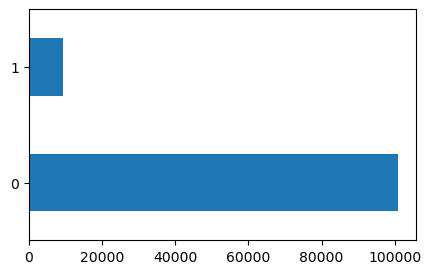

In [52]:
# Построим диаграмму для целевой переменной "default", чтобы определить, каких клиентов у банка больше
data.default.value_counts().plot.barh()

- Целевая пеерменная несбалансирована. Клиентов, которые не совершили дефолт, гораздо больше. 
- На это необходимо обратить внимание при обучении модели, т.к. есть риск переобучиться на наиболее популярный класс.

In [53]:
# Сгруппируем признаки по категориям (бинарные, категориальные и числовые переменные)
bin_cols_list, cat_cols_list, num_cols_list = get_data_type(data, isprint = False)
bin_cols_list.remove('default')
bin_cols_list.remove('sample')
print('num_cols_list: ', num_cols_list)
print('bin_cols_list: ', bin_cols_list)
print('cat_cols_list: ', cat_cols_list)


num_cols_list:  ['client_id', 'app_date', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
bin_cols_list:  ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols_list:  ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']


#### Посмотрим детальнее столбцы "client_id" и "app_date"

Столбец "client_id". Уникальных значений: 110148


client_id
0      74835
1      17527
2      75683

Столбец "app_date". Уникальных значений: 120


app_date
0  22MAR2014
1  24JAN2014
2  23MAR2014

app_date
0 2014-03-22
1 2014-01-24
2 2014-03-23

Год(а) подачи заявок на кредит и количество заявок: 
2014    110148
Name: app_date, dtype: int64

num_cols_list ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


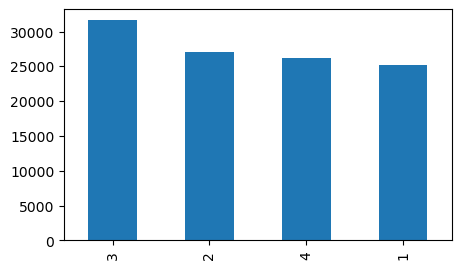

In [54]:
# Столбец "client_id"
print(f'Столбец "client_id". Уникальных значений: {data["client_id"].nunique()}')
display(data[['client_id']].head(3))

# Столбец "app_date"
print(f'Столбец "app_date". Уникальных значений: {data["app_date"].nunique()}')
display(data[['app_date']].head(3))

# Приведем столбец "app_date" к формату datetime
data['app_date'] = pd.to_datetime(data['app_date'], format = '%d%b%Y')
display(data[['app_date']].head(3))

# Посмотрим за какие года и месяцы представлены данные
print(f'Год(а) подачи заявок на кредит и количество заявок: \n{data["app_date"].dt.year.value_counts()}\n')
data['app_date'].dt.month.value_counts().plot.bar()   # Все заявки подавались в пределах 4-х месяцев

# Удалим столбцы "client_id" и "app_date" из датасета и списка числовых переменных 
data.drop(['client_id', 'app_date'], axis = 1, inplace = True)  
num_cols_list.remove('client_id')
num_cols_list.remove('app_date')
print(f'num_cols_list {num_cols_list}')

- Все заявки на кредит подавались в пределах четырех месяцев в 2014 году.   
- Если включить признак "app_date" в модель, то будет проблематично делать предсказания на новых данных, поэтому решено удалить эту переменную. Также удален столбец "client_id", поскольку он не несет важной информации.

### Анализ бинарных и категориальных переменных

In [55]:
print(f'Список бинарных переменных: {bin_cols_list}')
print(f'Список категориальных переменных: {cat_cols_list}')

Список бинарных переменных: ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
Список категориальных переменных: ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']


education
SCH      57998
GRD      34768
UGR      14748
PGR       1865
ACD        291

Количество уникальных значений: 5
Количество пропущенных значений: 478
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 1 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   education  109670 non-null  object
dtypes: object(1)
memory usage: 860.7+ KB


<AxesSubplot:xlabel='education', ylabel='count'>

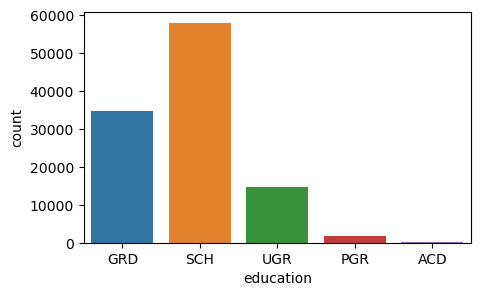

In [56]:
# Посмотрим на признак 'education' и как он влияет на целевую переменную
get_column_info(data, 'education')
sns.countplot(x = data['education'])

default education  not_defaulted  defaulted
0             ACD          0.973      0.027
1             GRD          0.939      0.061
2             PGR          0.957      0.043
3             SCH          0.899      0.101
4             UGR          0.912      0.088

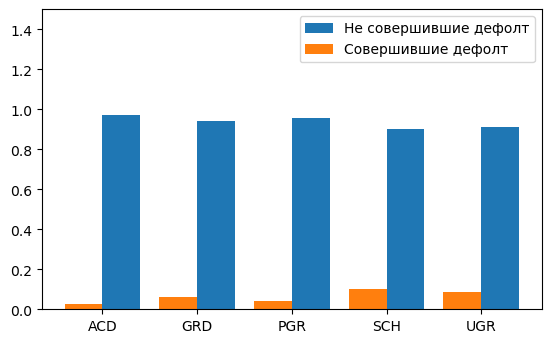

In [57]:
# Посмотрим на соотношение клиентов банка, которые совершили и не совершили дефолт
default_probability = data.groupby('education').default.value_counts(normalize = True).to_frame() \
            .rename(columns = {'default': 'probability'}).reset_index() \
            .pivot_table(index = 'education', columns = 'default', values = 'probability') \
            .reset_index().rename(columns = {0 : 'not_defaulted', 1 : 'defaulted'})
display(default_probability)

fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0, 1.5)
axes.bar(x = default_probability['education'], height = default_probability['not_defaulted'], width = 0.4, align = 'edge', label = 'Не совершившие дефолт')
axes.bar(x = default_probability['education'], height = default_probability['defaulted'], width = -0.4, align = 'edge', label = 'Совершившие дефолт')
axes.legend(loc = 1)

- Влияние признака "education" на целевую переменную неравнозначно.  
- С дефолтом чаще всего сталкиваются клиенты банка с образованием **SCH (10%) и UGR (8%)** 

In [58]:
# Трансформируем признак "education" с помощью дамми-переменных и удалим его из списка категориальных переменных
data = pd.get_dummies(data, columns = ['education'], dummy_na = True)
cat_cols_list.remove('education')

График и таблица по признаку 'sex'


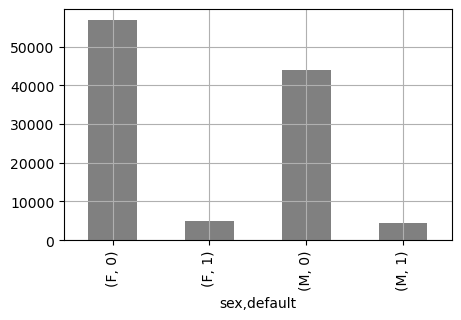

sex  default
F    0         0.919
     1         0.081
M    0         0.910
     1         0.090
Name: default, dtype: float64

         ----------

График и таблица по признаку 'car'


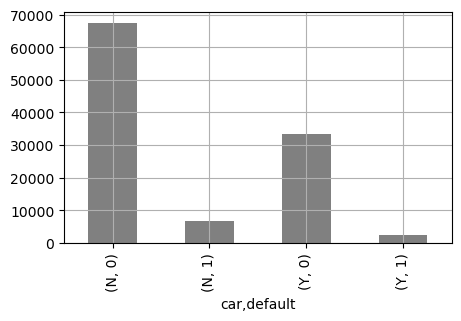

car  default
N    0         0.908
     1         0.092
Y    0         0.929
     1         0.071
Name: default, dtype: float64

         ----------

График и таблица по признаку 'car_type'


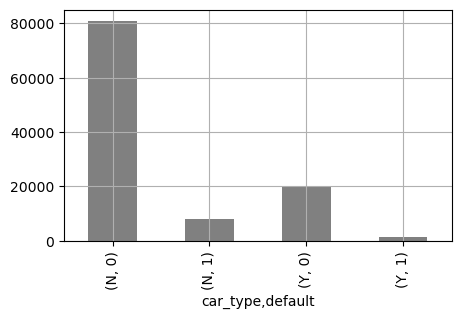

car_type  default
N         0         0.909
          1         0.091
Y         0         0.942
          1         0.058
Name: default, dtype: float64

         ----------

График и таблица по признаку 'good_work'


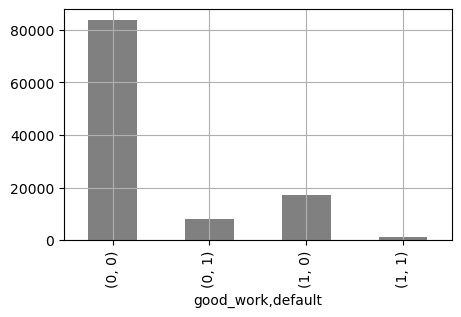

good_work  default
0          0         0.911
           1         0.089
1          0         0.937
           1         0.063
Name: default, dtype: float64

         ----------

График и таблица по признаку 'foreign_passport'


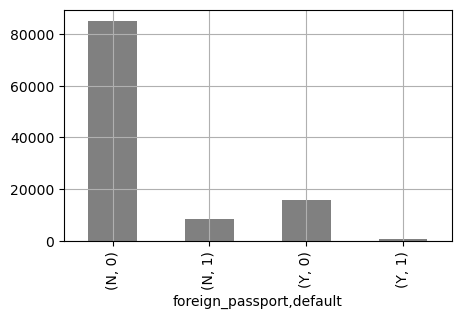

foreign_passport  default
N                 0         0.909
                  1         0.091
Y                 0         0.950
                  1         0.050
Name: default, dtype: float64

         ----------

График и таблица по признаку 'region_rating'


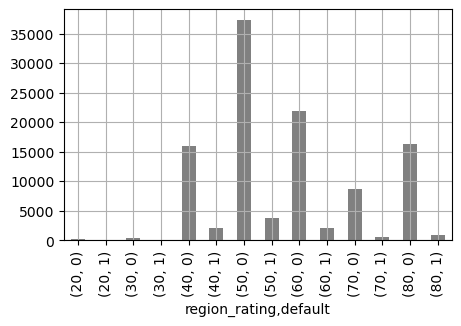

region_rating  default
20             0         0.859
               1         0.141
30             0         0.869
               1         0.131
40             0         0.886
               1         0.114
50             0         0.909
               1         0.091
60             0         0.914
               1         0.086
70             0         0.938
               1         0.062
80             0         0.951
               1         0.049
Name: default, dtype: float64

         ----------

График и таблица по признаку 'home_address'


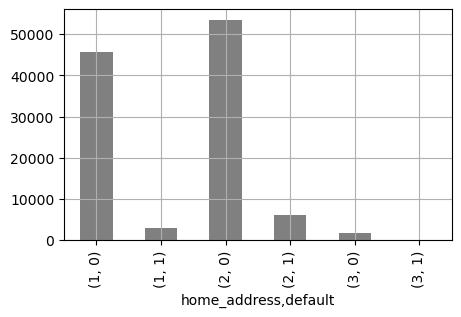

home_address  default
1             0         0.938
              1         0.062
2             0         0.896
              1         0.104
3             0         0.922
              1         0.078
Name: default, dtype: float64

         ----------

График и таблица по признаку 'work_address'


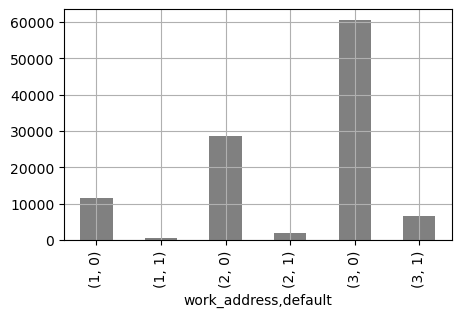

work_address  default
1             0         0.950
              1         0.050
2             0         0.932
              1         0.068
3             0         0.901
              1         0.099
Name: default, dtype: float64

         ----------

График и таблица по признаку 'sna'


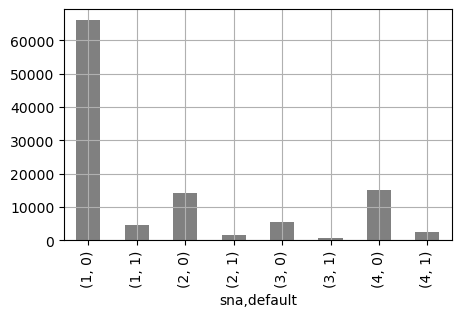

sna  default
1    0         0.934
     1         0.066
2    0         0.899
     1         0.101
3    0         0.894
     1         0.106
4    0         0.858
     1         0.142
Name: default, dtype: float64

         ----------

График и таблица по признаку 'first_time'


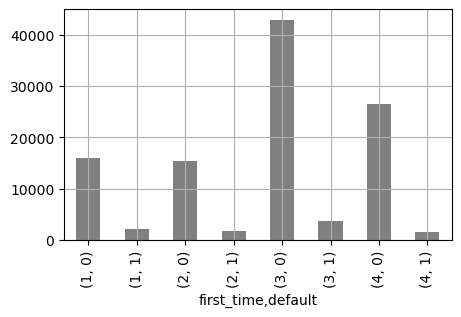

first_time  default
1           0         0.875
            1         0.125
2           0         0.896
            1         0.104
3           0         0.919
            1         0.081
4           0         0.945
            1         0.055
Name: default, dtype: float64

         ----------



In [59]:
# Посмотрим взаимосвязь бинарных и категориальных признаков с целевой переменной 
for col in bin_cols_list + cat_cols_list:
    get_binary_and_categorial_plot(col)

- Судя по графикам, наличие автомобиля (иномарки), хорошей работы и заграничного паспорта снижает вероятность дефолта.  

### Трансформация бинарных признаков

In [60]:
Label_encoder = LabelEncoder()
for col in bin_cols_list:
    data[col] = Label_encoder.fit_transform(data[col])
display(data[bin_cols_list].head())

sex  car  car_type  good_work  foreign_passport
0    1    1         1          0                 0
1    0    0         0          0                 0
2    1    1         1          0                 1
3    1    0         0          0                 0
4    0    0         0          0                 0

### Анализ числовых переменных

In [62]:
print(f'Список числовых переменных: {num_cols_list}')

Список числовых переменных: ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']


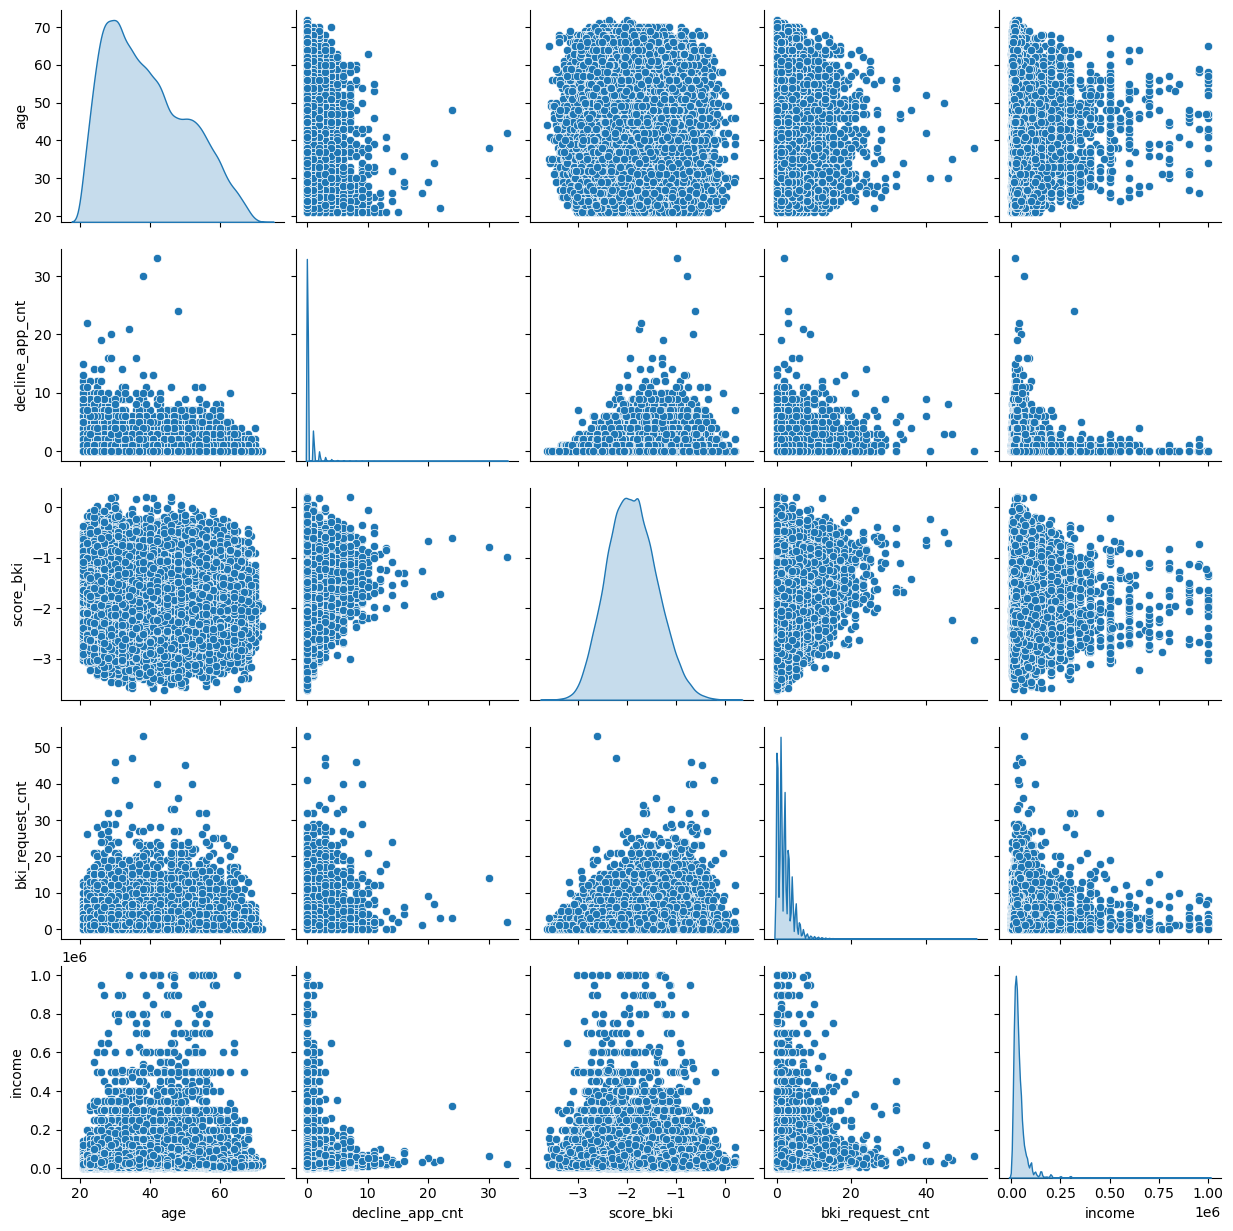

In [31]:
# Посмотрим на распределение числовых переменных
sns.pairplot(data[num_cols_list], diag_kind = 'kde')

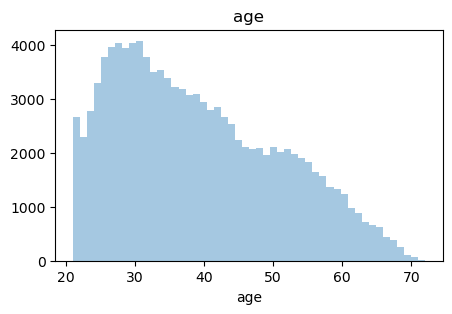

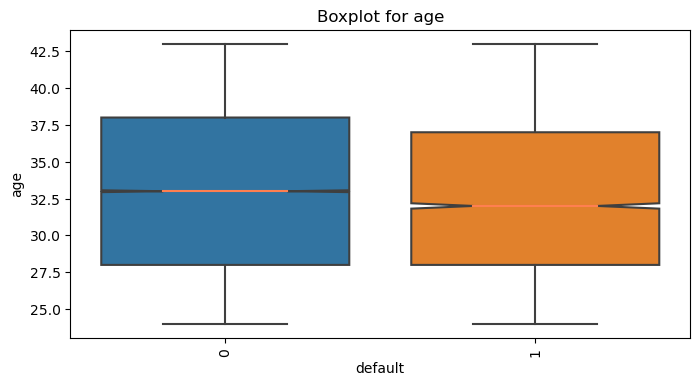

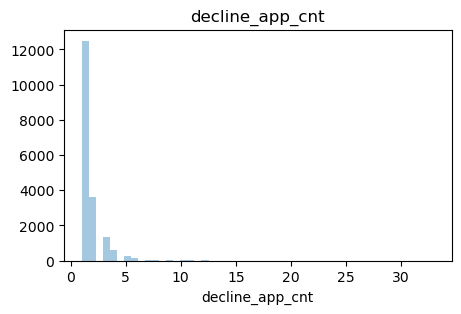

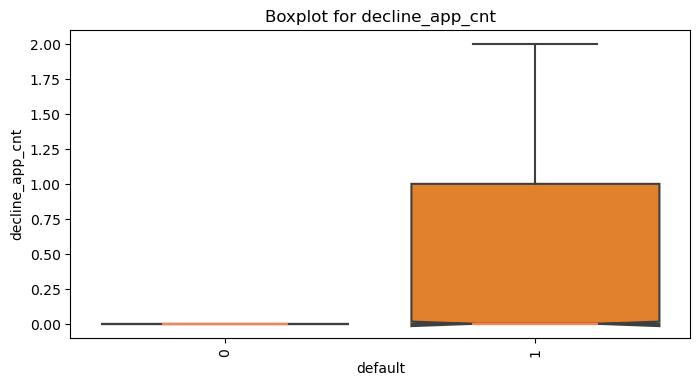

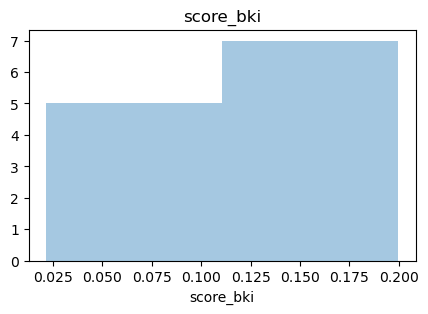

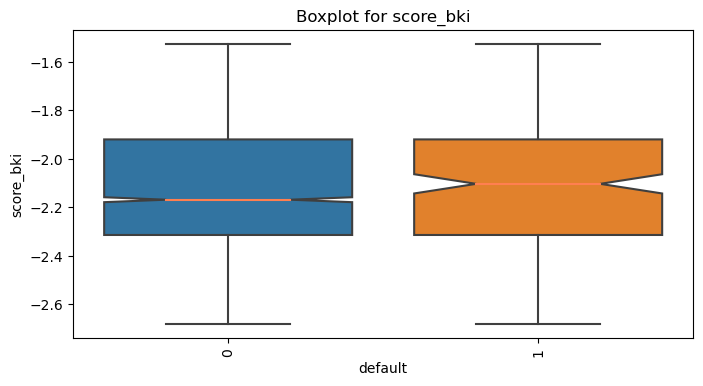

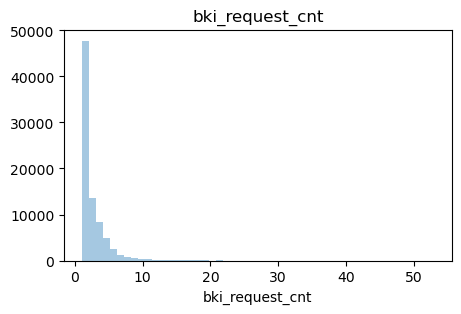

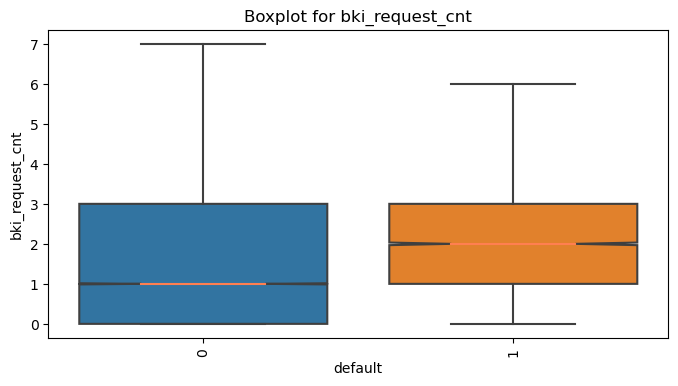

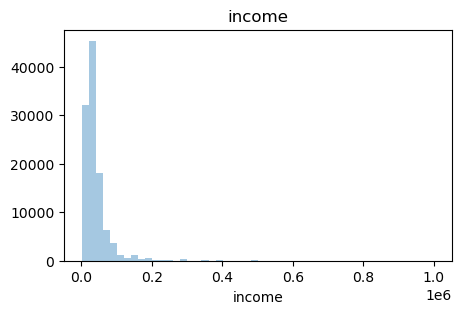

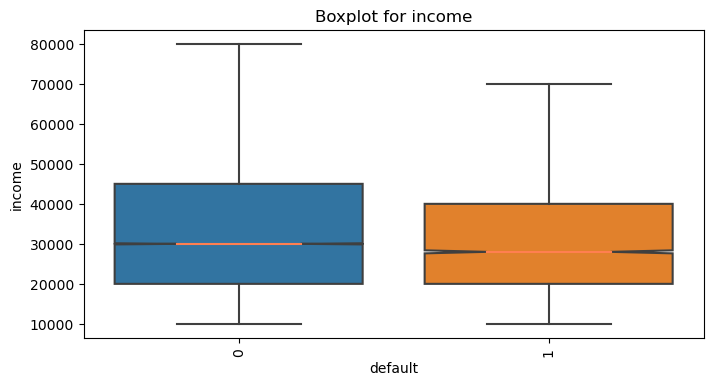

In [32]:
# Посмотрим зависимость числовых переменных с целевой  
for col in num_cols_list:
    plt.figure()
    sns.distplot(data[col][data[col] > 0].dropna(), kde = False, rug = False)
    plt.title(col)
    plt.show()
    
    get_boxplot(data, col, 'default')

In [63]:
# Посмотрим детальнее на признак "income"
data.income.describe()

count     110,148.000
mean       41,012.649
std        45,399.735
min         1,000.000
25%        20,000.000
50%        30,000.000
75%        48,000.000
max     1,000,000.000
Name: income, dtype: float64

In [64]:
# Посмотрим на процентрное соотношение количества отказанных прошлых заявок клиентов
data.decline_app_cnt.value_counts(normalize = True)

0    0.830
1    0.113
2    0.033
3    0.012
4    0.006
5    0.002
6    0.001
7    0.001
8    0.000
9    0.000
10   0.000
11   0.000
12   0.000
13   0.000
14   0.000
16   0.000
21   0.000
30   0.000
20   0.000
19   0.000
22   0.000
33   0.000
15   0.000
24   0.000
Name: decline_app_cnt, dtype: float64

**Приведенные графики позволяют сделать выводы:**
- В основном заявки удовлетворяются с первой попытки - 83%, один отказ получают 11% человек, два отказа - 3%.   
- Статистические данные признака "income" показывают довольно большой разброс, средняя и медианная зарплата клиентов банка не совпадают, наблюдается высокое стандартное отклонение, есть экстремально высокие значения заработной платы. Большинство людей имеет доход от 20 до 48 тыс. Наблюдается заметный разброс между доходами людей.
- Рапределение всех числовых переменных имеет удлиненный правый хвост. Например, распределение признака "возраст" смещено влево - чаще всего за кредитами обращаются люди в возрасте +-30 лет.    
- Дефолтные клиенты в среднем младше, дефолтные клиенты в среднем имеют большое количество отмененных заявок, больше запросов в БКИ и более низкий доход.

### Логарифмирование числовых признаков  (кроме 'score_bki',  т.к. признак знакопеременный)

In [65]:
for col in num_cols_list:
    if col != 'score_bki':
        data[col] = np.log(data[col] + 1)

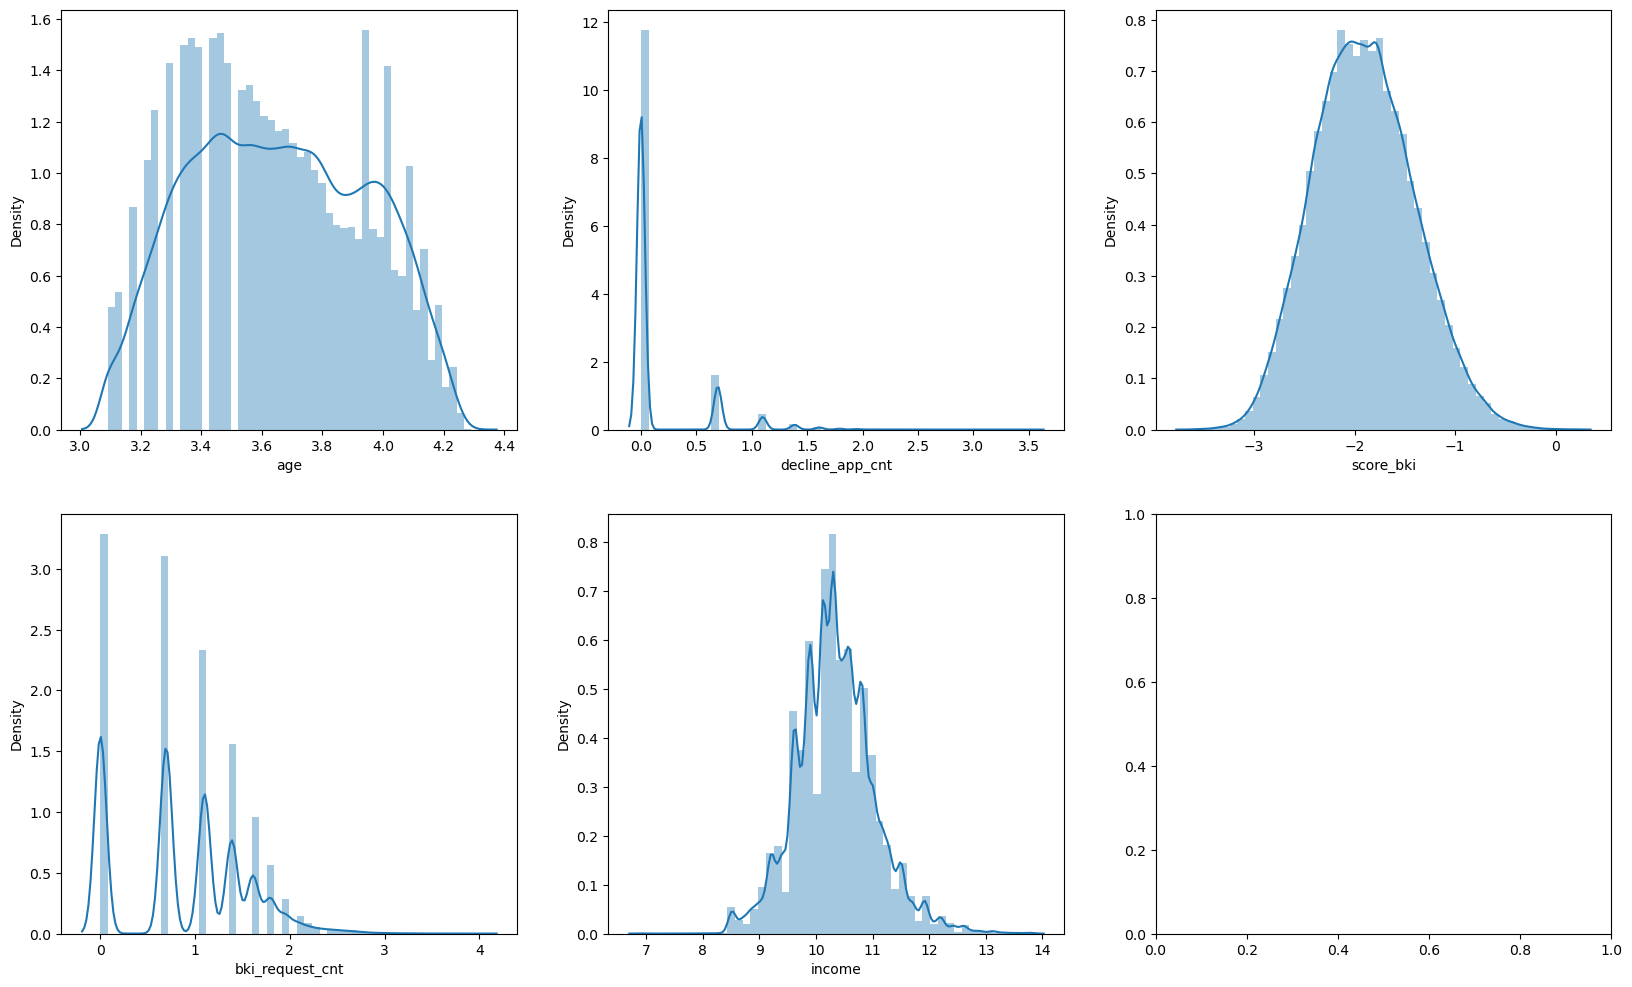

In [66]:
# Посмотрим распределение числовых признаков после логарифмирования
fig, axes = plt.subplots(2, 3, figsize = (20, 12))
for col, i in zip(num_cols_list, range(5)):
    sns.distplot(data[col], ax = axes.flat[i])

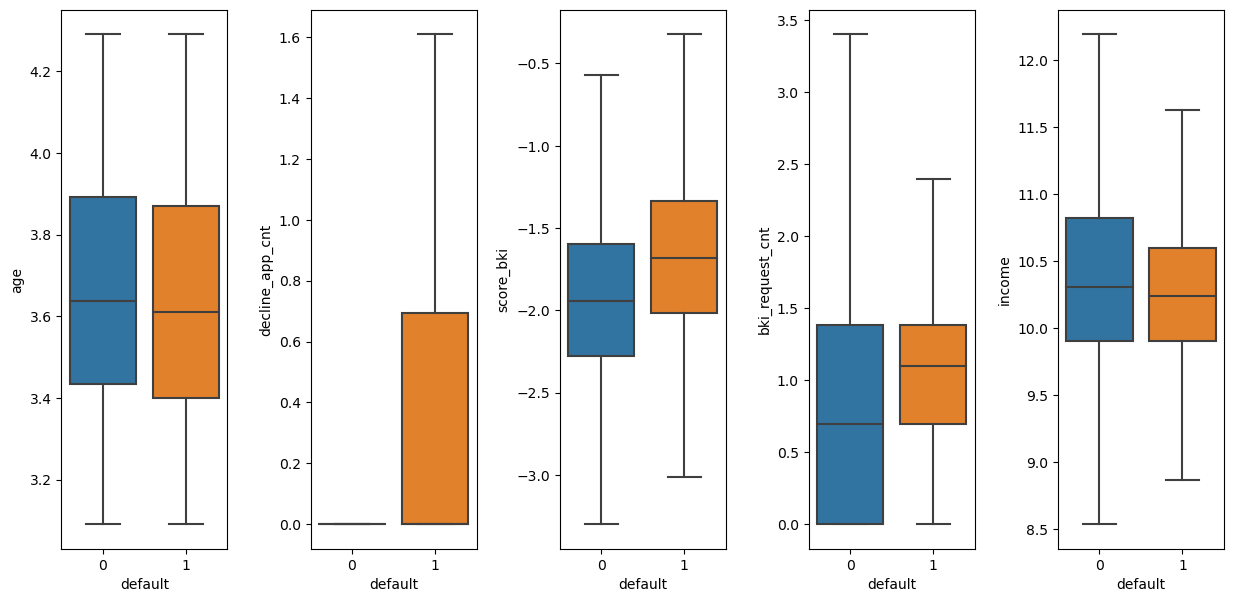

In [67]:
fig, axes = plt.subplots(1,5, figsize = (15, 7))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()

for col in range(len(num_cols_list)):
    sns.boxplot(x = 'default', y = num_cols_list[col], data = data, orient = 'v', ax = axes[col], showfliers = False)

- Распределение признака "income" стало более нормальным.  
- Признак "age" изменился несильно.  
- У признаков "decline_app_cnt", "bki_request_cnt" сохраняется "тяжелый" хвост справа.

### Корреляционный анализ

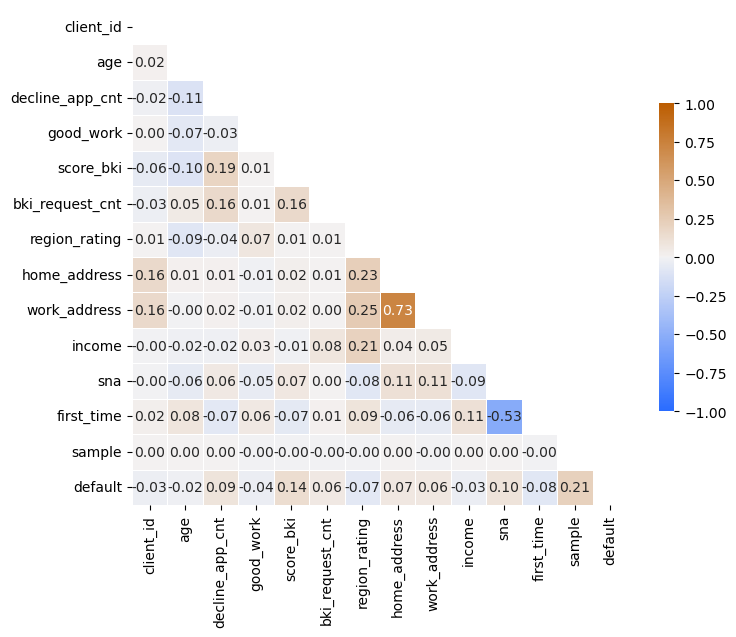

In [68]:
# Посмотрим график корреляции всех признаков изначального датасета
corr_1 = data_original.corr()
get_corr_plot(corr_1, annot = True)

In [69]:
print(f'Корреляция признаков с целевой переменной "default": \n{corr_1.default.abs().sort_values(ascending = False)}')

Корреляция признаков с целевой переменной "default": 
default           1.000
sample            0.214
score_bki         0.140
sna               0.101
decline_app_cnt   0.092
first_time        0.084
region_rating     0.072
home_address      0.068
work_address      0.065
bki_request_cnt   0.062
good_work         0.035
income            0.032
client_id         0.031
age               0.019
Name: default, dtype: float64


<AxesSubplot:>

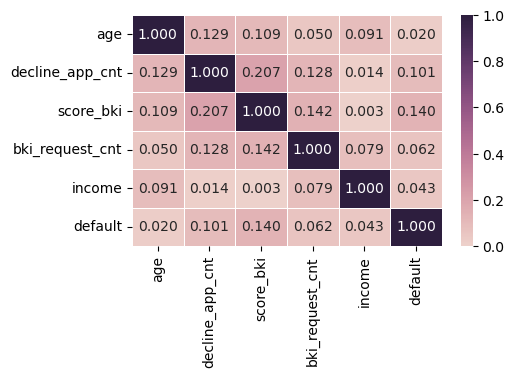

In [70]:
# Корреляция числовых переменных
corr_2 = data[num_cols_list + ['default']].corr()
sns.heatmap(corr_2.abs(), annot = True, vmin = 0, vmax = 1, 
            cmap = sns.cubehelix_palette(as_cmap = True), linewidth = .5, fmt = ".3f")

- Сильно скоррелированных пар признаков не наблюдается, кроме корреляции между домашним и рабочем адресами, что вполне логично.   
- Корреляция признаков с целевой переменной также довольно слабая.  

In [71]:
data.head(3)

sex   age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1 3.401    1         1            0.000          0     -2.272   
1    0 3.689    0         0            1.792          0     -1.505   
2    1 3.932    1         1            0.000          0     -1.691   

   bki_request_cnt  region_rating  home_address  work_address  income  sna  \
0            1.386             50             1             2  10.820    1   
1            1.099             50             1             2   8.517    4   
2            0.693             50             1             2  10.309    1   

   first_time  foreign_passport  sample  default  education_ACD  \
0           4                 0       0        0              0   
1           3                 0       0        0              0   
2           3                 1       0        0              0   

   education_GRD  education_PGR  education_SCH  education_UGR  education_nan  
0              1              0              0              0              0  
1              0              0              1              0              0  
2              0              0              0              1              0

### Анализ значимости переменных  

**Оценим значимость числовых переменных с помощью функции f_classif.**  
Данный метод оценки значимости переменных опирается на однофакторный дисперсионный анализ (ANOVA). Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t).

<AxesSubplot:>

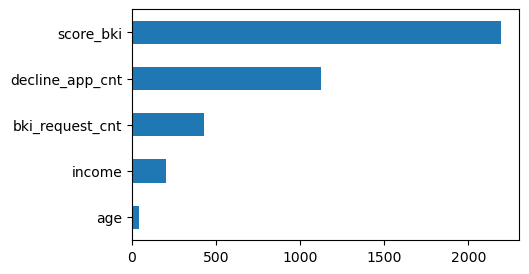

In [72]:
importance_num = pd.Series(f_classif(data[num_cols_list], data['default'])[0], index = num_cols_list)
importance_num.sort_values(inplace = True)
importance_num.plot(kind = 'barh')

**Оценим значимость категориальных и бинарных переменных с помощью функции mutual_info_classif.**  
Данный метод опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

<AxesSubplot:>

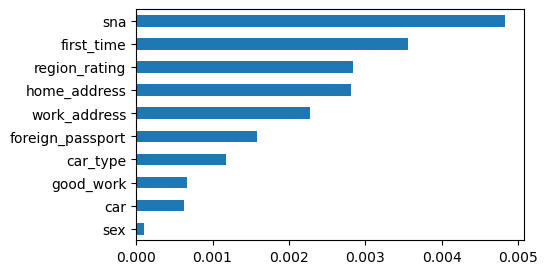

In [73]:
importance_cat = pd.Series(mutual_info_classif(data[bin_cols_list + cat_cols_list], data['default'],
                                     discrete_features = True), index = bin_cols_list + cat_cols_list)
importance_cat.sort_values(inplace = True)
importance_cat.plot(kind = 'barh')

### Трансформация категориальных переменных 

In [74]:
# Сгенерируем дамми-переменные
data = pd.get_dummies(data, columns = cat_cols_list)
data.head()

sex   age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1 3.401    1         1            0.000          0     -2.272   
1    0 3.689    0         0            1.792          0     -1.505   
2    1 3.932    1         1            0.000          0     -1.691   
3    1 4.043    0         0            0.000          0     -2.374   
4    0 3.664    0         0            0.000          0     -2.488   

   bki_request_cnt  income  foreign_passport  sample  default  education_ACD  \
0            1.386  10.820                 0       0        0              0   
1            1.099   8.517                 0       0        0              0   
2            0.693  10.309                 1       0        0              0   
3            0.693   9.741                 0       0        0              0   
4            0.000  11.695                 0       0        0              0   

   education_GRD  education_PGR  education_SCH  education_UGR  education_nan  \
0              1              0              0              0              0   
1              0              0              1              0              0   
2              0              0              0              1              0   
3              0              0              1              0              0   
4              1              0              0              0              0   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 1   
3                 0                 0                 1                 0   
4                 0                 0                 0                 0   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 0               1   
1                 0                 0                 0               1   
2                 0                 0                 0               1   
3                 0                 0                 0               1   
4                 0                 0                 1               0   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               1   
4               1               0               0               0   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               0      1      0      0      0             0             0   
1               0      0      0      0      1             0             0   
2               0      1      0      0      0             0             0   
3               0      1      0      0      0             0             0   
4               1      1      0      0      0             0             0   

   first_time_3  first_time_4  
0             0             1  
1             1             0  
2             1             0  
3             1             0  
4             1             0

In [75]:
# Сохраним подготовленный датасет
data.to_pickle("prepared_dataset_credit_scoring.pickle")

In [17]:
data = pd.read_pickle("prepared_dataset_credit_scoring.pickle")
print(data.shape)  # (110148, 39)
data.head()

(110148, 39)


sex   age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1 3.401    1         1            0.000          0     -2.272   
1    0 3.689    0         0            1.792          0     -1.505   
2    1 3.932    1         1            0.000          0     -1.691   
3    1 4.043    0         0            0.000          0     -2.374   
4    0 3.664    0         0            0.000          0     -2.488   

   bki_request_cnt  income  foreign_passport  sample  default  education_ACD  \
0            1.386  10.820                 0       0        0              0   
1            1.099   8.517                 0       0        0              0   
2            0.693  10.309                 1       0        0              0   
3            0.693   9.741                 0       0        0              0   
4            0.000  11.695                 0       0        0              0   

   education_GRD  education_PGR  education_SCH  education_UGR  education_nan  \
0              1              0              0              0              0   
1              0              0              1              0              0   
2              0              0              0              1              0   
3              0              0              1              0              0   
4              1              0              0              0              0   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 1   
3                 0                 0                 1                 0   
4                 0                 0                 0                 0   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 0               1   
1                 0                 0                 0               1   
2                 0                 0                 0               1   
3                 0                 0                 0               1   
4                 0                 0                 1               0   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               1   
4               1               0               0               0   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               0      1      0      0      0             0             0   
1               0      0      0      0      1             0             0   
2               0      1      0      0      0             0             0   
3               0      1      0      0      0             0             0   
4               1      1      0      0      0             0             0   

   first_time_3  first_time_4  
0             0             1  
1             1             0  
2             1             0  
3             1             0  
4             1             0

In [19]:
print(num_cols_list)
print(cat_cols_list)
print(bin_cols_list)

['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
['region_rating', 'home_address', 'work_address', 'sna', 'first_time']
['sex', 'car', 'car_type', 'good_work', 'foreign_passport']


In [18]:
# num_cols_list = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
# cat_cols_list = ['region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# bin_cols_list = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# 4. Разделение выборки и нормализация данных

- Разделим объединенный датасет на обучающую и тестовую выборки (sample == 1, sample == 0).
- Выделим X и y.
- Проведем Oversampling (при помощи RandomOverSampler) и Undersampling (при помощи RandomUnderSampler)
- Нормализуем данные при помощи класса RobustScaler.
- Посмотрим на результат работы различных алгоритмов на исходной и сбалансированной выборках.

In [20]:
# Выделим тренировочную и тестовую часть 
train_data = data.query('sample == 1').drop('sample', axis = 1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis = 1)  

display(train_data.head())
display(test_data.head())
print(f'Размер train_data: {train_data.shape}\nРазмер test_data: {test_data.shape}') # train (73799, 38)   test (36349, 37)

sex   age  car  car_type  decline_app_cnt  good_work  score_bki  \
36349    1 4.143    1         1            0.000          0     -2.009   
36350    0 4.094    0         0            0.000          0     -1.532   
36351    1 3.258    1         0            1.099          0     -1.408   
36352    0 3.989    0         0            0.000          0     -2.057   
36353    1 3.892    0         0            0.000          1     -1.245   

       bki_request_cnt  income  foreign_passport  default  education_ACD  \
36349            0.693   9.798                 0        0              0   
36350            1.386   9.852                 0        0              0   
36351            0.693  10.309                 1        0              0   
36352            1.099   9.210                 0        0              0   
36353            0.693  10.309                 1        0              0   

       education_GRD  education_PGR  education_SCH  education_UGR  \
36349              0              0              1              0   
36350              0              0              1              0   
36351              0              0              1              0   
36352              0              0              1              0   
36353              1              0              0              0   

       education_nan  region_rating_20  region_rating_30  region_rating_40  \
36349              0                 0                 0                 0   
36350              0                 0                 0                 0   
36351              0                 0                 0                 0   
36352              0                 0                 0                 0   
36353              0                 0                 0                 0   

       region_rating_50  region_rating_60  region_rating_70  region_rating_80  \
36349                 1                 0                 0                 0   
36350                 1                 0                 0                 0   
36351                 0                 0                 0                 1   
36352                 1                 0                 0                 0   
36353                 0                 1                 0                 0   

       home_address_1  home_address_2  home_address_3  work_address_1  \
36349               1               0               0               0   
36350               0               1               0               0   
36351               1               0               0               0   
36352               0               1               0               0   
36353               0               1               0               0   

       work_address_2  work_address_3  sna_1  sna_2  sna_3  sna_4  \
36349               1               0      0      0      0      1   
36350               0               1      0      0      0      1   
36351               1               0      1      0      0      0   
36352               0               1      1      0      0      0   
36353               0               1      1      0      0      0   

       first_time_1  first_time_2  first_time_3  first_time_4  
36349             1             0             0             0  
36350             1             0             0             0  
36351             0             0             0             1  
36352             0             0             1             0  
36353             0             0             0             1

sex   age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1 3.401    1         1            0.000          0     -2.272   
1    0 3.689    0         0            1.792          0     -1.505   
2    1 3.932    1         1            0.000          0     -1.691   
3    1 4.043    0         0            0.000          0     -2.374   
4    0 3.664    0         0            0.000          0     -2.488   

   bki_request_cnt  income  foreign_passport  education_ACD  education_GRD  \
0            1.386  10.820                 0              0              1   
1            1.099   8.517                 0              0              0   
2            0.693  10.309                 1              0              0   
3            0.693   9.741                 0              0              0   
4            0.000  11.695                 0              0              1   

   education_PGR  education_SCH  education_UGR  education_nan  \
0              0              0              0              0   
1              0              1              0              0   
2              0              0              1              0   
3              0              1              0              0   
4              0              0              0              0   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 1   
3                 0                 0                 1                 0   
4                 0                 0                 0                 0   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 0               1   
1                 0                 0                 0               1   
2                 0                 0                 0               1   
3                 0                 0                 0               1   
4                 0                 0                 1               0   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               0               0               0               1   
1               0               0               0               1   
2               0               0               0               1   
3               0               0               0               1   
4               1               0               0               0   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               0      1      0      0      0             0             0   
1               0      0      0      0      1             0             0   
2               0      1      0      0      0             0             0   
3               0      1      0      0      0             0             0   
4               1      1      0      0      0             0             0   

   first_time_3  first_time_4  
0             0             1  
1             1             0  
2             1             0  
3             1             0  
4             1             0

Размер train_data: (73799, 38)
Размер test_data: (36349, 37)


Размер исходных несбалансированных выборок 
Х: (73799, 37) 
y: (73799,)

Соотношение классов: 
0    64427
1     9372
Name: default, dtype: int64


<AxesSubplot:xlabel='default', ylabel='count'>

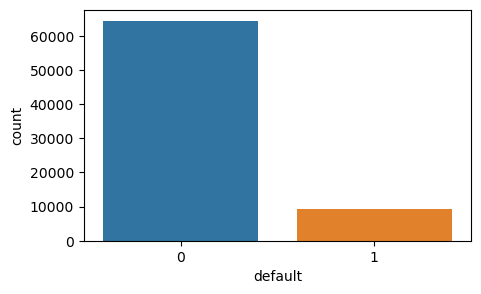

In [21]:
# Разобьем обучающую выборку на X и y
X = train_data.drop('default', axis = 1)
y = train_data.default.values   
print(f'Размер исходных несбалансированных выборок \nХ: {X.shape} \ny: {y.shape}')  # Х: (73799, 37)   y: (73799,)

# Проиллюстрируем дисбаланс классов в тренировочных данных
print(f'\nСоотношение классов: \n{train_data.default.value_counts()}')  # 64427 - 9372
sns.countplot(x = train_data.default)  

In [22]:
round(train_data.default.value_counts()[1] / train_data.default.value_counts()[0], 5)  # 0.14547

0.14547

In [23]:
# Разобьем данные на трениовочную и валидационную выборки. Сохраним пропорцию классов при разбиении - применим стратификацию
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = RANDOM_SEED)
print(f'Размер выборок:\nX_train: {X_train.shape}, y_train: {y_train.shape} \nX_valid: {X_valid.shape}, y_valid: {y_valid.shape}')

Размер выборок:
X_train: (59039, 37), y_train: (59039,) 
X_valid: (14760, 37), y_valid: (14760,)


In [81]:
## Undersampling механическим способом: 

# X_train['default'] = y_train
# X_train_1 = pd.concat([X_train[X_train.default == 0].iloc[:X_train["default"].value_counts()[1]], \
#                       X_train[X_train.default == 1]], ignore_index=True, axis=0)

# Разделим сбалансированные данные на X и y
# y_train_1 = X_train_1.default.values   
# X_train_1 = X_train_1.drop('default', axis=1)
# X_train = X_train.drop('default', axis=1)
# print(f'\nРазмер выборок после механического Undersampling: X_train_1: {X_train_1.shape}, y_train_1: {y_train_1.shape}')
# print(f'\nСоотношение классов: \n{pd.Series(y_train_1).value_counts()}') # 7498   (14996, 37)

### Oversampling (при помощи RandomOverSampler)

In [24]:
print(f'Пропорция классов в тренировочном датасете: {np.unique(y_train, return_counts = True)[1] / y_train.shape[0]}')
# [0.8729992 0.1270008]

random_oversampling = imblearn.over_sampling.RandomOverSampler(sampling_strategy = 0.8, random_state = RANDOM_SEED) 
X_train_1, y_train_1 = random_oversampling.fit_resample(X_train, y_train)
X_valid_1, y_valid_1 = X_valid.copy(), y_valid.copy()
print(f'Размер выборок после RandomOverSampler: X_train_1: {X_train_1.shape}, y_train_1: {y_train_1.shape}') # (92773, 37)
print(f'\nСоотношение классов: \n{pd.Series(y_train_1).value_counts()}')   # 51541 - 41232

Пропорция классов в тренировочном датасете: [0.8729992 0.1270008]
Размер выборок после RandomOverSampler: X_train_1: (92773, 37), y_train_1: (92773,)

Соотношение классов: 
0    51541
1    41232
dtype: int64


### Undersampling (при помощи RandomUnderSampler)

In [25]:
random_undersampling = imblearn.under_sampling.RandomUnderSampler(sampling_strategy = 1, random_state = RANDOM_SEED)
X_train_2, y_train_2 = random_undersampling.fit_resample(X_train, y_train)
X_valid_2, y_valid_2 = X_valid.copy(), y_valid.copy()
print(f'Размер выборок после RandomUnderSampler: X_train_2: {X_train_2.shape}, y_train_2: {y_train_2.shape}') # (14996, 37)
print(f'\nСоотношение классов: \n{pd.Series(y_train_2).value_counts()}')  # 7498

Размер выборок после RandomUnderSampler: X_train_2: (14996, 37), y_train_2: (14996,)

Соотношение классов: 
0    7498
1    7498
dtype: int64


In [26]:
# Нормализуем числовые переменные при помощи RobustScaler
scaler = RobustScaler()     # Исходные несбалансированные данные
X_train[num_cols_list] = scaler.fit_transform(X_train[num_cols_list].values)
X_valid[num_cols_list] = scaler.transform(X_valid[num_cols_list].values)

scaler_1 = RobustScaler()   # Данные после RandomOverSampler
X_train_1[num_cols_list] = scaler_1.fit_transform(X_train_1[num_cols_list].values)
X_valid_1[num_cols_list] = scaler_1.transform(X_valid_1[num_cols_list].values)

scaler_2 = RobustScaler()   # Данные после RandomUnderSampler
X_train_2[num_cols_list] = scaler_2.fit_transform(X_train_2[num_cols_list].values)
X_valid_2[num_cols_list] = scaler_2.transform(X_valid_2[num_cols_list].values)

In [27]:
print(f'Размеры train выборок: \nX_train: {X_train.shape}, y_train: {y_train.shape} \nX_train_1: {X_train_1.shape}, y_train_1: {y_train_1.shape}, \nX_train_2: {X_train_2.shape}, y_train_2: {y_train_2.shape}')
print(f'\nРазмеры valid выборок: \nX_valid: {X_valid.shape}, y_valid: {y_valid.shape} \nX_valid_1: {X_valid_1.shape} \nX_valid_2: {X_valid_2.shape}')

Размеры train выборок: 
X_train: (59039, 37), y_train: (59039,) 
X_train_1: (92773, 37), y_train_1: (92773,), 
X_train_2: (14996, 37), y_train_2: (14996,)

Размеры valid выборок: 
X_valid: (14760, 37), y_valid: (14760,) 
X_valid_1: (14760, 37) 
X_valid_2: (14760, 37)


# 5. Обучение, валидация различных алгоритмов

**Посмотрим на результат работы алгоритмов:**   
- Логистическая регрессия   
- Решающее дерево и бэггинг  
- Случайный лес  
- Градиентный бустинг  
- **Стекинг**  
- **LightAutoML**

**Применим их к выборкам:**  
1) Изначальной тренировочной выборке  
2) Сбалансированной выборке при помощи RandomUnderSampler  
3) Сбалансированной выборке при помощи RandomOverSampler

## Логистическая регрессия из sklearn  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">Документация LogisticRegression</a>

### 1) Логистическая регрессия на изначальной несбалансированной тренировочной выборке

In [280]:
# Запустим наивную модель логистической регрессии со стандартными параметрами и посмотрим на качество 
LogReg = LogisticRegression(random_state = RANDOM_SEED, max_iter = 1000).fit(X_train, y_train)
y_pred = LogReg.predict(X_valid)
y_pred_proba = LogReg.predict_proba(X_valid)[:, 1]

Метрики качества классификации:
 - Accuracy: 0.8724
 - Precision: 0.4590
 - Recall: 0.0299
 - F1_score: 0.0561
 - Roc_auc_score: 0.7349
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     12886
           1       0.46      0.03      0.06      1874

    accuracy                           0.87     14760
   macro avg       0.67      0.51      0.49     14760
weighted avg       0.82      0.87      0.82     14760



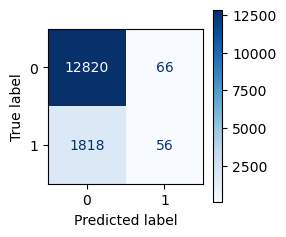

In [281]:
# Выведем значения метрик при помощи подготовленной функции (threshold = 0.5)
get_classification_metrics(y_valid, y_pred, y_pred_proba)

# Выведем значения метрик при помощи встроенной функции (threshold = 0.5)
report = classification_report(y_valid, y_pred)
print(report)

# Изобразим матрицу ошибок (threshold = 0.5)
plt.rcParams['figure.figsize'] = (2.5, 2.5) 
get_confusion_matrix(y_valid, y_pred)

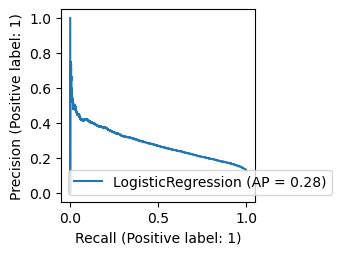

In [282]:
plot_precision_recall_curve(LogReg, X_train, y_train)

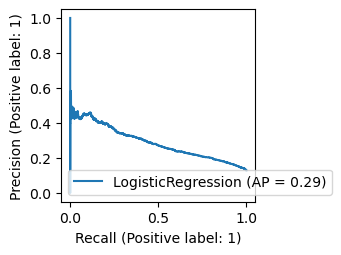

In [283]:
plot_precision_recall_curve(LogReg, X_valid, y_valid)

In [31]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid, y_pred_proba)  

'threshold: 0.18292000000000003, f1_score: 0.355912294440094'

Метрики качества классификации:
 - Accuracy: 0.7771
 - Precision: 0.2811
 - Recall: 0.4851
 - F1_score: 0.3559
 - Roc_auc_score: 0.7349
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     12886
           1       0.28      0.49      0.36      1874

    accuracy                           0.78     14760
   macro avg       0.60      0.65      0.61     14760
weighted avg       0.84      0.78      0.80     14760



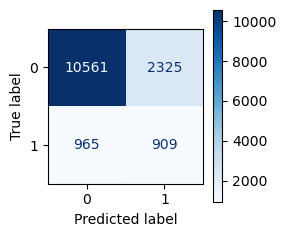

In [284]:
# threshold = 0.18292
y_pred_th = np.where(y_pred_proba >= 0.18292, 1, 0)

get_classification_metrics(y_valid, y_pred_th, y_pred_proba)
print(classification_report(y_valid, y_pred_th))
get_confusion_matrix(y_valid, y_pred_th)

Наивная модель со стандартными параметрами довольно слабая. Она слабо определяет дефолтных клиентов.  

**Подберем параметры при помощи GRIDSEARCH и посмотрим на качество**

In [285]:
# Запустим GridSearch на небольшом кол-ве итераций (max_iter = 50) и с достаточно большой дельтой останова (tol1e-3)
# чтобы получить оптимальные параметры модели в первом приближении  
iter_ = 100
epsilon_stop = 1e-3

param_grid = [
    {'penalty' : ['l1'], 
     'solver' : ['liblinear', 'lbfgs'], 
     'class_weight' :['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter' : [iter_],
     'tol' : [epsilon_stop]},
    {'penalty' : ['l2'], 
     'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight' : ['none', 'balanced'], 
     'multi_class' : ['auto','ovr'], 
     'max_iter' : [iter_],
     'tol' : [epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight' : ['none', 'balanced'], 
     'multi_class' : ['auto','ovr'], 
     'max_iter' : [iter_],
     'tol' : [epsilon_stop]},
]

# Модель логистической регрессии на изначальной несбалансированной выборке
grid_search = GridSearchCV(LogReg, param_grid, scoring = 'f1', n_jobs = -1, cv = 5)
grid_search.fit(X_train, y_train)
best_LogReg = grid_search.best_estimator_

# Отобразим параметры
best_parameters = best_LogReg.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False


Метрики качества классификации:
 - Accuracy: 0.6650
 - Precision: 0.2266
 - Recall: 0.6793
 - F1_score: 0.3399
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.93      0.66      0.78     12886
           1       0.23      0.68      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



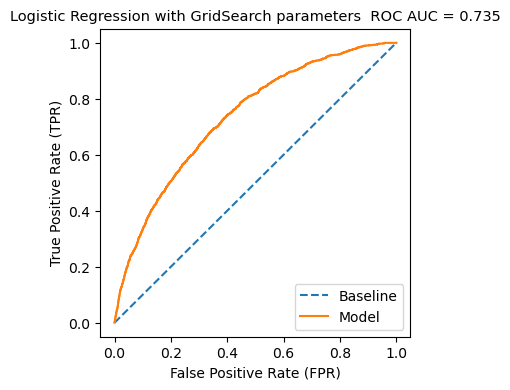

In [286]:
y_pred_new = best_LogReg.predict(X_valid)
y_pred_proba_new = best_LogReg.predict_proba(X_valid)[:, 1]

# Посмотрим на качество модели (threshold = 0.5)
get_classification_metrics(y_valid, y_pred_new, y_pred_proba_new)
report = classification_report(y_valid, y_pred_new)
print(report)
ROC_curve_plot(y_valid, y_pred_proba_new, 'Logistic Regression with GridSearch parameters')

Метрики качества классификации:
 - Accuracy: 0.6650
 - Precision: 0.2266
 - Recall: 0.6793
 - F1_score: 0.3399
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.93      0.66      0.78     12886
           1       0.23      0.68      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



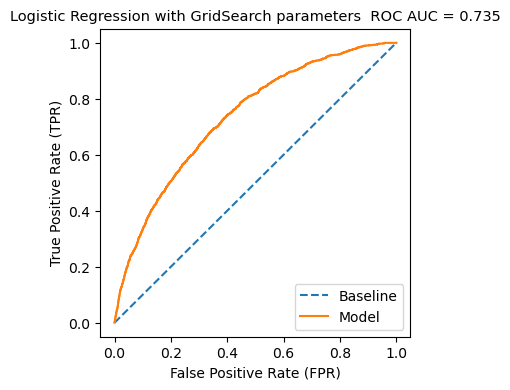

In [287]:
y_pred_new = best_LogReg.predict(X_valid)
y_pred_proba_new = best_LogReg.predict_proba(X_valid)[:, 1]

# Посмотрим на качество модели (threshold = 0.5)
get_classification_metrics(y_valid, y_pred_new, y_pred_proba_new)
report = classification_report(y_valid, y_pred_new)
print(report)
ROC_curve_plot(y_valid, y_pred_proba_new, 'Logistic Regression with GridSearch parameters')

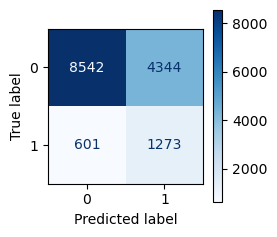

In [288]:
# threshold = 0.5
get_confusion_matrix(y_valid, y_pred_new)

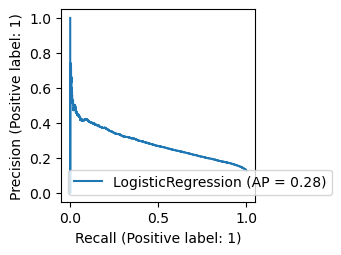

In [290]:
plot_precision_recall_curve(best_LogReg, X_train, y_train)

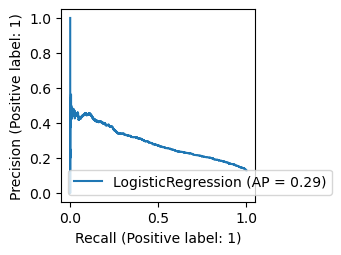

In [289]:
plot_precision_recall_curve(best_LogReg, X_valid, y_valid)

In [334]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid, y_pred_proba_new)  

'threshold: 0.6323200000000001, f1_score: 0.35331768721997014'

Метрики качества классификации:
 - Accuracy: 0.7946
 - Precision: 0.2943
 - Recall: 0.4418
 - F1_score: 0.3533
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     12886
           1       0.29      0.44      0.35      1874

    accuracy                           0.79     14760
   macro avg       0.60      0.64      0.62     14760
weighted avg       0.83      0.79      0.81     14760



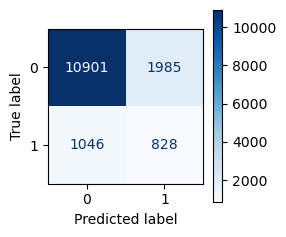

In [337]:
# threshold = 0.63232
y_pred_th = np.where(y_pred_proba_new >= 0.63232, 1, 0)

get_classification_metrics(y_valid, y_pred_th, y_pred_proba_new)
print(classification_report(y_valid, y_pred_th))
get_confusion_matrix(y_valid, y_pred_th)

Модель с подобранными параметрами на исходной (несбалансированной) выборке определяет довольно мало истинно-положительных элементов (TP) и много ложно-положительных (FP). 

### 2) Логистическая регрессия на сбалансированной выборке (после RandomOverSampler)

Метрики качества классификации:
 - Accuracy: 0.7262
 - Precision: 0.2505
 - Recall: 0.5806
 - F1_score: 0.3500
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     12886
           1       0.25      0.58      0.35      1874

    accuracy                           0.73     14760
   macro avg       0.59      0.66      0.59     14760
weighted avg       0.84      0.73      0.77     14760



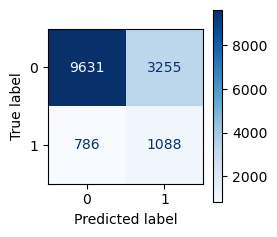

In [33]:
# Запустим наивную модель логистической регрессии со стандартными параметрами  
LogReg_1 = LogisticRegression(random_state = RANDOM_SEED, max_iter = 1000).fit(X_train_1, y_train_1)
y_pred_1 = LogReg_1.predict(X_valid_1)
y_pred_proba_1 = LogReg_1.predict_proba(X_valid_1)[:, 1]

# Посмотрим на качество модели (threshold = 0.5)
get_classification_metrics(y_valid_1, y_pred_1, y_pred_proba_1)
report_1 = classification_report(y_valid_1, y_pred_1)
print(report_1)

get_confusion_matrix(y_valid_1, y_pred_1)

In [34]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid_1, y_pred_proba_1)  

'threshold: 0.56864, f1_score: 0.3536937680561288'

Метрики качества классификации:
 - Accuracy: 0.7878
 - Precision: 0.2884
 - Recall: 0.4573
 - F1_score: 0.3537
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     12886
           1       0.29      0.46      0.35      1874

    accuracy                           0.79     14760
   macro avg       0.60      0.65      0.61     14760
weighted avg       0.83      0.79      0.81     14760



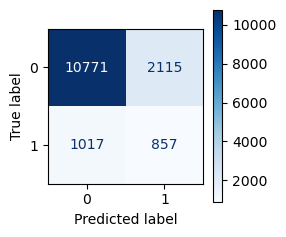

In [35]:
# threshold = 0.56864
y_pred_th = np.where(y_pred_proba_1 >= 0.56864, 1, 0)

get_classification_metrics(y_valid_1, y_pred_th, y_pred_proba_1)
print(classification_report(y_valid_1, y_pred_th))
get_confusion_matrix(y_valid_1, y_pred_th)

Данная модель также довольно плохо определяет элементы положительного класса, много ложно-позитивных (FP - 2115) и ложно-негативных элементов (FN - 1017)    

**Подберем параметры при помощи GRIDSEARCH и посмотрим на качество**

In [38]:
# Подберем параметры для модели логистической регрессии на сбалансированной (oversampling) выборке
grid_search_1 = GridSearchCV(LogReg_1, param_grid, scoring = 'f1', n_jobs = -1, cv = 5)
grid_search_1.fit(X_train_1, y_train_1)
best_LogReg_1 = grid_search_1.best_estimator_

# Отобразим параметры
print(f'Параметры, предложенные GridSearchCV:\n{grid_search_1.best_params_}')

Параметры, предложенные GridSearchCV:
{'class_weight': 'balanced', 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'saga', 'tol': 0.001}


Метрики качества классификации:
 - Accuracy: 0.6648
 - Precision: 0.2257
 - Recall: 0.6750
 - F1_score: 0.3383
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.93      0.66      0.78     12886
           1       0.23      0.68      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



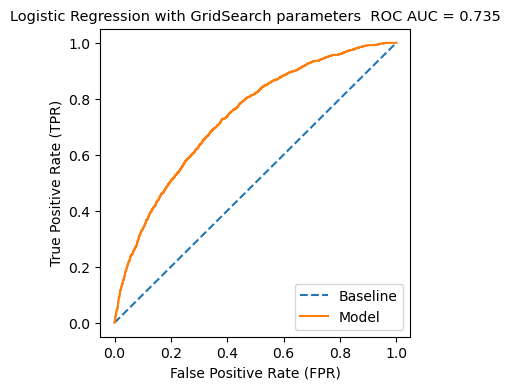

In [39]:
y_pred_new_1 = best_LogReg_1.predict(X_valid_1)
y_pred_proba_new_1 = best_LogReg_1.predict_proba(X_valid_1)[:,1]

# Посмотрим на качество модели (threshold = 0.5)
get_classification_metrics(y_valid_1, y_pred_new_1, y_pred_proba_new_1)
report_1 = classification_report(y_valid_1, y_pred_new_1) 
print(report_1)
ROC_curve_plot(y_valid_1, y_pred_proba_new_1, 'Logistic Regression with GridSearch parameters')

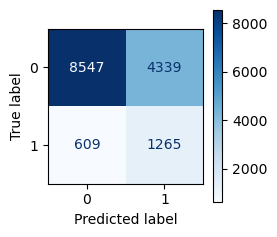

In [40]:
# threshold = 0.5
get_confusion_matrix(y_valid_1, y_pred_new_1)

In [41]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid_1, y_pred_proba_new_1)  

'threshold: 0.62556, f1_score: 0.3532348658206782'

Метрики качества классификации:
 - Accuracy: 0.7894
 - Precision: 0.2895
 - Recall: 0.4530
 - F1_score: 0.3532
 - Roc_auc_score: 0.7348
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     12886
           1       0.29      0.45      0.35      1874

    accuracy                           0.79     14760
   macro avg       0.60      0.65      0.61     14760
weighted avg       0.83      0.79      0.81     14760



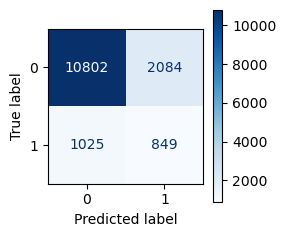

In [42]:
# threshold = 0.62556
y_pred_th = np.where(y_pred_proba_new_1 >= 0.62556, 1, 0)

get_classification_metrics(y_valid_1, y_pred_th, y_pred_proba_new_1)
print(classification_report(y_valid_1, y_pred_th))
get_confusion_matrix(y_valid_1, y_pred_th)

Модель с подобранными параметрами на сбалансированной (oversampling) выборке также определяет довольно много ложно-позитивных и ложно-негативных элементов.

### 3) Логистическая регрессия на сбалансированной выборке (после RandomUnderSampler)

Метрики качества классификации:
 - Accuracy: 0.6638
 - Precision: 0.2249
 - Recall: 0.6740
 - F1_score: 0.3373
 - Roc_auc_score: 0.7344
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     12886
           1       0.22      0.67      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



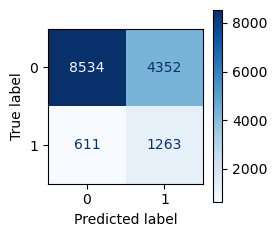

In [44]:
# Запустим наивную модель логистической регрессии со стандартными параметрами  
LogReg_2 = LogisticRegression(random_state = RANDOM_SEED, max_iter = 1000).fit(X_train_2, y_train_2)
y_pred_2 = LogReg_2.predict(X_valid_2)
y_pred_proba_2 = LogReg_2.predict_proba(X_valid_2)[:,1]

# Посмотрим на качество модели (threshold = 0.5)
get_classification_metrics(y_valid_2, y_pred_2, y_pred_proba_2)
report_2 = classification_report(y_valid_2, y_pred_2)
print(report_2)

get_confusion_matrix(y_valid_2, y_pred_2)

In [45]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid_2, y_pred_proba_2)  

'threshold: 0.6239800000000001, f1_score: 0.35478478896782284'

Метрики качества классификации:
 - Accuracy: 0.7908
 - Precision: 0.2916
 - Recall: 0.4530
 - F1_score: 0.3548
 - Roc_auc_score: 0.7344
              precision    recall  f1-score   support

           0       0.91      0.84      0.88     12886
           1       0.29      0.45      0.35      1874

    accuracy                           0.79     14760
   macro avg       0.60      0.65      0.61     14760
weighted avg       0.83      0.79      0.81     14760



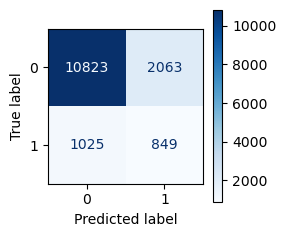

In [46]:
# threshold = 0.62398
y_pred_th = np.where(y_pred_proba_2 >= 0.62398 , 1, 0)

get_classification_metrics(y_valid_2, y_pred_th, y_pred_proba_2)
print(classification_report(y_valid_2, y_pred_th))
get_confusion_matrix(y_valid_2, y_pred_th)

**Подберем параметры при помощи GRIDSEARCH и посмотрим на качество**

In [47]:
# Подберем параметры для модели логистической регрессии на сбалансированной (undersampling) выборке
grid_search_2 = GridSearchCV(LogReg_2, param_grid, scoring = 'f1', n_jobs = -1, cv = 5)
grid_search_2.fit(X_train_2, y_train_2)
best_LogReg_2 = grid_search_2.best_estimator_

# Отобразим параметры
print(f'Параметры, предложенные GridSearchCV:\n{grid_search_2.best_params_}')

Параметры, предложенные GridSearchCV:
{'class_weight': 'none', 'max_iter': 100, 'multi_class': 'auto', 'penalty': 'none', 'solver': 'sag', 'tol': 0.001}


Метрики качества классификации:
 - Accuracy: 0.6636
 - Precision: 0.2249
 - Recall: 0.6745
 - F1_score: 0.3373
 - Roc_auc_score: 0.7343
              precision    recall  f1-score   support

           0       0.93      0.66      0.77     12886
           1       0.22      0.67      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



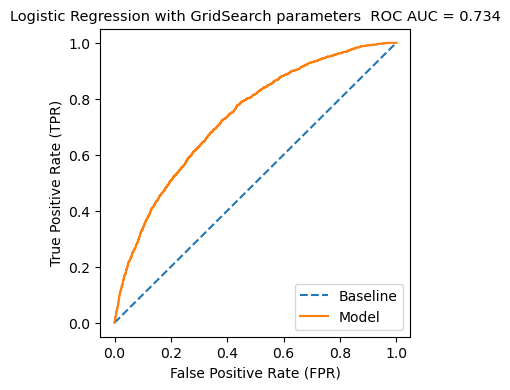

In [48]:
y_pred_new_2 = best_LogReg_2.predict(X_valid_2)
y_pred_proba_new_2 = best_LogReg_2.predict_proba(X_valid_2)[:,1]

# Посмотрим на качество модели (threshold = 0.5)
get_classification_metrics(y_valid_2, y_pred_new_2, y_pred_proba_new_2)
report_2 = classification_report(y_valid_2, y_pred_new_2) 
print(report_2)
ROC_curve_plot(y_valid_2, y_pred_proba_new_2, 'Logistic Regression with GridSearch parameters')

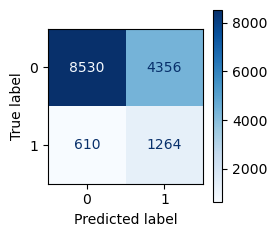

In [49]:
# threshold = 0.5
get_confusion_matrix(y_valid_2, y_pred_new_2)

In [50]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid_2, y_pred_proba_new_2)  

'threshold: 0.62402, f1_score: 0.35485893416927894'

Метрики качества классификации:
 - Accuracy: 0.7909
 - Precision: 0.2917
 - Recall: 0.4530
 - F1_score: 0.3549
 - Roc_auc_score: 0.7343
              precision    recall  f1-score   support

           0       0.91      0.84      0.88     12886
           1       0.29      0.45      0.35      1874

    accuracy                           0.79     14760
   macro avg       0.60      0.65      0.62     14760
weighted avg       0.83      0.79      0.81     14760



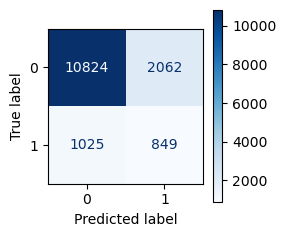

In [52]:
# threshold = 0.62402
y_pred_th = np.where(y_pred_proba_new_2 >= 0.62402, 1, 0)

get_classification_metrics(y_valid_2, y_pred_th, y_pred_proba_new_2)
print(classification_report(y_valid_2, y_pred_th))
get_confusion_matrix(y_valid_2, y_pred_th)

Модель с подобранными параметрами на сбалансированной (undersampling) выборке не сильно отличается от предыдущей. Она также определяет довольно много ложно-положительных элементов. 

**Применим регуляризацию L1 и L2 и посмотрим на результат**

In [54]:
# Логистическая регрессия с применением регуляризации L1
LogReg_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear', class_weight = 'balanced', tol = 0.001, 
                                  random_state = RANDOM_SEED, n_jobs = -1, max_iter = 1000).fit(X_train, y_train)
y_pred_l1 = LogReg_l1.predict(X_valid)
y_pred_proba_l1 = LogReg_l1.predict_proba(X_valid)[:, 1]

print('Логистическая регрессия с применением регуляризации L1')
get_classification_metrics(y_valid, y_pred_l1, y_pred_proba_l1)   # threshold = 0.5
display(confusion_matrix(y_valid, y_pred_l1))

# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid, y_pred_proba_l1)  

Логистическая регрессия с применением регуляризации L1
Метрики качества классификации:
 - Accuracy: 0.6650
 - Precision: 0.2266
 - Recall: 0.6788
 - F1_score: 0.3397
 - Roc_auc_score: 0.7348


array([[8544, 4342],
       [ 602, 1272]], dtype=int64)

'threshold: 0.61906, f1_score: 0.3531326281529699'

In [55]:
# threshold = 0.61906
y_pred_th = np.where(y_pred_proba_l1 >= 0.61906, 1, 0)

get_classification_metrics(y_valid, y_pred_th, y_pred_proba_l1)
confusion_matrix(y_valid, y_pred_th)

Метрики качества классификации:
 - Accuracy: 0.7846
 - Precision: 0.2853
 - Recall: 0.4632
 - F1_score: 0.3531
 - Roc_auc_score: 0.7348


array([[10712,  2174],
       [ 1006,   868]], dtype=int64)

In [56]:
# Логистическая регрессия с применением регуляризации L2
LogReg_l2 = LogisticRegression(penalty = 'l2', solver = 'sag', class_weight = 'balanced',  tol = 0.001, 
                              random_state = RANDOM_SEED, n_jobs = -1, max_iter = 1000).fit(X_train, y_train)
y_pred_l2 = LogReg_l2.predict(X_valid)
y_pred_proba_l2 = LogReg_l2.predict_proba(X_valid)[:, 1]

print('Логистическая регрессия с применением регуляризации L2')
get_classification_metrics(y_valid, y_pred_l2, y_pred_proba_l2)   # threshold = 0.5
confusion_matrix(y_valid, y_pred_l2)

# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid, y_pred_proba_l2)  


Логистическая регрессия с применением регуляризации L2
Метрики качества классификации:
 - Accuracy: 0.6649
 - Precision: 0.2266
 - Recall: 0.6793
 - F1_score: 0.3398
 - Roc_auc_score: 0.7348


'threshold: 0.6218800000000001, f1_score: 0.35308641975308647'

In [57]:
# threshold = 0.62188
y_pred_th = np.where(y_pred_proba_l2 >= 0.62188, 1, 0)

get_classification_metrics(y_valid, y_pred_th, y_pred_proba_l2)
confusion_matrix(y_valid, y_pred_th)

Метрики качества классификации:
 - Accuracy: 0.7870
 - Precision: 0.2873
 - Recall: 0.4578
 - F1_score: 0.3531
 - Roc_auc_score: 0.7348


array([[10758,  2128],
       [ 1016,   858]], dtype=int64)

## Решающее дерево и бэггинг  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">Документация DecisionTreeClassifier</a>  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html">Документация BaggingClassifier</a>

DecisionTreeClassifier со стандартными параметрами : 
 - Cross_val_score: 0.205

Метрики качества классификации:
 - Accuracy: 0.7934
 - Precision: 0.2075
 - Recall: 0.2225
 - F1_score: 0.2147
 - Roc_auc_score: 0.5494


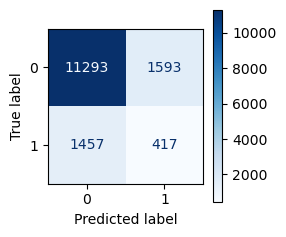

In [62]:
# Решающее дерево со стандартными параметрами (установим только 'max_features')
# Обучение на кросс-валидации на исходной выборке
tr = DecisionTreeClassifier(max_features = "sqrt", random_state = RANDOM_SEED) 
score = cross_val_score(tr, X_train, y_train, cv = 5, scoring = 'f1').mean()  
print(f'DecisionTreeClassifier со стандартными параметрами : \n - Cross_val_score: {score:.3f}\n')

# threshold = 0.5
y_pred_tr = fit_and_get_metrics(tr, X_train, y_train, X_valid, y_valid, get_y_pred = True)
get_confusion_matrix(y_valid, y_pred_tr)  

BaggingClassifier на исходном датасете: 
 - cross_val_score: 0.039

Метрики качества классификации:
 - Accuracy: 0.8726
 - Precision: 0.4762
 - Recall: 0.0320
 - F1_score: 0.0600
 - Roc_auc_score: 0.7078


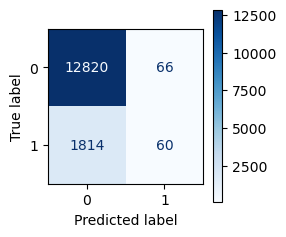

In [63]:
# Бэггинг 
bg = BaggingClassifier(tr, n_estimators = 1000, random_state = RANDOM_SEED, n_jobs = -1)
cross_val = cross_val_score(bg, X_train, y_train, cv = 5, scoring = 'f1').mean()
print(f'BaggingClassifier на исходном датасете: \n - cross_val_score: {cross_val:.3f}\n')  

# threshold = 0.5
y_pred_bg = fit_and_get_metrics(bg, X_train, y_train, X_valid, y_valid, get_y_pred = True)
get_confusion_matrix(y_valid, y_pred_bg)

## Случайный лес  
Поищем наиболее приемлемые параметры при помощи **RandomizedSearchCV** и **GridSearchCV**  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">Документация RandomForestClassifier</a>    
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">Документация RandomizedSearchCV</a>   
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">Документация GridSearchCV</a> 

Метрики качества классификации:
 - Accuracy: 0.8718
 - Precision: 0.4357
 - Recall: 0.0326
 - F1_score: 0.0606
 - Roc_auc_score: 0.6987


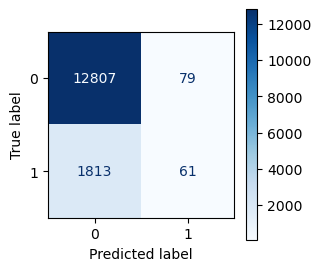

In [895]:
# Модель со стандартными параметрами
rf = RandomForestClassifier(random_state = RANDOM_SEED).fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)
y_pred_proba_rf = rf.predict_proba(X_valid)[:, 1]

# threshold = 0.5
get_classification_metrics(y_valid, y_pred_rf, y_pred_proba_rf)
get_confusion_matrix(y_valid, y_pred_rf)

In [898]:
# Подберем параметры при помощи RandomizedSearchCV
rf_random_params = {'n_estimators' : range(50, 500, 10), 'max_depth' : range(3, 30), 'min_samples_leaf' : range(5, 40, 5),
                    'min_samples_split': range(5, 40, 5), 'criterion' : ['entropy', 'gini'], 
                    'max_features' : ['auto', 'sqrt'], 'class_weight' : ['balanced', 'balanced_subsample']}

randomised_rf = RandomizedSearchCV(rf, rf_random_params, n_iter = 100, cv = 3, n_jobs = -1, scoring='f1').fit(X_train, y_train)

Параметры, предложенные RandomizedSearchCV: 
{'n_estimators': 400, 'min_samples_split': 35, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 16, 'criterion': 'gini', 'class_weight': 'balanced_subsample'}

Cross_val_score: 0.344
Метрики качества классификации:
 - Accuracy: 0.7503
 - Precision: 0.2627
 - Recall: 0.5352
 - F1_score: 0.3524
 - Roc_auc_score: 0.7331


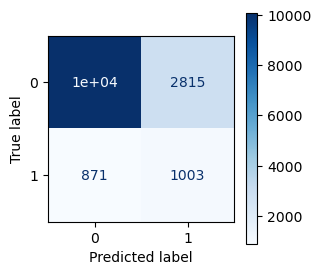

In [913]:
# Посмотрим параметры и качество модели
print(f'Параметры, предложенные RandomizedSearchCV: \n{randomised_rf.best_params_}')
randomised_rf = randomised_rf.best_estimator_

score_random = cross_val_score(randomised_rf, X_train, y_train, cv = 5, scoring = 'f1').mean()  
y_pred_rf_random = randomised_rf.predict(X_valid)
y_pred_rf_random_proba = randomised_rf.predict_proba(X_valid)[:, 1]

print(f'\nCross_val_score: {score_random:.3f}')
get_classification_metrics(y_valid, y_pred_rf_random, y_pred_rf_random_proba)   # threshold = 0.5
get_confusion_matrix(y_valid, y_pred_rf_random)

In [914]:
# Подберем параметры при помощи GridSearchCV
rf_grid_params = [{'n_estimators' : range(50, 400, 50), 'max_depth' : range(3, 30, 3), 'min_samples_leaf': range(5, 40, 5),
                  'min_samples_split' : range(5,40,5), 'criterion': ['entropy'], 'max_features' : ['auto', 'sqrt'],
                  'class_weight' : ['balanced', 'balanced_subsample']}]

gridsearch_rf = GridSearchCV(rf, rf_grid_params, scoring = 'f1', n_jobs = -1, cv = 3, verbose = 10)
gridsearch_rf.fit(X_train, y_train)

Fitting 3 folds for each of 12348 candidates, totalling 37044 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'class_weight': ['balanced', 'balanced_subsample'],
                          'criterion': ['entropy'],
                          'max_depth': range(3, 30, 3),
                          'max_features': ['auto', 'sqrt'],
                          'min_samples_leaf': range(5, 40, 5),
                          'min_samples_split': range(5, 40, 5),
                          'n_estimators': range(50, 400, 50)}],
             scoring='f1', verbose=10)

Параметры, предложенные GridSearchCV: 
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 21, 'max_features': 'auto', 'min_samples_leaf': 15, 'min_samples_split': 35, 'n_estimators': 300}
Метрики качества классификации:
 - Accuracy: 0.7457
 - Precision: 0.2623
 - Recall: 0.5534
 - F1_score: 0.3559
 - Roc_auc_score: 0.7339
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     12886
           1       0.26      0.55      0.36      1874

    accuracy                           0.75     14760
   macro avg       0.59      0.66      0.60     14760
weighted avg       0.84      0.75      0.78     14760



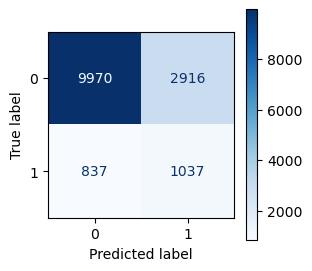

In [915]:
# Посмотрим параметры и качество модели
print(f'Параметры, предложенные GridSearchCV: \n{gridsearch_rf.best_params_}')
model_rf = gridsearch_rf.best_estimator_

y_pred_rf = model_rf.predict(X_valid)
y_pred_proba_rf =  model_rf.predict_proba(X_valid)[:, 1]

# threshold = 0.5
get_classification_metrics(y_valid, y_pred_rf, y_pred_proba_rf)  
report_rf = classification_report(y_valid, y_pred_rf)
print(report_rf)
get_confusion_matrix(y_valid, y_pred_rf)

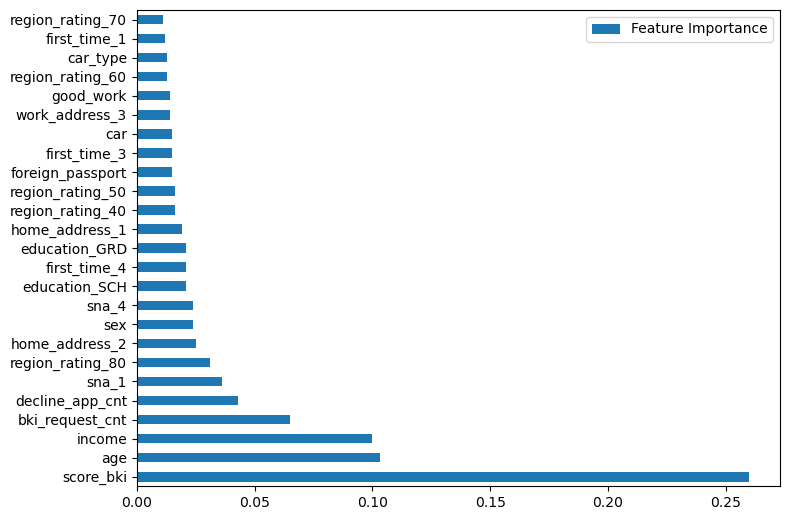

In [916]:
# Посмотрим на градацию признаков по их важности 
feature_importances = [round(x, 3) for x in model_rf.feature_importances_] 
pd.DataFrame(feature_importances, index = X_train.columns, columns = ['Feature Importance']) \
            .sort_values('Feature Importance', ascending = False)[:25].plot(kind = 'barh', figsize = (8, 5.3))
plt.tight_layout()

## Градиентный бустинг  
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">Документация GradientBoostingClassifier</a>

Поищем наиболее приемлемые параметры при помощи **RandomizedSearchCV**

In [58]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = y_train)
sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = class_weights[0]
sample_weights[y_train == 1] = class_weights[1]

Метрики качества классификации:
 - Accuracy: 0.6649
 - Precision: 0.2260
 - Recall: 0.6761
 - F1_score: 0.3388
 - Roc_auc_score: 0.7355


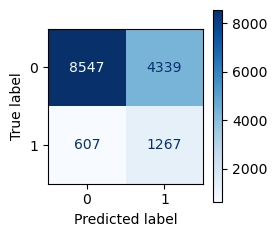

In [59]:
# Модель со стандартными параметрами
gb = GradientBoostingClassifier(random_state = RANDOM_SEED).fit(X_train, y_train, sample_weight = sample_weights)
y_pred_gb = gb.predict(X_valid)
y_pred_proba_gb = gb.predict_proba(X_valid)[:, 1]

# threshold = 0.5
get_classification_metrics(y_valid, y_pred_gb, y_pred_proba_gb) 
get_confusion_matrix(y_valid, y_pred_gb)

In [60]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid, y_pred_proba_gb)  

'threshold: 0.5582400000000001, f1_score: 0.35203158414212865'

In [61]:
# threshold = 0.55824
y_pred_th = np.where(y_pred_proba_gb >= 0.55824, 1, 0)

get_classification_metrics(y_valid, y_pred_th, y_pred_proba_gb)
confusion_matrix(y_valid, y_pred_th)

Метрики качества классификации:
 - Accuracy: 0.7331
 - Precision: 0.2545
 - Recall: 0.5710
 - F1_score: 0.3520
 - Roc_auc_score: 0.7355


array([[9751, 3135],
       [ 804, 1070]], dtype=int64)

In [918]:
# Подберем параметры при помощи RandomizedSearchCV
gb_random_params = [{'learning_rate' : [0.1, 0.01, 0.001], 'n_estimators' : range(100, 1200, 50), 'max_depth' : range(2, 30), 
                   'min_samples_leaf' : range(1, 30), 'warm_start' : [True, False], 'max_features' : ['sqrt', 'auto', 'log2'],
                   'min_samples_split': range(1, 30)}]

randomised_gb = RandomizedSearchCV(estimator = gb, param_distributions = gb_random_params, n_iter = 100, cv = 3, scoring='f1', 
                                   verbose = 10,  n_jobs = -1, random_state = RANDOM_SEED)
randomised_gb.fit(X_train, y_train, sample_weight = sample_weights)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'learning_rate': [0.1, 0.01, 0.001],
                                         'max_depth': range(2, 30),
                                         'max_features': ['sqrt', 'auto',
                                                          'log2'],
                                         'min_samples_leaf': range(1, 30),
                                         'min_samples_split': range(1, 30),
                                         'n_estimators': range(100, 1200, 50),
                                         'warm_start': [True, False]}],
                   random_state=42, scoring='f1', verbose=10)

Параметры, предложенные RandomizedSearchCV: 
{'warm_start': True, 'n_estimators': 800, 'min_samples_split': 23, 'min_samples_leaf': 22, 'max_features': 'sqrt', 'max_depth': 20, 'learning_rate': 0.001}
Метрики качества классификации:
 - Accuracy: 0.7229
 - Precision: 0.2468
 - Recall: 0.5763
 - F1_score: 0.3456
 - Roc_auc_score: 0.7312


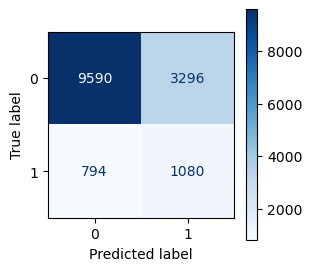

In [919]:
# Посмотрим параметры и качество модели 
print(f'Параметры, предложенные RandomizedSearchCV: \n{randomised_gb.best_params_}')
randomised_gb = randomised_gb.best_estimator_

y_pred_gb_random = randomised_gb.predict(X_valid)
y_pred_proba_gb_random = randomised_gb.predict_proba(X_valid)[:, 1]

# threshold = 0.5
get_classification_metrics(y_valid, y_pred_gb_random, y_pred_proba_gb_random)
get_confusion_matrix(y_valid, y_pred_gb_random)

In [62]:
gb_model = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, n_estimators = 1000, max_features = 'sqrt',
                                      min_samples_leaf = 1, min_samples_split = 4, warm_start = True, verbose = 1,   
                                      random_state = RANDOM_SEED)

gb_model.fit(X_train, y_train, sample_weight = sample_weights)
y_pred = gb_model.predict(X_valid)
y_pred_proba = gb_model.predict_proba(X_valid)[:,1]

print(f1_score(y_valid, y_pred))

      Iter       Train Loss   Remaining Time 
         1           1.3722           56.79s
         2           1.3636           48.77s
         3           1.3584           47.07s
         4           1.3504           46.44s
         5           1.3411           50.01s
         6           1.3361           49.79s
         7           1.3328           46.74s
         8           1.3298           44.07s
         9           1.3259           45.36s
        10           1.3222           43.78s
        20           1.2828           48.74s
        30           1.2587           47.42s
        40           1.2446           45.61s
        50           1.2352           44.39s
        60           1.2279           44.11s
        70           1.2226           43.54s
        80           1.2185           43.02s
        90           1.2153           41.60s
       100           1.2125           40.46s
       200           1.1997           35.56s
       300           1.1948           30.16s
       40

Метрики качества классификации:
 - Accuracy: 0.6667
 - Precision: 0.2280
 - Recall: 0.6809
 - F1_score: 0.3416
 - Roc_auc_score: 0.7374


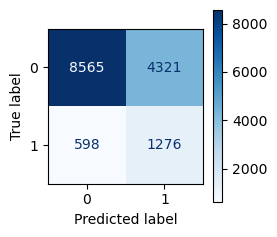

In [63]:
# threshold = 0.5
get_classification_metrics(y_valid, y_pred, y_pred_proba)
get_confusion_matrix(y_valid, y_pred)

In [64]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(y_valid, y_pred_proba)  

'threshold: 0.59562, f1_score: 0.3575689783743476'

Метрики качества классификации:
 - Accuracy: 0.7665
 - Precision: 0.2748
 - Recall: 0.5117
 - F1_score: 0.3576
 - Roc_auc_score: 0.7374


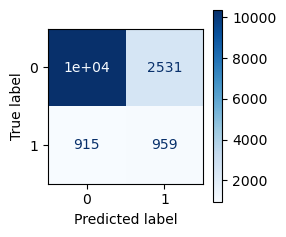

In [69]:
# threshold = 0.59562
y_pred_th = np.where(y_pred_proba >= 0.59562, 1, 0)

get_classification_metrics(y_valid, y_pred_th, y_pred_proba)
get_confusion_matrix(y_valid, y_pred_th)

## Стекинг

Для генерации фолдов используется класс **StratifiedKFold**.   
(Стратифицированные разбиения. В каждом фолде будет одинаковое соотношение классов. Разделим на 5 фолдов).  

**Выполним стекинг следующих алгоритмов:**  
- Логистическая регрессия  
- Случайный лес  
- Случайный лес из экстремальных деревьев
- Классификатор, основанный на методе ближайших соседей  
- Градиентный бустинг  


- В качестве мета-алгоритма используем несколько различных моделей и посмотрим на результат

In [13]:
def get_separate_meta_features(clf, X_train, X_test, y_train, cv):
    '''
    Функция для стекинга алгоритмов.
    Принимает на вход один классификатор и возвращает новые признаки на объектах, 
    которые не использовались во время обучения.
    '''
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype = np.float32)

    splits = cv.split(X_train,y_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test

In [14]:
def get_meta_features(classifiers, X_train, X_test, y_train, cv):
    '''
    Функция для стекинга алгоритмов. Принимает на вход несколько классификаторов в списке 
    и возвращает новые признаки; генерирует и возвращает матрицу с изначальным количеством объектов.  
    Для избежания переобучения применяется кросс-валидация.
    '''
    features_list = [
        get_separate_meta_features(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features_list
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features_list
    ])
    
    return stacked_features_train, stacked_features_test

In [15]:
def fit_and_get_metrics(clf, X_train, y_train, X_valid, y_valid, get_y_pred = False):
    # Обучение и подсчет метрик качества классификации
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_valid)
    y_pred_proba = clf.predict_proba(X_valid)[:, 1]
    get_classification_metrics(y_valid, y_pred, y_pred_proba)
    if get_y_pred == True:
        return (y_pred)

In [36]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED)    

In [37]:
# Получим мета-признаки, обучив базовые алгоритмы с дефолтными параметрами

features_train_d, features_test_d = get_meta_features([
                                                       LogisticRegression(random_state = RANDOM_SEED),
                                                       RandomForestClassifier(random_state = RANDOM_SEED),
                                                       ExtraTreesClassifier(random_state = RANDOM_SEED),
                                                       KNeighborsClassifier(n_jobs = -1),
                                                       GradientBoostingClassifier(random_state = RANDOM_SEED),
                                                         ], X_train.values, X_valid.values, y_train, cv)

100%|██████████| 5/5 [12:45<00:00, 153.11s/it]


In [38]:
# Мета-алгоритм LogisticRegression с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(LogisticRegression(random_state = RANDOM_SEED), 
                    features_train_d, y_train, features_test_d, y_valid) 

Метрики качества классификации:
 - Accuracy: 0.8718
 - Precision: 0.4625
 - Recall: 0.0592
 - F1_score: 0.1050
 - Roc_auc_score: 0.7367


In [39]:
# Мета-алгоритм LogisticRegression с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(LogisticRegression(class_weight = "balanced", solver = 'lbfgs', max_iter = 500, random_state=RANDOM_SEED), 
                    features_train_d, y_train, features_test_d, y_valid) 

Метрики качества классификации:
 - Accuracy: 0.7239
 - Precision: 0.2496
 - Recall: 0.5854
 - F1_score: 0.3500
 - Roc_auc_score: 0.7368


In [40]:
# Мета-алгоритм RandomForestClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(RandomForestClassifier(random_state = RANDOM_SEED), 
                    features_train_d, y_train, features_test_d, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8684
 - Precision: 0.3522
 - Recall: 0.0432
 - F1_score: 0.0770
 - Roc_auc_score: 0.6888


In [57]:
# Мета-алгоритм RandomForestClassifier с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(RandomForestClassifier(n_estimators = 400, min_samples_split=35, min_samples_leaf=10, max_features='auto',
                                           max_depth = 16, criterion = 'gini', class_weight = 'balanced_subsample'), 
                                           features_train_d, y_train, features_test_d, y_valid)

Метрики качества классификации:
 - Accuracy: 0.7353
 - Precision: 0.2512
 - Recall: 0.5475
 - F1_score: 0.3444
 - Roc_auc_score: 0.7268


In [49]:
# Мета-алгоритм GradientBoostingClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(GradientBoostingClassifier(random_state = RANDOM_SEED), 
                    features_train_d, y_train, features_test_d, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8726
 - Precision: 0.4375
 - Recall: 0.0112
 - F1_score: 0.0219
 - Roc_auc_score: 0.7364


In [50]:
# Мета-алгоритм GradientBoostingClassifier с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, n_estimators = 1000, 
                                max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 4, warm_start = True, 
                                random_state = RANDOM_SEED), 
                                features_train_d, y_train, features_test_d, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8721
 - Precision: 0.4327
 - Recall: 0.0240
 - F1_score: 0.0455
 - Roc_auc_score: 0.7326


In [58]:
# Мета-алгоритм KNeighborsClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(KNeighborsClassifier(n_jobs = -1), 
                    features_train_d, y_train, features_test_d, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8586
 - Precision: 0.2979
 - Recall: 0.0838
 - F1_score: 0.1308
 - Roc_auc_score: 0.6178


**Выполним стекинг следующих алгоритмов (с подобраннными параметрами):**  
- Логистическая регрессия  
- Случайный лес  
- Случайный лес из экстремальных деревьев  
- Градиентный бустинг   
- Классификатор, основанный на методе ближайших соседей  
 


- В качестве мета-алгоритма используем несколько различных моделей и посмотрим на результат

In [59]:
# Получим мета-признаки, обучив базовые алгоритмы с подобранными параметрами

features_train, features_test = get_meta_features([
        LogisticRegression(class_weight = 'balanced', max_iter = 700, multi_class = 'ovr', n_jobs = -1, penalty = 'none', 
                           solver = 'sag', tol = 0.001, random_state = RANDOM_SEED),
        RandomForestClassifier(n_estimators = 400, min_samples_split = 35, min_samples_leaf = 10, max_features = 'auto', 
                               max_depth = 16, criterion = 'gini', class_weight = 'balanced_subsample'),
        ExtraTreesClassifier(n_estimators = 300, n_jobs = -1, random_state = RANDOM_SEED),
        GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, n_estimators = 1000, max_features = 'sqrt', 
                                   min_samples_leaf = 1, min_samples_split = 4, warm_start = True, random_state = RANDOM_SEED),
        KNeighborsClassifier(n_jobs = -1)
    ], X_train.values, X_valid.values, y_train, cv)

100%|██████████| 5/5 [19:35<00:00, 235.03s/it]


In [60]:
# Мета-алгоритм LogisticRegression с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(LogisticRegression(random_state = RANDOM_SEED), 
                    features_train, y_train, features_test, y_valid) 

Метрики качества классификации:
 - Accuracy: 0.8732
 - Precision: 0.5556
 - Recall: 0.0053
 - F1_score: 0.0106
 - Roc_auc_score: 0.7371


In [61]:
# Мета-алгоритм LogisticRegression с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(LogisticRegression(class_weight = "balanced", solver = 'lbfgs', max_iter = 500, random_state=RANDOM_SEED), 
                    features_train, y_train, features_test, y_valid) 

Метрики качества классификации:
 - Accuracy: 0.6639
 - Precision: 0.2266
 - Recall: 0.6825
 - F1_score: 0.3402
 - Roc_auc_score: 0.7371


In [62]:
# Мета-алгоритм RandomForestClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(RandomForestClassifier(random_state = RANDOM_SEED), 
                   features_train, y_train, features_test, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8691
 - Precision: 0.3694
 - Recall: 0.0438
 - F1_score: 0.0782
 - Roc_auc_score: 0.6965


In [63]:
# Мета-алгоритм RandomForestClassifier с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 21, 
                                max_features = 'auto', min_samples_leaf = 15, min_samples_split = 35, n_estimators = 300,
                                random_state = RANDOM_SEED),
                                features_train, y_train, features_test, y_valid)

Метрики качества классификации:
 - Accuracy: 0.7667
 - Precision: 0.2713
 - Recall: 0.4968
 - F1_score: 0.3509
 - Roc_auc_score: 0.7237


In [64]:
# Мета-алгоритм GradientBoostingClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(GradientBoostingClassifier(random_state = RANDOM_SEED), 
                    features_train, y_train, features_test, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8735
 - Precision: 0.6000
 - Recall: 0.0112
 - F1_score: 0.0220
 - Roc_auc_score: 0.7366


In [65]:
# Мета-алгоритм GradientBoostingClassifier с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, n_estimators = 1000, 
                                max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 4, warm_start = True, 
                                random_state = RANDOM_SEED), 
                                features_train, y_train, features_test, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8727
 - Precision: 0.4762
 - Recall: 0.0267
 - F1_score: 0.0505
 - Roc_auc_score: 0.7307


In [66]:
# Мета-алгоритм KNeighborsClassifier c дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(KNeighborsClassifier(n_jobs = -1), 
                    features_train, y_train, features_test, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8571
 - Precision: 0.2957
 - Recall: 0.0907
 - F1_score: 0.1388
 - Roc_auc_score: 0.6197


**Выполним стекинг следующих алгоритмов (с подобраннными параметрами):**  
- Логистическая регрессия    
- Случайный лес из экстремальных деревьев  
- Классификатор, основанный на методе ближайших соседей    
- Адаптивный бустинг  


- В качестве мета-алгоритма используем несколько различных моделей и посмотрим на результат

In [67]:
# Получим мета-признаки, обучив базовые алгоритмы с подобранными параметрами

features_train_2, features_test_2 = get_meta_features([
        LogisticRegression(penalty = 'l1', solver = 'liblinear', class_weight = 'balanced', tol = 0.001, max_iter = 1000, 
                           n_jobs = -1, random_state = RANDOM_SEED),
        ExtraTreesClassifier(n_estimators = 300, n_jobs = -1, random_state = RANDOM_SEED),
        KNeighborsClassifier(n_jobs = -1),
        AdaBoostClassifier(random_state = RANDOM_SEED)
    ], X_train.values, X_valid.values, y_train, cv)

100%|██████████| 4/4 [08:08<00:00, 122.03s/it]


In [68]:
# Мета-алгоритм LogisticRegression с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(LogisticRegression(random_state = RANDOM_SEED), 
                    features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8731
 - Precision: 0.5238
 - Recall: 0.0059
 - F1_score: 0.0116
 - Roc_auc_score: 0.7354


In [69]:
# Мета-алгоритм LogisticRegression с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(LogisticRegression(class_weight = 'balanced', max_iter = 500, n_jobs = -1, 
                                penalty = 'none', solver = 'sag', tol = 0.001, random_state = RANDOM_SEED), 
                                features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.6658
 - Precision: 0.2269
 - Recall: 0.6782
 - F1_score: 0.3401
 - Roc_auc_score: 0.7355


In [70]:
# Мета-алгоритм RandomForestClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(RandomForestClassifier(random_state = RANDOM_SEED), 
                    features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8664
 - Precision: 0.3478
 - Recall: 0.0598
 - F1_score: 0.1020
 - Roc_auc_score: 0.6864


In [71]:
# Мета-алгоритм RandomForestClassifier с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(RandomForestClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 21, 
                                max_features = 'auto', min_samples_leaf = 15, min_samples_split = 35, n_estimators = 300,
                                random_state = RANDOM_SEED), 
                                features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.7504
 - Precision: 0.2530
 - Recall: 0.4947
 - F1_score: 0.3348
 - Roc_auc_score: 0.7202


In [72]:
# Мета-алгоритм GradientBoostingClassifier с дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(GradientBoostingClassifier(random_state = RANDOM_SEED), 
                    features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8728
 - Precision: 0.4681
 - Recall: 0.0117
 - F1_score: 0.0229
 - Roc_auc_score: 0.7344


In [73]:
# Мета-алгоритм GradientBoostingClassifier с подобранными параметрами (threshold = 0.5)
fit_and_get_metrics(GradientBoostingClassifier(learning_rate = 0.1, max_depth = 2, n_estimators = 1000, 
                                max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 4, warm_start = True, 
                                random_state = RANDOM_SEED), 
                                features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8712
 - Precision: 0.3902
 - Recall: 0.0256
 - F1_score: 0.0481
 - Roc_auc_score: 0.7321


In [74]:
# Мета-алгоритм KNeighborsClassifier c дефолтными параметрами (threshold = 0.5)
fit_and_get_metrics(KNeighborsClassifier(n_jobs = -1), 
                    features_train_2, y_train, features_test_2, y_valid)

Метрики качества классификации:
 - Accuracy: 0.8589
 - Precision: 0.3272
 - Recall: 0.1051
 - F1_score: 0.1591
 - Roc_auc_score: 0.6295


## LightAutoML (LAMA)

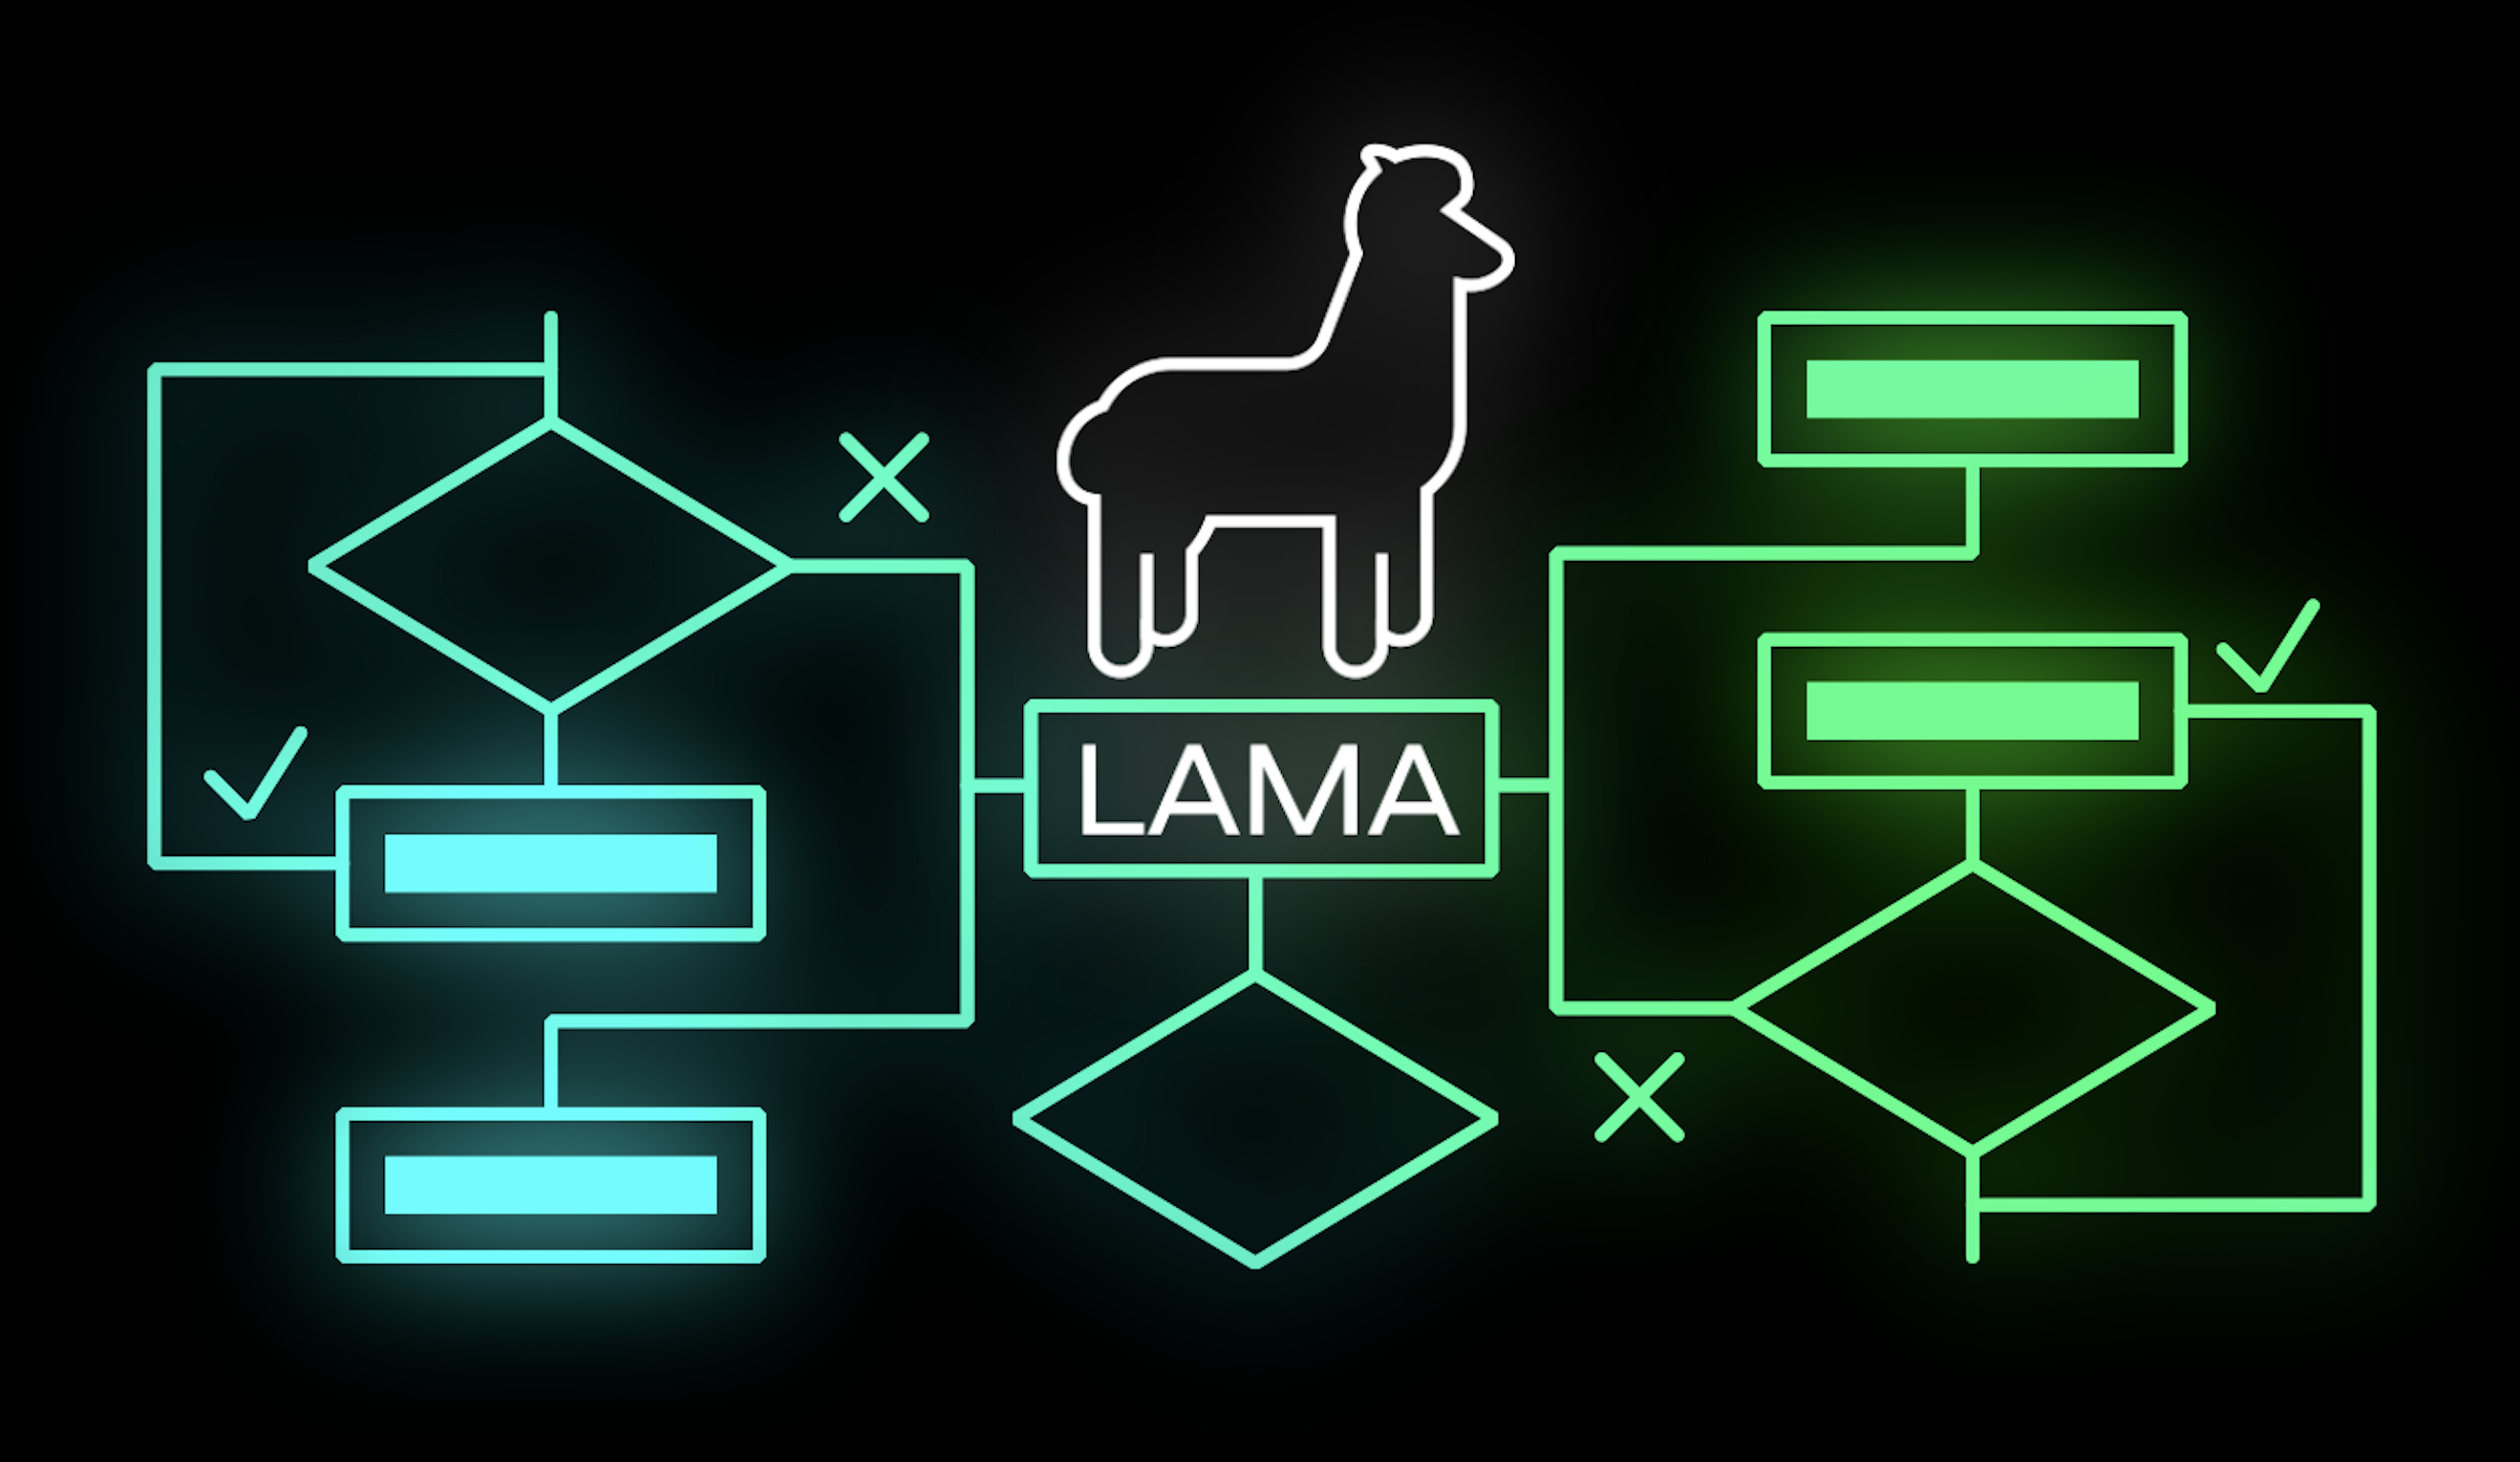

#### LightAutoML (LAMA) - automatic model creation framework  by Sber AI Lab  
#### Open source python фреймворк для задач:  
- Бинарной и мультиклассовой классификации  
- Регрессии  

#### Основные возможности:  
- Работает с текстом и изображенями  
- Готовые пресеты:  
    - Tabular   
    - Utilized
    - NLP  
    - CV  
    - Uplift  
    - WhiteBox для интерпретируемых моделей  
- Возможность кастомизации  
- Автоматическая типизация и предобработка признаков  
- Отчеты (декоратор) 
- Интеграция в SberCloud  

#### Полезные материалы:    
- <a href="https://lightautoml.readthedocs.io/en/latest/">Документация LightAutoML</a> 
- <a href="https://github.com/sberbank-ai-lab/LightAutoML">LightAutoML Github</a>
- <a href="https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop">Tutorials Github</a>     
- <a href="https://github.com/sb-ai-lab/LightAutoML/tree/master/lightautoml/automl/presets/tabular_configs">Конфигурации (YAML config)</a> 
- <a href="https://www.youtube.com/watch?v=hr8GbPOHaEE">Youtube-видео - LightAutoML: подход BlackBox</a>  
- <a href="https://www.youtube.com/watch?v=ajQwShL_Hak&t=2s">Youtube-видео - LightAutoML: подход WhiteBox</a>

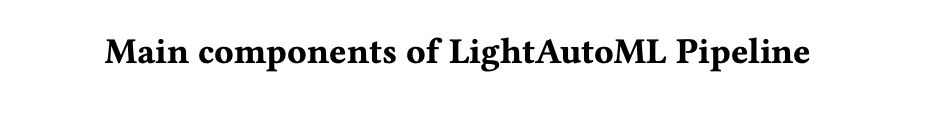

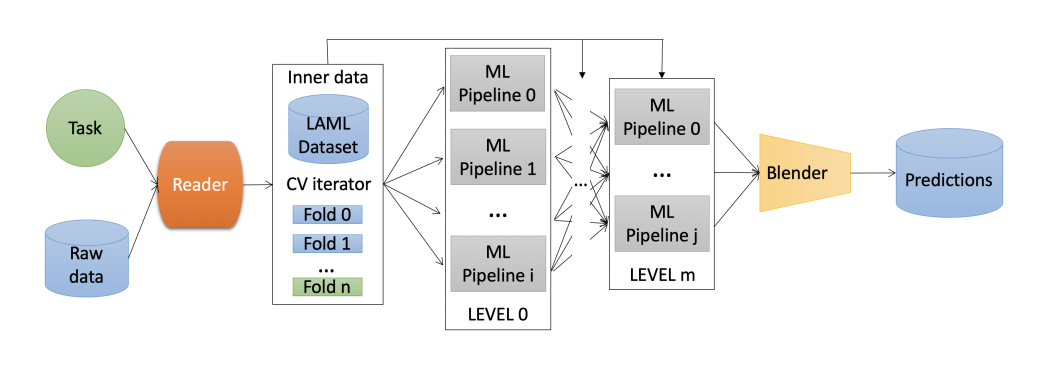

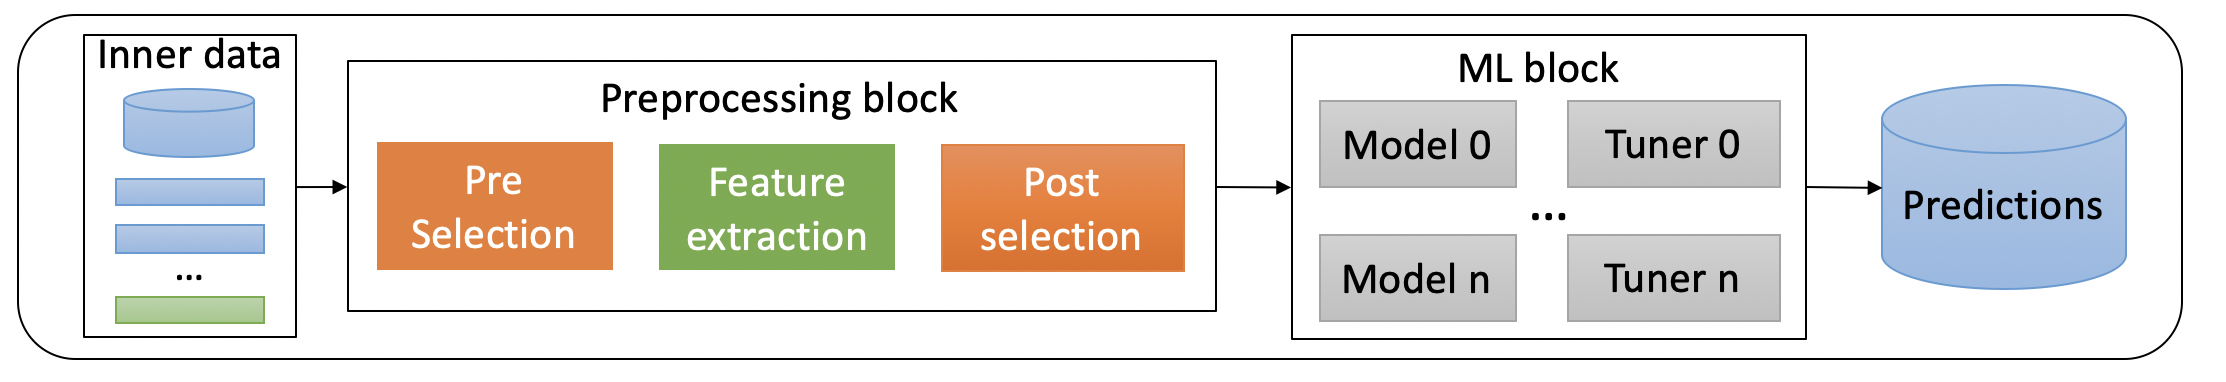

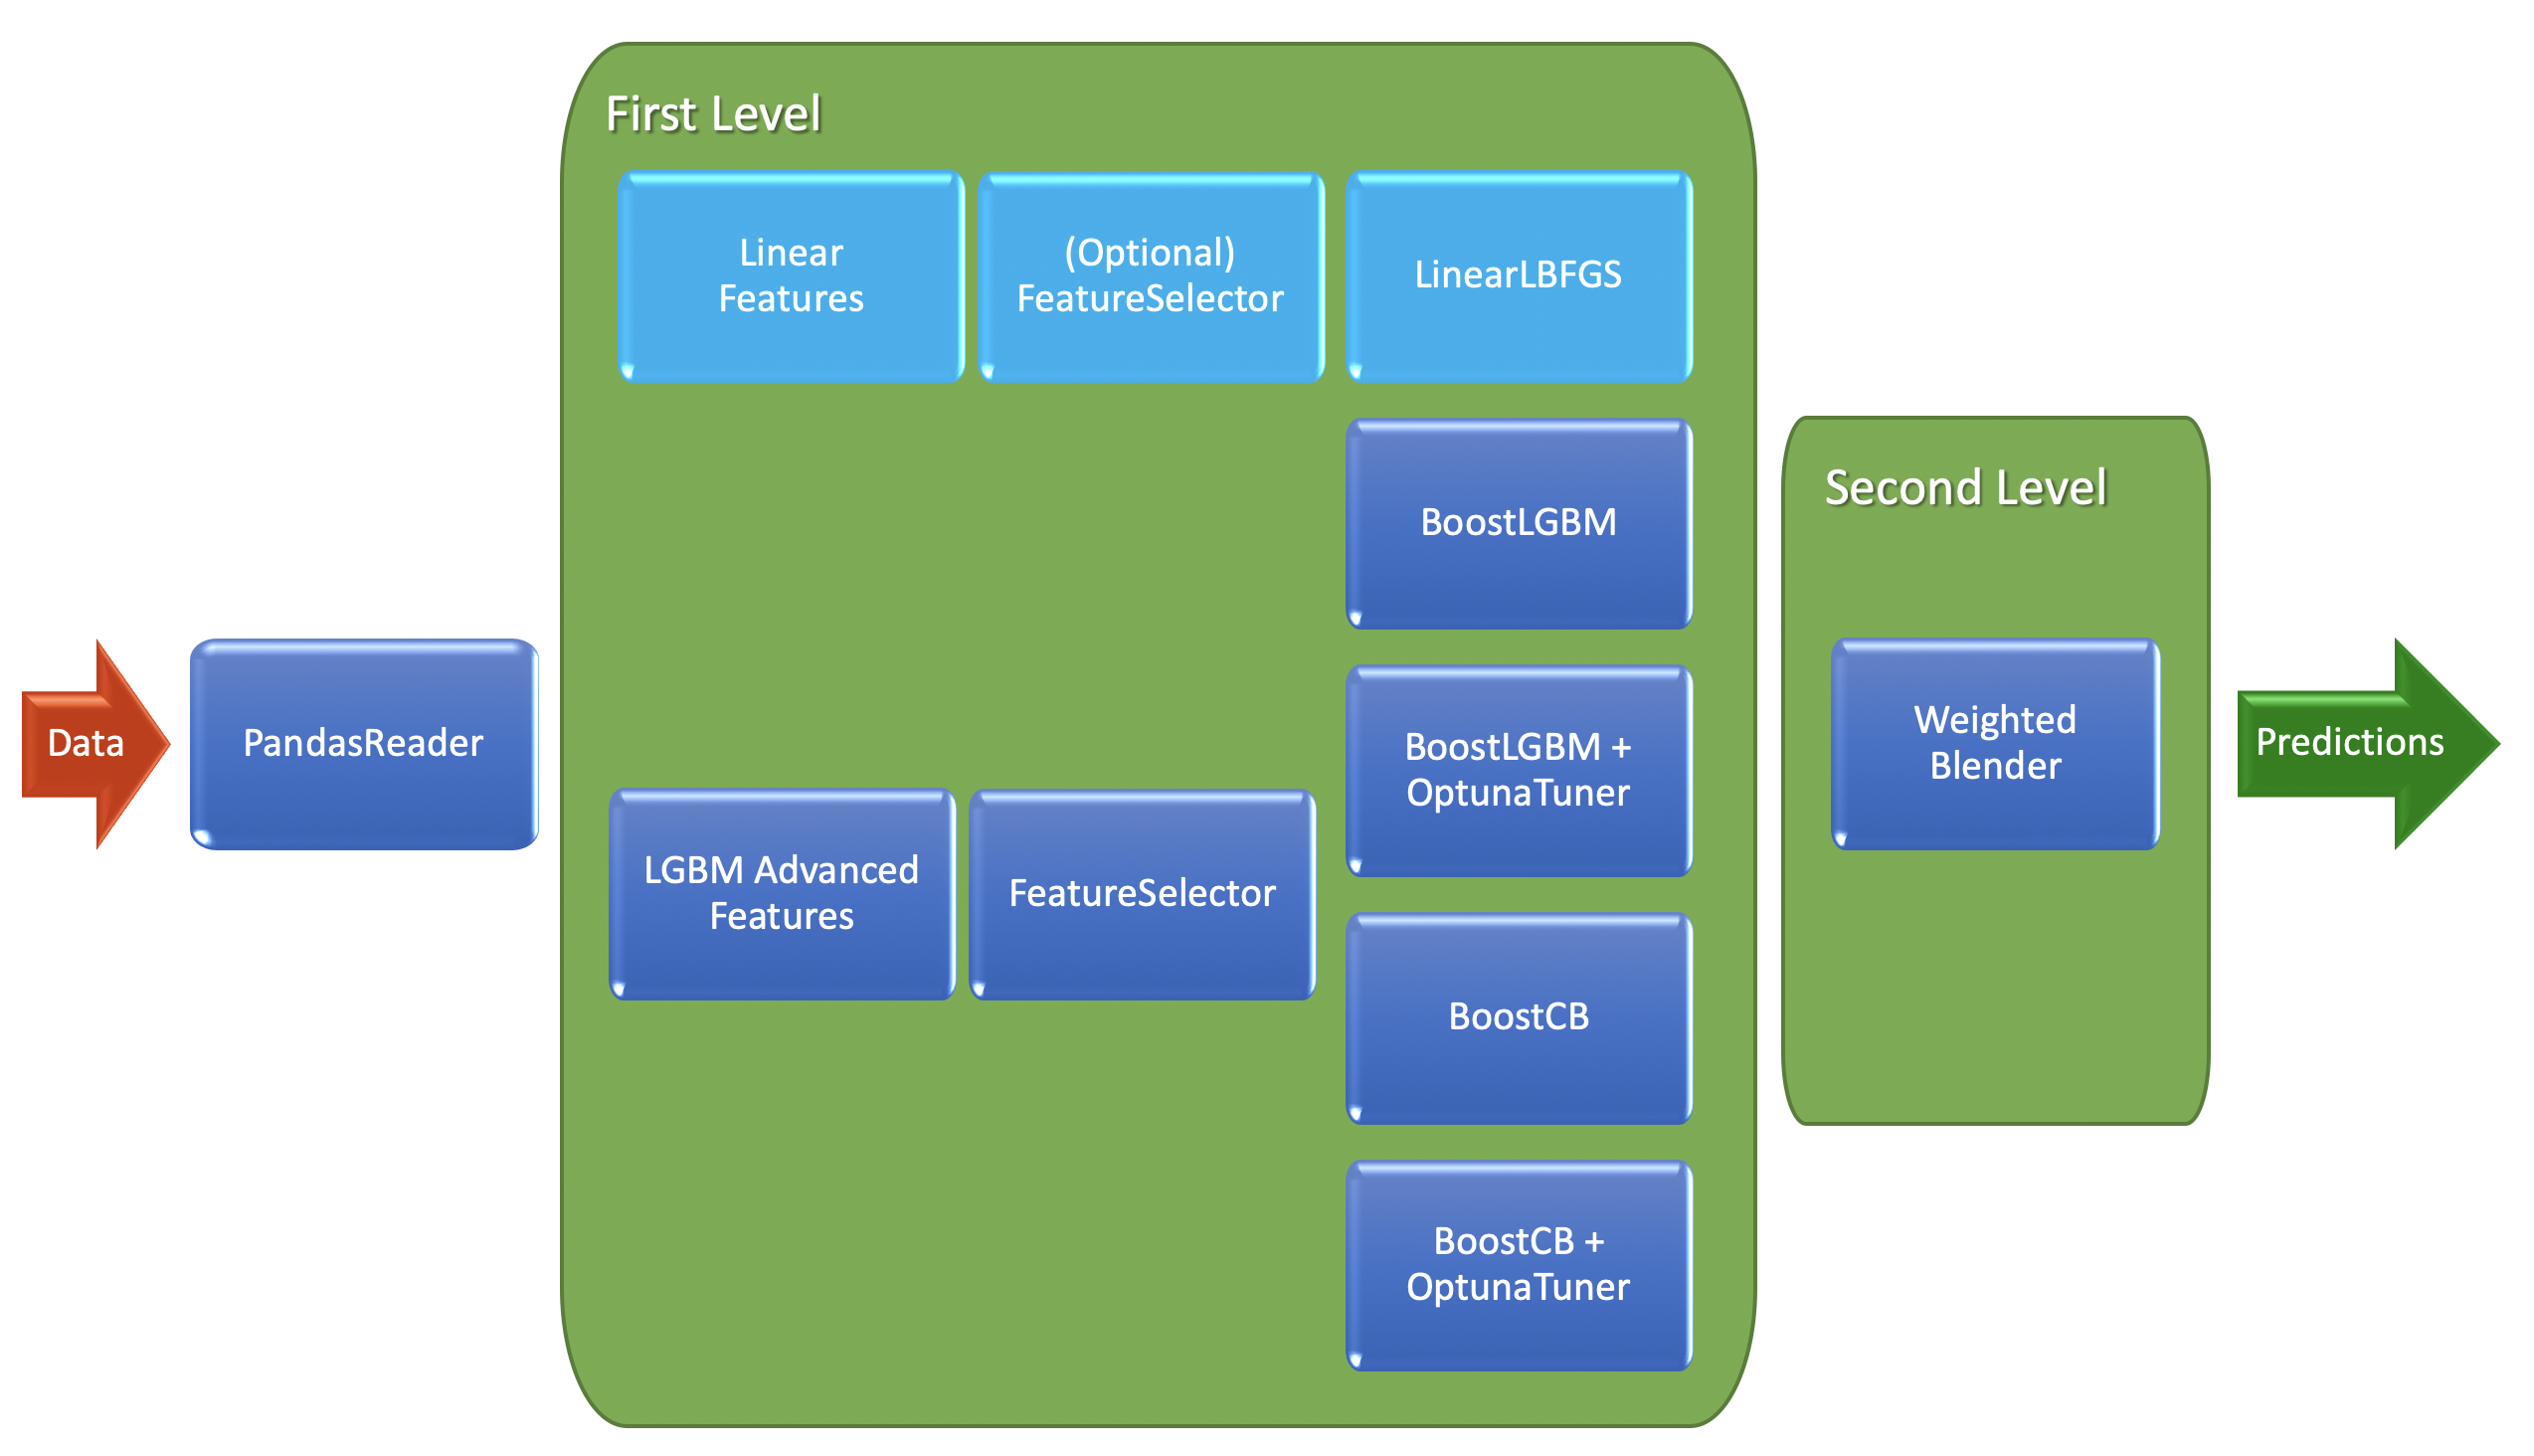

In [75]:
logging.basicConfig(format = '[%(asctime)s] (%(levelname)s): %(message)s', level = logging.INFO)

lightautoml.__version__
# Task?
# roles?

'0.3.7.3'

## Посмотрим на результат работы нескольких алгоритмов:  
- TabularAutoML со стандартными параметрами на предобработанном датасете (датасет после проведения LabelEncoding, OneHotEncoding, нормализации, логарифмирования и др.)    
- TabularAutoML со стандартными параметрами на изначальном датасете (датассет без какой-либо предобработки)  
- TabularUtilizedAutoML со стандартными параметрами на изначальном датасете (датассет без какой-либо предобработки)
- TabularAutoML с измененной конфигурацией на изначальном датасете (с признаком "Дата подачи заявления" - 'app_date')
- TabularUtilizedAutoML с измененной конфигурацией на изначальном датасете (с признаком "Дата подачи заявления" - 'app_date')

### LightAutoML (пресет TabularAutoML) со стандартными параметрами на предобработанном датасете 

**Ручная предобработка датасета включала:**
- преобразование бинарных и категориальных переменных (LabelEncoding и OneHotEncoding)  
- преобразование числовых переменных (логарифмирование и нормализация)  
- удаление неинформативных столбцов: "client_id" и "app_date"

In [76]:
# Тренировочный и валидационный датасеты (предобработанные вручную)
data_train = pd.concat([X_train.reset_index(), pd.Series(y_train, name = 'default')], axis = 1).drop('index', axis = 1)
data_valid = pd.concat([X_valid.reset_index(), pd.Series(y_valid, name = 'default')], axis = 1).drop('index', axis = 1)

print(f'Размер тренировочного датасета "data_train": {data_train.shape}')  # (59039, 38)
print(f'Кол-во пропущенных значений: {data_train.isna().sum().sum()}') 
display(data_train.head(3))
print(f'\nРазмер валидационного датасета "data_valid": {data_valid.shape}')  # (14760, 38)
print(f'Кол-во пропущенных значений: {data_valid.isna().sum().sum()}') 
display(data_valid.head(3))

Размер тренировочного датасета "data_train": (59039, 38)
Кол-во пропущенных значений: 0


sex    age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    0  0.599    0         0            0.000          1      1.285   
1    0 -0.915    0         0            0.000          0      0.641   
2    1 -0.915    0         0            0.000          0     -0.665   

   bki_request_cnt  income  foreign_passport  education_ACD  education_GRD  \
0            0.500   0.811                 1              0              1   
1           -0.500  -0.475                 0              0              0   
2            0.000   0.475                 0              0              0   

   education_PGR  education_SCH  education_UGR  education_nan  \
0              0              0              0              0   
1              0              1              0              0   
2              0              1              0              0   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 1   
1                 0                 0                 0                 1   
2                 0                 0                 0                 0   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 0               1   
1                 0                 0                 0               1   
2                 0                 0                 1               0   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               0               0               1               0   
1               0               0               0               1   
2               1               0               0               0   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               0      1      0      0      0             0             0   
1               0      1      0      0      0             0             0   
2               1      1      0      0      0             0             1   

   first_time_3  first_time_4  default  
0             1             0        0  
1             1             0        0  
2             0             0        0


Размер валидационного датасета "data_valid": (14760, 38)
Кол-во пропущенных значений: 0


sex   age  car  car_type  decline_app_cnt  good_work  score_bki  \
0    1 0.166    1         1            0.000          0     -0.112   
1    1 0.270    1         1            0.000          1     -0.881   
2    1 0.057    1         1            0.000          0      0.113   

   bki_request_cnt  income  foreign_passport  education_ACD  education_GRD  \
0           -0.500   0.811                 1              0              0   
1            0.661   1.884                 1              0              1   
2            0.500   0.475                 1              0              0   

   education_PGR  education_SCH  education_UGR  education_nan  \
0              0              1              0              0   
1              0              0              0              0   
2              0              0              1              0   

   region_rating_20  region_rating_30  region_rating_40  region_rating_50  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   region_rating_60  region_rating_70  region_rating_80  home_address_1  \
0                 0                 0                 1               0   
1                 0                 0                 1               0   
2                 0                 0                 1               0   

   home_address_2  home_address_3  work_address_1  work_address_2  \
0               1               0               0               0   
1               1               0               0               0   
2               1               0               0               0   

   work_address_3  sna_1  sna_2  sna_3  sna_4  first_time_1  first_time_2  \
0               1      1      0      0      0             0             0   
1               1      1      0      0      0             0             0   
2               1      1      0      0      0             0             0   

   first_time_3  first_time_4  default  
0             0             1        0  
1             0             1        0  
2             0             1        0

#### Зададим некоторые параметры-константы, которые будем использовать в процессе решения задачи

In [130]:
N_THREADS = 8 
N_FOLDS = 5
RANDOM_SEED = 42
TEST_SIZE = 0.2
TIMEOUT = 7200  # 2 hours
TARGET_NAME = 'default'

#### Создадим задание (бинарная классификация) и установим роли 

In [131]:
task = Task('binary', loss = 'logloss',  metric = 'auc')
roles = {'target': TARGET_NAME}

#### Воспользуемся пресетом TabularAutoML для создания модели и подготовим отчет по проведенной классификации

In [132]:
automl_model = TabularAutoML(task = task,   
                             timeout = TIMEOUT,
                             cpu_limit = N_THREADS,
                             reader_params = {'n_jobs' : N_THREADS, 'random_state' : RANDOM_SEED, 'cv' : N_FOLDS})


RD = ReportDeco(output_path = 'tabularAutoML_model_report')
automl_rd = RD(automl_model)

y_pred_oof = automl_rd.fit_predict(data_train, roles = roles, verbose = 1)

[19:53:28] Stdout logging level is INFO.


[2023-08-03 19:53:28,511] (INFO): Stdout logging level is INFO.


[19:53:28] Task: binary



[2023-08-03 19:53:28,661] (INFO): Task: binary



[19:53:28] Start automl preset with listed constraints:


[2023-08-03 19:53:28,664] (INFO): Start automl preset with listed constraints:


[19:53:28] - time: 7200.00 seconds


[2023-08-03 19:53:28,666] (INFO): - time: 7200.00 seconds


[19:53:28] - CPU: 8 cores


[2023-08-03 19:53:28,667] (INFO): - CPU: 8 cores


[19:53:28] - memory: 16 GB



[2023-08-03 19:53:28,669] (INFO): - memory: 16 GB



[19:53:28] Train data shape: (59039, 38)



[2023-08-03 19:53:28,671] (INFO): Train data shape: (59039, 38)

[2023-08-03 19:53:47,135] (INFO3): Feats was rejected during automatic roles guess: []


[19:53:47] Layer 1 train process start. Time left 7181.50 secs


[2023-08-03 19:53:47,168] (INFO): Layer 1 train process start. Time left 7181.50 secs


[19:53:47] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


[2023-08-03 19:53:47,579] (INFO): Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[2023-08-03 19:53:47,582] (DEBUG): Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [], 'embed_sizes': (), 'data_size': 37}
[2023-08-03 19:53:47,621] (INFO2): ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[2023-08-03 19:53:54,897] (INFO3): Linear model: C = 1e-05 score = 0.7077162574383504
[2023-08-03 19:53:55,883] (INFO3): Linear model: C = 5e-05 score = 0.7172703035897247
[2023-08-03 19:53:57,410] (INFO3): Linear model: C = 0.0001 score = 0.721069324775705
[2023-08-03 19:53:58,841] (INFO3): Linear model: C = 0.0005 score = 0.7251438230459974
[2023-08-03 19:53:59,862] (INFO3): Linear model: C = 0.001 score = 0.7255165615955954
[2023-08-03 19:54:00,176] (INFO3): Linear model: C = 0.005 score = 0.7256713839879414
[2

[19:54:58] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7303971590253627


[2023-08-03 19:54:58,307] (INFO): Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7303971590253627


[19:54:58] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[2023-08-03 19:54:58,317] (INFO): Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:54:58] Time left 7110.32 secs



[2023-08-03 19:54:58,345] (INFO): Time left 7110.32 secs

[2023-08-03 19:54:59,450] (INFO3): Training until validation scores don't improve for 200 rounds
[2023-08-03 19:55:12,000] (DEBUG): [100]	valid's auc: 0.720086
[2023-08-03 19:55:24,602] (DEBUG): [200]	valid's auc: 0.722853
[2023-08-03 19:55:38,050] (DEBUG): [300]	valid's auc: 0.722103
[2023-08-03 19:55:48,732] (DEBUG): Early stopping, best iteration is:
[169]	valid's auc: 0.722908


[19:55:48] Selector_LightGBM fitting and predicting completed


[2023-08-03 19:55:48,902] (INFO): Selector_LightGBM fitting and predicting completed


[19:55:49] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


[2023-08-03 19:55:49,056] (INFO): Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[2023-08-03 19:55:49,059] (DEBUG): Training params: {'task': 'train', 'learning_rate': 0.03, 'num_leaves': 64, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 4, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 1200, 'early_stopping_rounds': 200, 'random_state': 42}
[2023-08-03 19:55:49,072] (INFO2): ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
[2023-08-03 19:55:49,818] (INFO3): Training until validation scores don't improve for 200 rounds
[2023-08-03 19:56:09,183] (DEBUG): [100]	valid's auc: 0.720872
[2023-08-03 19:56:25,133] (DEBUG): [200]	valid's auc: 0.720429
[2023-08-03 19:56:42,510] (DEBUG): [300]	valid's auc: 0.718827
[2023-08-03 19:56:44,154] (DEBUG): Early stopping, best iteration is:
[112]	valid's auc: 0.721175
[2023-08

[20:01:18] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7288634593899247


[2023-08-03 20:01:18,267] (INFO): Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.7288634593899247


[20:01:18] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[2023-08-03 20:01:18,301] (INFO): Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[20:01:18] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs


[2023-08-03 20:01:18,305] (INFO): Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 300.00 secs
[2023-08-03 20:01:18,323] (INFO): A new study created in memory with name: no-name-f7a68fd8-a637-46db-9465-55a61a2080b3
[2023-08-03 20:01:20,458] (INFO3): Training until validation scores don't improve for 200 rounds
[2023-08-03 20:02:03,797] (DEBUG): [100]	valid's auc: 0.715131
[2023-08-03 20:02:55,847] (DEBUG): [200]	valid's auc: 0.711043
[2023-08-03 20:03:18,036] (DEBUG): Early stopping, best iteration is:
[61]	valid's auc: 0.715308
[2023-08-03 20:03:18,340] (INFO): Trial 0 finished with value: 0.7153075374529443 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: 0.7153075374529443.
[2023-08-03 20:03:18,348] (INFO3): Trial 1 with hype

[20:06:28] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[2023-08-03 20:06:28,124] (INFO): Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[2023-08-03 20:06:28,128] (INFO2): The set of hyperparameters {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}
 achieve 0.7219 auc


[20:06:28] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[2023-08-03 20:06:28,134] (INFO): Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[2023-08-03 20:06:28,139] (DEBUG): Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 66, 'feature_fraction': 0.9162213204002109, 'bagging_fraction': 0.5909124836035503, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 4, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'min_sum_hessian_in_leaf': 0.00541524411940254}
[2023-08-03 20:06:28,166] (INFO2): ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[2023-08-03 20:06:28,814] (INFO3): Training until validation scores don't improve for 100 rounds
[2023-08-03 20:06:52,137] (DEBUG): [100]	valid's auc: 0.723448
[2023-08-03 20:07:06,083] (DEBUG): Early stopping, best iteration is:
[85]	valid's auc: 0.724556
[2023-08-

[20:09:15] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7273481306144622


[2023-08-03 20:09:15,869] (INFO): Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.7273481306144622


[20:09:15] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[2023-08-03 20:09:15,874] (INFO): Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[20:09:15] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


[2023-08-03 20:09:15,937] (INFO): Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[2023-08-03 20:09:15,940] (DEBUG): Training params: {'task_type': 'CPU', 'thread_count': 4, 'random_seed': 42, 'num_trees': 2000, 'learning_rate': 0.05, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
[2023-08-03 20:09:15,954] (INFO2): ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
[2023-08-03 20:09:16,512] (INFO3): 0:	test: 0.6027441	best: 0.6027441 (0)	total: 57.7ms	remaining: 1m 55s
[2023-08-03 20:09:21,710] (DEBUG): 100:	test: 0.7226903	best: 0.7226903 (100)	total: 5.25s	remaining: 1m 38s
[2023-08-03 20:09:26,509] (DEBUG): 200:	test: 0.7259037	best: 0

[20:10:46] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7322391666900286


[2023-08-03 20:10:46,506] (INFO): Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.7322391666900286


[20:10:46] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[2023-08-03 20:10:46,508] (INFO): Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[20:10:46] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


[2023-08-03 20:10:46,513] (INFO): Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs
[2023-08-03 20:10:46,535] (INFO): A new study created in memory with name: no-name-44731a90-2f58-45a3-b4d4-785e3d05b3f0
[2023-08-03 20:10:47,013] (INFO3): 0:	test: 0.6001394	best: 0.6001394 (0)	total: 41ms	remaining: 3m 24s
[2023-08-03 20:10:50,841] (DEBUG): 100:	test: 0.7167586	best: 0.7167586 (100)	total: 3.86s	remaining: 3m 7s
[2023-08-03 20:10:55,659] (DEBUG): 200:	test: 0.7227307	best: 0.7227520 (199)	total: 8.66s	remaining: 3m 26s
[2023-08-03 20:11:00,118] (DEBUG): 300:	test: 0.7252058	best: 0.7252579 (295)	total: 13.1s	remaining: 3m 24s
[2023-08-03 20:11:04,155] (DEBUG): 400:	test: 0.7266141	best: 0.7266412 (397)	total: 17.2s	remaining: 3m 16s
[2023-08-03 20:11:08,465] (DEBUG): 500:	test: 0.7273563	best: 0.7273773 (499)	total: 21.5s	remaining: 3m 12s
[2023-08-03 20:11:13,025] (DEBUG): 600:	test: 0.7274930	best: 0.7275622 (585)	total: 26s	remai

[20:15:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[2023-08-03 20:15:54,087] (INFO): Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[2023-08-03 20:15:54,091] (INFO2): The set of hyperparameters {'max_depth': 5, 'l2_leaf_reg': 0.1165691561324743, 'min_data_in_leaf': 4}
 achieve 0.7286 auc


[20:15:54] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[2023-08-03 20:15:54,094] (INFO): Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
[2023-08-03 20:15:54,098] (DEBUG): Training params: {'task_type': 'CPU', 'thread_count': 4, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.1165691561324743, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 4, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False}
[2023-08-03 20:15:54,143] (INFO2): ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
[2023-08-03 20:15:54,556] (INFO3): 0:	test: 0.6027442	best: 0.6027442 (0)	total: 32ms	remaining: 1m 36s
[2023-08-03 20:15:59,112] (DEBUG): 100:	test: 0.7175572	best: 0.7175780 (99)	total: 4.58s	remaining: 2m 11s
[2023-08-03 20:16:03,681] (DEBUG): 200:	

[20:18:10] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.732812904470405


[2023-08-03 20:18:10,135] (INFO): Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.732812904470405


[20:18:10] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[2023-08-03 20:18:10,137] (INFO): Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[20:18:10] Time left 5718.53 secs



[2023-08-03 20:18:10,144] (INFO): Time left 5718.53 secs



[20:18:10] Layer 1 training completed.



[2023-08-03 20:18:10,149] (INFO): Layer 1 training completed.



[20:18:10] Blending: optimization starts with equal weights and score 0.7333093718183343


[2023-08-03 20:18:10,219] (INFO): Blending: optimization starts with equal weights and score 0.7333093718183343


[20:18:11] Blending: iteration 0: score = 0.7336364103877318, weights = [0.28410703 0.05218407 0.09726224 0.3269443  0.23950236]


[2023-08-03 20:18:11,898] (INFO): Blending: iteration 0: score = 0.7336364103877318, weights = [0.28410703 0.05218407 0.09726224 0.3269443  0.23950236]


[20:18:13] Blending: iteration 1: score = 0.7336530087230106, weights = [0.26594332 0.05408863 0.11054211 0.25422046 0.31520545]


[2023-08-03 20:18:13,539] (INFO): Blending: iteration 1: score = 0.7336530087230106, weights = [0.26594332 0.05408863 0.11054211 0.25422046 0.31520545]


[20:18:15] Blending: iteration 2: score = 0.7336530087230106, weights = [0.26594332 0.05408863 0.11054211 0.25422046 0.31520545]


[2023-08-03 20:18:15,105] (INFO): Blending: iteration 2: score = 0.7336530087230106, weights = [0.26594332 0.05408863 0.11054211 0.25422046 0.31520545]


[20:18:15] Blending: no score update. Terminated



[2023-08-03 20:18:15,107] (INFO): Blending: no score update. Terminated



[20:18:15] Automl preset training completed in 1486.45 seconds



[2023-08-03 20:18:15,116] (INFO): Automl preset training completed in 1486.45 seconds



[20:18:15] Model description:
Final prediction for new objects (level 0) = 
	 0.26594 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05409 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.11054 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.25422 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31521 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



[2023-08-03 20:18:15,117] (INFO): Model description:
Final prediction for new objects (level 0) = 
	 0.26594 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05409 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.11054 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.25422 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31521 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 



In [133]:
# logging.info(f'y_pred_oof:\n{y_pred_oof}\nShape = {y_pred_oof.shape}')
print(f'y_pred_oof:\n{y_pred_oof}\nShape = {y_pred_oof.shape}')  # (59039, 1)

y_pred_oof:
array([[0.08281517],
       [0.12311808],
       [0.067216  ],
       ...,
       [0.13818441],
       [0.32517633],
       [0.09114489]], dtype=float32)
Shape = (59039, 1)


In [136]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_valid = automl_rd.predict(data_valid)
print(f'Prediction for data_valid:\n{y_pred_valid}\nShape = {y_pred_valid.shape}')

# logging.info(f'OOF score: {roc_auc_score(data_train["default"].values, y_pred_oof.data[:, 0])}')
# logging.info(f'HOLDOUT score: {roc_auc_score(data_valid["default"].values, y_pred_valid.data[:, 0])}')
print(f'\nOOF roc_auc_score: {roc_auc_score(data_train["default"].values, y_pred_oof.data[:, 0])}')
print(f'HOLDOUT roc_auc_score: {roc_auc_score(data_valid["default"].values, y_pred_valid.data[:, 0])}')

Prediction for data_valid:
array([[0.03729511],
       [0.01851373],
       [0.06128031],
       ...,
       [0.15811548],
       [0.09696986],
       [0.07022997]], dtype=float32)
Shape = (14760, 1)

OOF roc_auc_score: 0.7336530087230106
HOLDOUT roc_auc_score: 0.7388224312007224


In [137]:
print(type(y_pred_oof), y_pred_oof.shape)
print(type(y_pred_valid))
print()
print(type(y_pred_oof.data[:, 0]), y_pred_oof.data[:, 0].shape)
print(type(y_pred_valid.data[:, 0]))
y_pred_oof.data[:, 0]

<class 'lightautoml.dataset.np_pd_dataset.NumpyDataset'> (59039, 1)
<class 'lightautoml.dataset.np_pd_dataset.NumpyDataset'>

<class 'numpy.ndarray'> (59039,)
<class 'numpy.ndarray'>


array([0.08281517, 0.12311808, 0.067216  , ..., 0.13818441, 0.32517633,
       0.09114489], dtype=float32)

In [138]:
# Посмотрим на соотношение классов в целевой переменной
print(f'Соотношение классов в "data_valid": \n{data_valid["default"].value_counts()}')
round(1874 / 12886, 5)

Соотношение классов в "data_valid": 
0    12886
1     1874
Name: default, dtype: int64


0.14543

In [139]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(data_valid["default"].values, y_pred_valid.data[:, 0])  

'threshold: 0.16312000000000001, f1_score: 0.35938566552901025'

Метрики качества классификации:
 - Accuracy: 0.7457
 - Precision: 0.2642
 - Recall: 0.5619
 - F1_score: 0.3594
 - Roc_auc_score: 0.7388


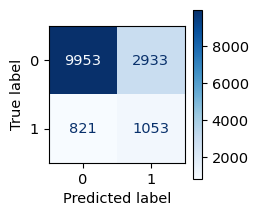

In [142]:
# threshold = 0.16312
y_pred_th = np.where(y_pred_valid.data[:, 0] >= 0.16312, 1, 0)

plt.style.use('default')
plt.rcParams.update({'font.size': 10.5, 'figure.figsize' : (2.2, 2.2)})

get_classification_metrics(data_valid["default"].values, y_pred_th, y_pred_valid.data[:, 0])
get_confusion_matrix(data_valid["default"].values, y_pred_th)

In [145]:
f1 = f1_score(data_valid["default"].values, y_pred_th)
roc_auc = roc_auc_score(data_valid["default"].values, y_pred_valid.data[:, 0])
print(f'threshold = 0.16312 \nHOLDOUT f1: {round(f1,7)} \nHOLDOUT roc_auc: {round(roc_auc,7)}')

threshold = 0.16312 
HOLDOUT f1: 0.3593857 
HOLDOUT roc_auc: 0.7388224


Feature  Importance
0          score_bki  24,357.138
1             income   5,696.568
2    decline_app_cnt   5,366.837
3                age   5,104.359
4    bki_request_cnt   4,414.975
5              sna_1   3,859.949
6   region_rating_80   3,668.245
7     home_address_2   3,158.603
8              sna_4   2,428.290
9      education_GRD   1,940.306
10    home_address_1   1,940.058
11     education_SCH   1,904.698
12  region_rating_40   1,762.157
13               sex   1,516.838
14  region_rating_70   1,258.677

<AxesSubplot:xlabel='Feature'>

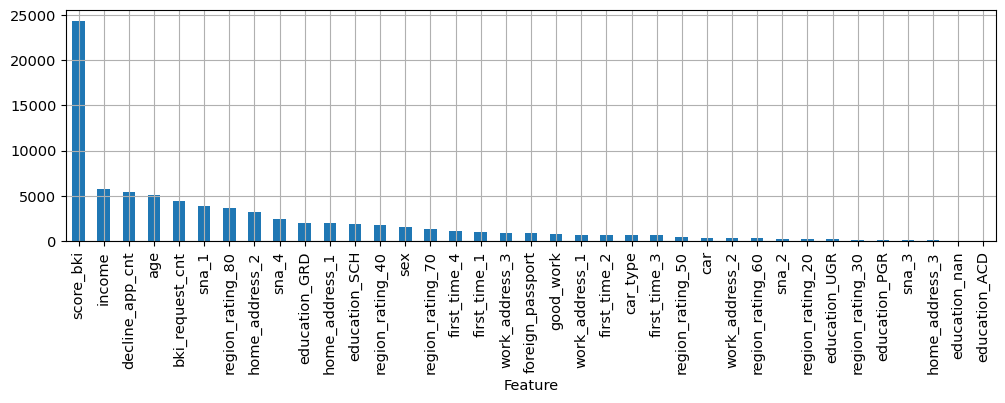

In [146]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp = automl_rd.model.get_feature_scores('fast')
display(fast_features_imp.sort_values('Importance', ascending = False)[:15])
fast_features_imp.set_index('Feature')['Importance'].plot.bar(figsize = (12, 3), fontsize = 10.5, grid = True)

Feature  Importance
0         score_bki       0.065
1  region_rating_80       0.015
2   bki_request_cnt       0.007
3               sex       0.007
4   decline_app_cnt       0.006
5    home_address_2       0.005
6             sna_1       0.004
7             sna_4       0.004
8  region_rating_40       0.004
9          car_type       0.003

<AxesSubplot:xlabel='Feature'>

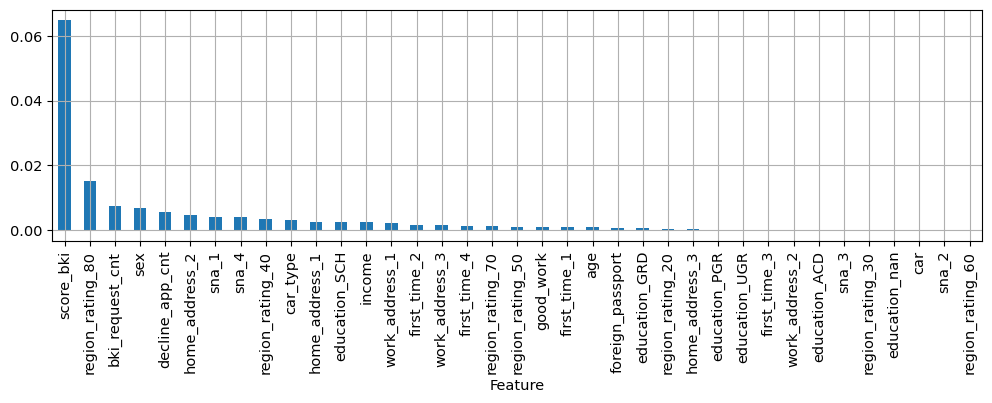

In [147]:
# Посмотрим на график важности признаков (Более точный способ - Permutation importances) 
accurate_features_imp = automl_rd.model.get_feature_scores('accurate', data_valid, silent = True)
display(accurate_features_imp.sort_values('Importance', ascending = False)[:10])
accurate_features_imp.set_index('Feature')['Importance'].plot.bar(figsize = (12, 3), fontsize = 10.5, grid = True)

In [148]:
accurate_features_imp

Feature  Importance
0          score_bki       0.065
1   region_rating_80       0.015
2    bki_request_cnt       0.007
3                sex       0.007
4    decline_app_cnt       0.006
5     home_address_2       0.005
6              sna_1       0.004
7              sna_4       0.004
8   region_rating_40       0.004
9           car_type       0.003
10    home_address_1       0.003
11     education_SCH       0.002
12            income       0.002
13    work_address_1       0.002
14      first_time_2       0.002
15    work_address_3       0.001
16      first_time_4       0.001
17  region_rating_70       0.001
18  region_rating_50       0.001
19         good_work       0.001
20      first_time_1       0.001
21               age       0.001
22  foreign_passport       0.001
23     education_GRD       0.001
24  region_rating_20       0.000
25    home_address_3       0.000
26     education_PGR       0.000
27     education_UGR       0.000
28      first_time_3       0.000
29    work_address_2       0.000
30     education_ACD       0.000
31             sna_3       0.000
32  region_rating_30       0.000
33     education_nan       0.000
34               car       0.000
35             sna_2      -0.000
36  region_rating_60      -0.000

In [149]:
# Краткое описание получившейся модели
print(automl_model.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.26594 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.05409 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.11054 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.25422 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.31521 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [150]:
# LAMA report 
os.listdir('tabularAutoML_model_report')

['feature_importance.png',
 'lama_interactive_report.html',
 'test_distribution_of_logits_1.png',
 'test_distribution_of_logits_2.png',
 'test_distribution_of_logits_3.png',
 'test_pie_f1_metric_1.png',
 'test_pie_f1_metric_2.png',
 'test_pie_f1_metric_3.png',
 'test_preds_distribution_by_bins_1.png',
 'test_preds_distribution_by_bins_2.png',
 'test_preds_distribution_by_bins_3.png',
 'test_pr_curve_1.png',
 'test_pr_curve_2.png',
 'test_pr_curve_3.png',
 'test_roc_curve_1.png',
 'test_roc_curve_2.png',
 'test_roc_curve_3.png',
 'valid_distribution_of_logits.png',
 'valid_pie_f1_metric.png',
 'valid_preds_distribution_by_bins.png',
 'valid_pr_curve.png',
 'valid_roc_curve.png']

In [151]:
# Сохранение модели
joblib.dump(automl_model, 'automl_model.pkl')

#Загрузка модели
#automl_model=joblib.load('automl_model.pkl')

['automl_model.pkl']

### LightAutoML (пресет TabularAutoML) со стандартными параметрами на изначальном датасете  
- Датасет без какой-либо предобработки  
- В алгоритм переданы списки категориальных, числовых переменных и переменная "Дата подачи заявления"   
- Удален признак 'client_id' 

In [152]:
# Загрузим изначальный датасет и разделим выборки для обучения и валидации
train_credit = pd.read_csv('train_credit_scoring.csv')
data_tr, data_val = train_test_split(train_credit, stratify = train_credit['default'], 
                                     test_size = 0.2, random_state = RANDOM_SEED)

# Тренировочный и валидационный датасеты
print(f'Размер тренировочного датасета "data_tr": {data_tr.shape}')      # (59039, 19)
print(f'Пропущенные значения: \n{data_tr.isna().sum()[data_tr.isna().sum() > 0]}')
display(data_tr.head(3))
    
print(f'\nРазмер валидационного датасета "data_val": {data_val.shape}')  # (14760, 19)
print(f'Пропущенные значения: \n{data_val.isna().sum()[data_val.isna().sum() > 0]}')
display(data_val.head(3))

Размер тренировочного датасета "data_tr": (59039, 19)
Пропущенные значения: 
education    245
dtype: int64


client_id   app_date education sex  age car car_type  decline_app_cnt  \
19791      61880  11MAR2014       GRD   F   49   N        N                0   
49335      67734  16MAR2014       SCH   F   24   N        N                0   
41747      38743  14FEB2014       SCH   M   24   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
19791          1     -1.035                3             50             1   
49335          0     -1.479                0             50             1   
41747          0     -2.379                1             80             2   

       work_address  income  sna  first_time foreign_passport  default  
19791             1   60000    1           3                Y        0  
49335             2   20000    1           3                N        0  
41747             3   45000    1           2                N        0


Размер валидационного датасета "data_val": (14760, 19)
Пропущенные значения: 
education    62
dtype: int64


client_id   app_date education sex  age car car_type  decline_app_cnt  \
60889     101456  18APR2014       SCH   M   40   Y        Y                0   
46372      94164  10APR2014       GRD   M   42   Y        Y                0   
42779      42286  18FEB2014       UGR   M   38   Y        Y                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
60889          0     -1.998                0             80             2   
46372          1     -2.528                4             80             2   
42779          0     -1.843                3             80             2   

       work_address  income  sna  first_time foreign_passport  default  
60889             3   60000    1           4                Y        0  
46372             3  150000    1           4                Y        0  
42779             3   45000    1           4                Y        0

In [153]:
# Создадим Task (бинарная классификация) и установим роли для признаков
task = Task('binary', loss = 'logloss',  metric = 'auc')

roles = {'target': TARGET_NAME,
         'drop': ['client_id'],
         'numeric' : num_cols_list,
         'category' : bin_cols_list + cat_cols_list,
          DatetimeRole(base_date = False, seasonality = ('d', 'm', 'y', 'wd')) : 'app_date'}


# Воспользуемся пресетом TabularAutoML для создания модели
automl_model_1 = TabularAutoML(task = task,             
                               timeout = TIMEOUT,       # 2 hours
                               cpu_limit = N_THREADS,   # 8
                               reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  

RD_1 = ReportDeco(output_path = 'tabularAutoML_model_report_1')
automl_rd_1 = RD_1(automl_model_1)

y_pred_oof1 = automl_rd_1.fit_predict(data_tr, roles = roles, verbose = -1)

[2023-08-03 20:48:27,267] (INFO): Stdout logging level is ERROR.
[2023-08-03 20:48:27,470] (INFO): Task: binary

[2023-08-03 20:48:27,470] (INFO): Start automl preset with listed constraints:
[2023-08-03 20:48:27,471] (INFO): - time: 7200.00 seconds
[2023-08-03 20:48:27,472] (INFO): - CPU: 8 cores
[2023-08-03 20:48:27,472] (INFO): - memory: 16 GB

[2023-08-03 20:48:27,473] (INFO): Train data shape: (59039, 19)

[2023-08-03 20:48:43,899] (INFO3): Feats was rejected during automatic roles guess: []
[2023-08-03 20:48:43,997] (INFO): Layer 1 train process start. Time left 7183.48 secs
[2023-08-03 20:48:54,426] (INFO): Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[2023-08-03 20:48:54,427] (DEBUG): Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], 'embed_sizes': arr

In [154]:
# Краткое описание получившейся модели
print(automl_model_1.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.22005 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
	 0.16844 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.37223 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.23929 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [155]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_valid1 = automl_rd_1.predict(data_val)

print(f'Размер oof prediction: {y_pred_oof1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_oof1.data))}')
print(f'Размер holdout prediction: {y_pred_valid1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_valid1.data))}')

print(f'\nOOF roc_auc_score: {roc_auc_score(data_tr["default"].values, y_pred_oof1.data[:, 0])}')
print(f'HOLDOUT roc_auc_score: {roc_auc_score(data_val["default"].values, y_pred_valid1.data[:, 0])}')

Размер oof prediction: (59039, 1),  NaN-значения: [False]
Размер holdout prediction: (14760, 1),  NaN-значения: [False]

OOF roc_auc_score: 0.7381534786852921
HOLDOUT roc_auc_score: 0.74049885946725


In [156]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(data_val["default"], y_pred_valid1.data[:, 0])  

'threshold: 0.18192000000000003, f1_score: 0.36030121645105234'

Метрики качества классификации:
 - Accuracy: 0.7755
 - Precision: 0.2823
 - Recall: 0.4979
 - F1_score: 0.3603
 - Roc_auc_score: 0.7405


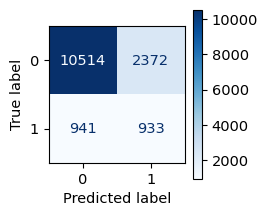

In [187]:
# threshold = 0.18192
y_pred_th = np.where(y_pred_valid1.data[:, 0] >= 0.18192 , 1, 0)

plt.style.use('default')
plt.rcParams.update({'font.size': 10.5, 'figure.figsize' : (2.2, 2.2)})

get_classification_metrics(data_val["default"].values, y_pred_th, y_pred_valid1.data[:, 0])
get_confusion_matrix(data_val["default"].values, y_pred_th)

In [189]:
f1 = f1_score(data_val["default"].values, y_pred_th)
roc_auc = roc_auc_score(data_val["default"].values, y_pred_valid1.data[:, 0])
print(f'threshold = 0.18192\nHOLDOUT f1: {round(f1, 7)} \nHOLDOUT roc_auc: {round(roc_auc, 7)}')

threshold = 0.18192
HOLDOUT f1: 0.3603012 
HOLDOUT roc_auc: 0.7404989


Feature  Importance
0          score_bki  25,284.465
1           app_date   9,148.337
2      region_rating   7,440.575
3             income   6,432.255
4                sna   6,323.656
5                age   5,809.977
6       home_address   5,689.376
7    decline_app_cnt   5,429.610
8    bki_request_cnt   5,042.333
9          education   4,059.609
10        first_time   3,360.589
11      work_address   2,040.344
12               sex   1,530.888
13  foreign_passport     866.727
14         good_work     724.257

<AxesSubplot:xlabel='Feature'>

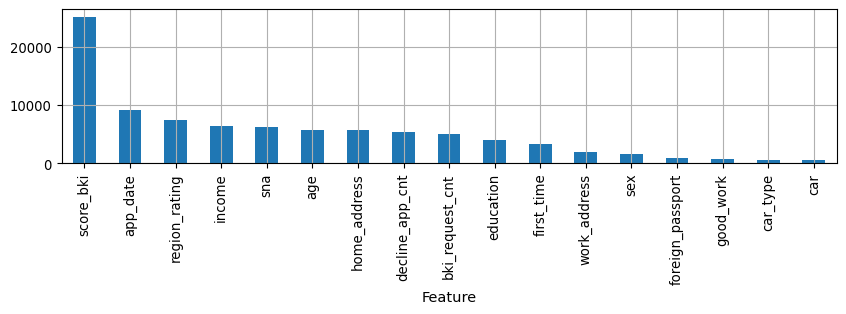

In [173]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp_1 = automl_rd_1.model.get_feature_scores('fast')
display(fast_features_imp_1.sort_values('Importance', ascending = False)[:15])
fast_features_imp_1.set_index('Feature')['Importance'].plot.bar(figsize = (10, 2), fontsize = 9.5, grid = True)

Feature  Importance
0         score_bki       0.064
1     region_rating       0.029
2      home_address       0.020
3               sna       0.014
4          app_date       0.009
5        first_time       0.008
6      work_address       0.008
7               sex       0.008
8         education       0.007
9   decline_app_cnt       0.006
10  bki_request_cnt       0.006
11         car_type       0.002
12              age       0.001
13        good_work       0.000
14              car       0.000

<AxesSubplot:xlabel='Feature'>

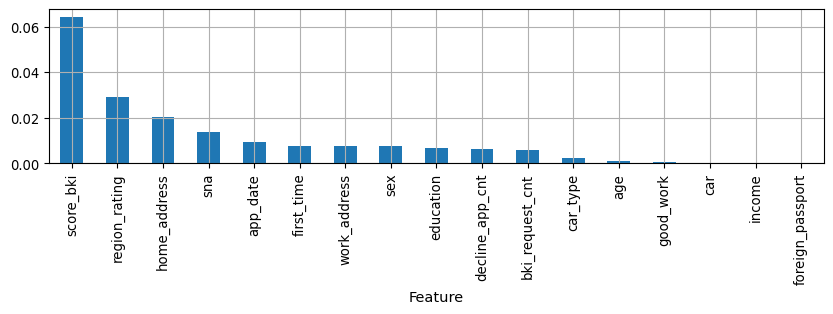

In [174]:
# Посмотрим на график важности признаков (Более точный способ - Permutation importances) 
accurate_features_imp_1 = automl_rd_1.model.get_feature_scores('accurate', data_val, silent = True)
display(accurate_features_imp_1.sort_values('Importance', ascending = False)[:15])
accurate_features_imp_1.set_index('Feature')['Importance'].plot.bar(figsize = (10, 2), fontsize = 9.5, grid = True)

In [175]:
# LAMA report 
os.listdir('tabularAutoML_model_report_1')

['feature_importance.png',
 'lama_interactive_report.html',
 'test_distribution_of_logits_1.png',
 'test_pie_f1_metric_1.png',
 'test_preds_distribution_by_bins_1.png',
 'test_pr_curve_1.png',
 'test_roc_curve_1.png',
 'valid_distribution_of_logits.png',
 'valid_pie_f1_metric.png',
 'valid_preds_distribution_by_bins.png',
 'valid_pr_curve.png',
 'valid_roc_curve.png']

In [176]:
# Сохранение модели
joblib.dump(automl_model_1, 'automl_model_1.pkl')

# Загрузка модели
# automl_model_1 = joblib.load('automl_model_1.pkl')

['automl_model_1.pkl']

### LightAutoML (пресет TabularUtilizedAutoML) со стандартными параметрами на изначальном датасете 
- Датасет без какой-либо предобработки  
- В алгоритм переданы списки категориальных, числовых переменных и переменная "Дата подачи заявления"    
- Удален признак 'client_id'

In [213]:
print(f'Размер тренировочного датасета "data_tr": {data_tr.shape}')      # (59039, 19)
print(f'Размер валидационного датасета "data_val": {data_val.shape}')    # (14760, 19)
data_tr.head(3)

Размер тренировочного датасета "data_tr": (59039, 19)
Размер валидационного датасета "data_val": (14760, 19)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
19791      61880  11MAR2014       GRD   F   49   N        N                0   
49335      67734  16MAR2014       SCH   F   24   N        N                0   
41747      38743  14FEB2014       SCH   M   24   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
19791          1     -1.035                3             50             1   
49335          0     -1.479                0             50             1   
41747          0     -2.379                1             80             2   

       work_address  income  sna  first_time foreign_passport  default  
19791             1   60000    1           3                Y        0  
49335             2   20000    1           3                N        0  
41747             3   45000    1           2                N        0

In [201]:
# Создадим Task (бинарная классификация) и установим роли для признаков
task = Task('binary', loss = 'logloss',  metric = 'auc')
roles = {'target': TARGET_NAME,
         'drop': ['client_id'],
         'numeric' : num_cols_list,
         'category' : bin_cols_list + cat_cols_list,
          DatetimeRole(base_date = False, seasonality = ('d', 'm', 'y', 'wd')) : 'app_date'}


# Воспользуемся пресетом TabularAutoML для создания модели
automl_utilized = TabularUtilizedAutoML(task = task,    # 'binary', loss = 'logloss',  metric = 'auc' 
                               timeout = 10800,         # 3 hours
                               cpu_limit = N_THREADS,   # 8
                               reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS})  

y_pred_oof_ut = automl_utilized.fit_predict(data_tr, roles = roles, verbose = -1)

[2023-08-03 23:22:12,616] (INFO): Start automl utilizator with listed constraints:
[2023-08-03 23:22:12,617] (INFO): - time: 10800.00 seconds
[2023-08-03 23:22:12,617] (INFO): - CPU: 8 cores
[2023-08-03 23:22:12,619] (INFO): - memory: 16 GB

[2023-08-03 23:22:12,619] (INFO): If one preset completes earlier, next preset configuration will be started

[2023-08-03 23:22:12,621] (INFO): ==================================================
[2023-08-03 23:22:12,622] (INFO): Start 0 automl preset configuration:
[2023-08-03 23:22:12,623] (INFO): C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[2023-08-03 23:22:12,624] (INFO3): Found reader_params in kwargs, need to combine
[2023-08-03 23:22:12,625] (INFO3): Merged variant for reader_params = {'n_jobs': 8, 'random_state': 42, 'cv': 5}
[2023-08-03 23:22:12,665] (INFO): Stdout logging

In [202]:
# Краткое описание получившейся модели
print(automl_utilized.create_model_str_desc())

Final prediction for new objects = 
	0.11336 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.23001 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.11143 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.09488 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.33457 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.22910 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.13734 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.20864 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) +
			 0.15143 * (5 aver

In [203]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_valid_ut = automl_utilized.predict(data_val)

print(f'Размер oof prediction: {y_pred_oof_ut.shape},  NaN-значения: {np.unique(np.isnan(y_pred_oof_ut.data))}')
print(f'Размер holdout prediction: {y_pred_valid_ut.shape},  NaN-значения: {np.unique(np.isnan(y_pred_valid_ut.data))}')

print(f'\nOOF roc_auc_score: {roc_auc_score(data_tr["default"].values, y_pred_oof_ut.data[:, 0])}')
print(f'HOLDOUT roc_auc_score: {roc_auc_score(data_val["default"].values, y_pred_valid_ut.data[:, 0])}')

Размер oof prediction: (59039, 1),  NaN-значения: [False]
Размер holdout prediction: (14760, 1),  NaN-значения: [False]

OOF roc_auc_score: 0.7395374206848891
HOLDOUT roc_auc_score: 0.7415471292382374


In [204]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(data_val["default"].values, y_pred_valid_ut.data[:, 0])  

'threshold: 0.18122000000000002, f1_score: 0.36127783155856724'

Метрики качества классификации:
 - Accuracy: 0.7765
 - Precision: 0.2835
 - Recall: 0.4979
 - F1_score: 0.3613
 - Roc_auc_score: 0.7415


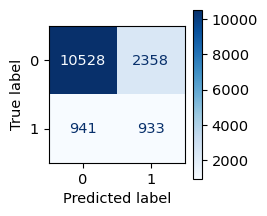

In [205]:
# threshold = 0.18122
y_pred_th = np.where(y_pred_valid_ut.data[:, 0] >= 0.18122, 1, 0)

get_classification_metrics(data_val["default"].values, y_pred_th, y_pred_valid_ut.data[:, 0])
get_confusion_matrix(data_val["default"].values, y_pred_th)

In [207]:
f1 = f1_score(data_val["default"].values, y_pred_th)
roc_auc = roc_auc_score(data_val["default"].values, y_pred_valid_ut.data[:, 0])
print(f'threshold = 0.18122\nHOLDOUT f1: {round(f1, 7)} \nHOLDOUT roc_auc: {round(roc_auc, 7)}')

threshold = 0.18122
HOLDOUT f1: 0.3612778 
HOLDOUT roc_auc: 0.7415471


Feature  Importance
0          score_bki  25,405.265
1           app_date  10,167.071
2      region_rating   7,674.304
3             income   7,100.008
4                sna   6,899.974
5                age   6,164.631
6       home_address   5,493.956
7    bki_request_cnt   5,361.838
8    decline_app_cnt   4,755.888
9          education   3,820.162
10        first_time   3,126.511
11      work_address   2,226.040
12               sex   1,551.322
13         good_work     917.204
14  foreign_passport     903.081

<AxesSubplot:xlabel='Feature'>

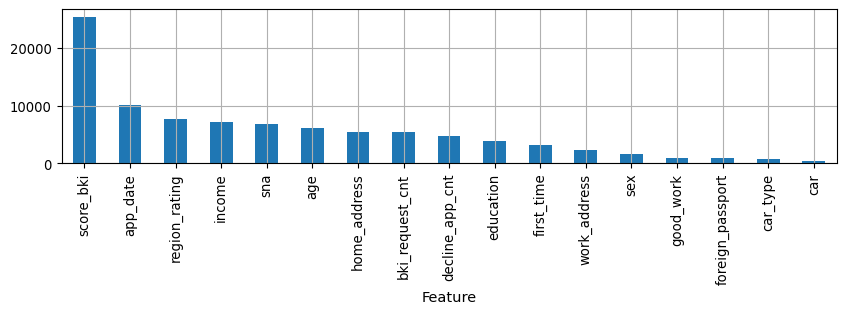

In [208]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp_ut = automl_utilized.get_feature_scores('fast')
display(fast_features_imp_ut.sort_values('Importance', ascending = False)[:15])
fast_features_imp_ut.set_index('Feature')['Importance'].plot.bar(figsize = (10, 2), fontsize = 9.5, grid = True)

In [209]:
# Сохранение модели
joblib.dump(automl_utilized, 'automl_utilized.pkl')

# Загрузка модели
# automl_utilized = joblib.load('automl_utilized.pkl')

['automl_utilized.pkl']

### LightAutoML (пресет TabularAutoML) с измененной конфигурацией на изначальном датасете  
- Датасет без какой-либо предобработки  
- В параметрах пресета вручную определен список алгоритмов, которые участвуют в классификации   
- В алгоритм переданы списки категориальных, числовых переменных и переменная "Дата подачи заявления" 

In [212]:
print(f'Размер тренировочного датасета "data_tr": {data_tr.shape}')      # (59039, 19)
print(f'Размер валидационного датасета "data_val": {data_val.shape}')    # (14760, 19)
data_tr.head(3)

Размер тренировочного датасета "data_tr": (59039, 19)
Размер валидационного датасета "data_val": (14760, 19)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
19791      61880  11MAR2014       GRD   F   49   N        N                0   
49335      67734  16MAR2014       SCH   F   24   N        N                0   
41747      38743  14FEB2014       SCH   M   24   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
19791          1     -1.035                3             50             1   
49335          0     -1.479                0             50             1   
41747          0     -2.379                1             80             2   

       work_address  income  sna  first_time foreign_passport  default  
19791             1   60000    1           3                Y        0  
49335             2   20000    1           3                N        0  
41747             3   45000    1           2                N        0

In [179]:
# Создадим Task (бинарная классификация) и установим роли для признаков
task = Task('binary', loss = 'logloss',  metric = 'auc')

roles = {'target': TARGET_NAME,
         'drop': ['client_id'],
         'numeric' : num_cols_list,
         'category' : bin_cols_list + cat_cols_list,
          DatetimeRole(base_date = False, seasonality = ('d', 'm', 'y', 'wd')) : 'app_date'}


# Воспользуемся пресетом TabularAutoML для создания модели
automl_model_2 = TabularAutoML(task = task,             # 'binary', loss = 'logloss',  metric = 'auc'
                               timeout = TIMEOUT,       # 2 hours
                               cpu_limit = N_THREADS,   # 8
                               reader_params = {'n_jobs' : N_THREADS, 'random_state': RANDOM_SEED, 'cv' : N_FOLDS},
                               general_params = {'use_algos' : [['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned'], 
                                                                ['lgb', 'linear_l2']]})  

# Создадим отчет по проведенной классификации
RD_2 = ReportDeco(output_path = 'tabularAutoML_model_report_2')
automl_rd_2 = RD_2(automl_model_2)

y_pred_oof2 = automl_rd_2.fit_predict(data_tr, roles = roles, verbose = -1)

[2023-08-03 22:20:20,737] (INFO): Stdout logging level is ERROR.
[2023-08-03 22:20:20,940] (INFO): Task: binary

[2023-08-03 22:20:20,941] (INFO): Start automl preset with listed constraints:
[2023-08-03 22:20:20,941] (INFO): - time: 7200.00 seconds
[2023-08-03 22:20:20,943] (INFO): - CPU: 8 cores
[2023-08-03 22:20:20,945] (INFO): - memory: 16 GB

[2023-08-03 22:20:20,946] (INFO): Train data shape: (59039, 19)

[2023-08-03 22:20:34,884] (INFO3): Feats was rejected during automatic roles guess: []
[2023-08-03 22:20:34,992] (INFO): Layer 1 train process start. Time left 7185.95 secs
[2023-08-03 22:20:43,694] (INFO): Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[2023-08-03 22:20:43,698] (DEBUG): Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38], 'embed_sizes': arr

In [180]:
# Посмотрим краткое описание модели
print(automl_model_2.create_model_str_desc())

Models on level 0:
	 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 0.80906 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
	 0.19094 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 


In [181]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_valid2 = automl_rd_2.predict(data_val)

print(f'Размер oof prediction: {y_pred_oof2.shape},  NaN-значения: {np.unique(np.isnan(y_pred_oof2.data))}')
print(f'Размер holdout prediction: {y_pred_valid2.shape},  NaN-значения: {np.unique(np.isnan(y_pred_valid2.data))}')

print(f'\nOOF roc_auc_score: {roc_auc_score(data_tr["default"].values, y_pred_oof2.data[:, 0])}')
print(f'HOLDOUT roc_auc_score: {roc_auc_score(data_val["default"].values, y_pred_valid2.data[:, 0])}')

Размер oof prediction: (59039, 1),  NaN-значения: [False]
Размер holdout prediction: (14760, 1),  NaN-значения: [False]

OOF roc_auc_score: 0.7367527598041329
HOLDOUT roc_auc_score: 0.7408018820653854


In [182]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(data_val["default"].values, y_pred_valid2.data[:, 0])  

'threshold: 0.18000000000000002, f1_score: 0.3612014539889038'

Метрики качества классификации:
 - Accuracy: 0.7738
 - Precision: 0.2815
 - Recall: 0.5037
 - F1_score: 0.3612
 - Roc_auc_score: 0.7408


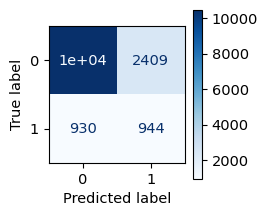

In [183]:
# threshold = 0.18
y_pred_th = np.where(y_pred_valid2.data[:, 0] >= 0.18, 1, 0)

plt.style.use('default')
plt.rcParams.update({'font.size': 10.5, 'figure.figsize' : (2.2, 2.2)})

get_classification_metrics(data_val["default"].values, y_pred_th, y_pred_valid2.data[:, 0])
get_confusion_matrix(data_val["default"].values, y_pred_th)

In [191]:
f1 = f1_score(data_val["default"].values, y_pred_th)
roc_auc = roc_auc_score(data_val["default"].values, y_pred_valid2.data[:, 0])
print(f'threshold = 0.18\nHOLDOUT f1: {round(f1, 7)} \nHOLDOUT roc_auc: {round(roc_auc, 7)}')

threshold = 0.18
HOLDOUT f1: 0.3612015 
HOLDOUT roc_auc: 0.7408019


Feature  Importance
0          score_bki  25,284.465
1           app_date   9,148.337
2      region_rating   7,440.575
3             income   6,432.255
4                sna   6,323.656
5                age   5,809.977
6       home_address   5,689.376
7    decline_app_cnt   5,429.610
8    bki_request_cnt   5,042.333
9          education   4,059.609
10        first_time   3,360.589
11      work_address   2,040.344
12               sex   1,530.888
13  foreign_passport     866.727
14         good_work     724.257

<AxesSubplot:xlabel='Feature'>

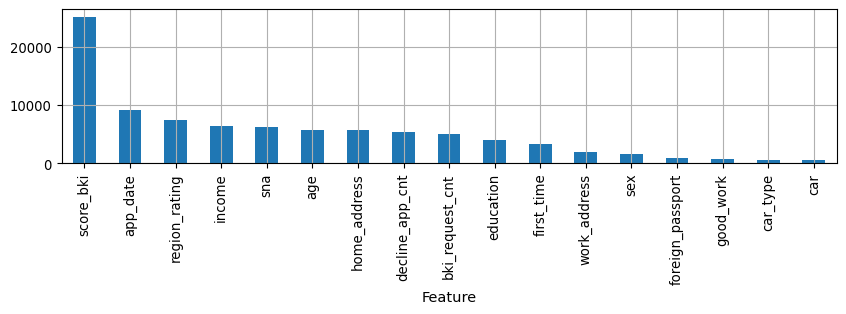

In [196]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp_2 = automl_rd_2.model.get_feature_scores('fast')
display(fast_features_imp_2.sort_values('Importance', ascending = False)[:15])
fast_features_imp_2.set_index('Feature')['Importance'].plot.bar(figsize = (10, 2), fontsize = 9.5, grid = True)

In [198]:
# LAMA report 
os.listdir('tabularAutoML_model_report_2')

['feature_importance.png',
 'lama_interactive_report.html',
 'test_distribution_of_logits_1.png',
 'test_distribution_of_logits_2.png',
 'test_pie_f1_metric_1.png',
 'test_pie_f1_metric_2.png',
 'test_preds_distribution_by_bins_1.png',
 'test_preds_distribution_by_bins_2.png',
 'test_pr_curve_1.png',
 'test_pr_curve_2.png',
 'test_roc_curve_1.png',
 'test_roc_curve_2.png',
 'valid_distribution_of_logits.png',
 'valid_pie_f1_metric.png',
 'valid_preds_distribution_by_bins.png',
 'valid_pr_curve.png',
 'valid_roc_curve.png']

In [199]:
# Сохранение модели
joblib.dump(automl_model_2, 'automl_model_2.pkl')

# Загрузка модели
# automl_model_2 = joblib.load('automl_model_2.pkl')

['automl_model_2.pkl']

### LightAutoML (пресет TabularUtilizedAutoML) с измененной конфигурацией на изначальном датасете   
- Датасет без какой-либо предобработки  
- В параметрах пресета вручную определен список алгоритмов, которые участвуют в классификации   
- В алгоритм переданы списки категориальных, числовых переменных и переменная "Дата подачи заявления" 

In [211]:
print(f'Размер тренировочного датасета "data_tr": {data_tr.shape}')      # (59039, 19)
print(f'Размер валидационного датасета "data_val": {data_val.shape}')  # (14760, 19)
data_tr.head(3)

Размер тренировочного датасета "data_tr": (59039, 19)
Размер валидационного датасета "data_val": (14760, 19)


client_id   app_date education sex  age car car_type  decline_app_cnt  \
19791      61880  11MAR2014       GRD   F   49   N        N                0   
49335      67734  16MAR2014       SCH   F   24   N        N                0   
41747      38743  14FEB2014       SCH   M   24   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
19791          1     -1.035                3             50             1   
49335          0     -1.479                0             50             1   
41747          0     -2.379                1             80             2   

       work_address  income  sna  first_time foreign_passport  default  
19791             1   60000    1           3                Y        0  
49335             2   20000    1           3                N        0  
41747             3   45000    1           2                N        0

In [214]:
# Создадим Task (бинарная классификация) и установим роли для признаков
task = Task('binary', loss = 'logloss',  metric = 'auc')

roles = {'target': TARGET_NAME,
         'drop': ['client_id'],
         'numeric' : num_cols_list,
         'category' : bin_cols_list + cat_cols_list,
          DatetimeRole(base_date = False, seasonality = ('d', 'm', 'y', 'wd')) : 'app_date'}

# Воспользуемся пресетом TabularUtilizedAutoML для создания модели
automl_utilized_1 = TabularUtilizedAutoML(task = task,             # 'binary', loss = 'logloss',  metric = 'auc'
                                          timeout = 10800,         # 3 hours
                                          cpu_limit = N_THREADS,   # 8
                                          reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_SEED, 'cv': N_FOLDS},
                                          general_params = {'use_algos' : [['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned'], 
                                                                           ['lgb', 'linear_l2']]})

y_pred_oof_ut1 = automl_utilized_1.fit_predict(data_tr, roles = roles)

[2023-08-04 09:40:27,700] (INFO): Start automl utilizator with listed constraints:
[2023-08-04 09:40:27,704] (INFO): - time: 10800.00 seconds
[2023-08-04 09:40:27,709] (INFO): - CPU: 8 cores
[2023-08-04 09:40:27,713] (INFO): - memory: 16 GB

[2023-08-04 09:40:27,715] (INFO): If one preset completes earlier, next preset configuration will be started

[2023-08-04 09:40:27,716] (INFO): ==================================================
[2023-08-04 09:40:27,718] (INFO): Start 0 automl preset configuration:
[2023-08-04 09:40:27,722] (INFO): C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[2023-08-04 09:40:27,724] (INFO3): Found reader_params in kwargs, need to combine
[2023-08-04 09:40:27,724] (INFO3): Merged variant for reader_params = {'n_jobs': 8, 'random_state': 42, 'cv': 5}
[2023-08-04 09:40:27,725] (INFO3): Found general

In [215]:
# Посмотрим краткое описание модели
print(automl_utilized_1.create_model_str_desc())

Final prediction for new objects = 
	0.36604 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
			 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

		Final prediction for new objects (level 1) = 
			 0.86242 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
			 0.13758 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 


	+ 0.33784 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_3_sel_type_1_no_inter_lgbm.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (lev

In [216]:
# Выполним предсказание на holdout-выборке и посмотрим на метрики качества
y_pred_valid_ut1 = automl_utilized_1.predict(data_val)

print(f'Размер oof prediction: {y_pred_oof_ut1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_oof_ut1.data))}')
print(f'Размер holdout prediction: {y_pred_valid_ut1.shape},  NaN-значения: {np.unique(np.isnan(y_pred_valid_ut1.data))}')

print(f'\nOOF roc_auc_score: {roc_auc_score(data_tr["default"].values, y_pred_oof_ut1.data[:, 0])}')
print(f'HOLDOUT roc_auc_score: {roc_auc_score(data_val["default"].values, y_pred_valid_ut1.data[:, 0])}')

Размер oof prediction: (59039, 1),  NaN-значения: [False]
Размер holdout prediction: (14760, 1),  NaN-значения: [False]

OOF roc_auc_score: 0.7397548848826979
HOLDOUT roc_auc_score: 0.7417191077623312


In [217]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(data_val["default"].values, y_pred_valid_ut1.data[:, 0])  

'threshold: 0.1806, f1_score: 0.3621495327102804'

Метрики качества классификации:
 - Accuracy: 0.7780
 - Precision: 0.2851
 - Recall: 0.4963
 - F1_score: 0.3621
 - Roc_auc_score: 0.7417


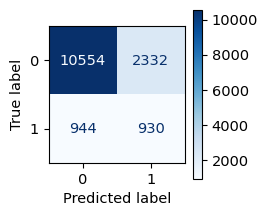

In [218]:
# threshold = 0.1806
y_pred_th = np.where(y_pred_valid_ut1.data[:, 0] >= 0.1806, 1, 0)

plt.style.use('default')
plt.rcParams.update({'font.size': 10.5, 'figure.figsize' : (2.2, 2.2)})

get_classification_metrics(data_val["default"].values, y_pred_th, y_pred_valid_ut1.data[:, 0])
get_confusion_matrix(data_val["default"].values, y_pred_th)

In [219]:
f1 = f1_score(data_val["default"].values, y_pred_th)
roc_auc = roc_auc_score(data_val["default"].values, y_pred_valid_ut1.data[:, 0])
print(f'threshold = 0.1806\nHOLDOUT f1: {round(f1, 7)} \nHOLDOUT roc_auc: {round(roc_auc, 7)}')

threshold = 0.1806
HOLDOUT f1: 0.3621495 
HOLDOUT roc_auc: 0.7417191


Feature  Importance
0          score_bki  25,288.249
1           app_date  10,031.140
2      region_rating   7,633.895
3             income   6,945.880
4                sna   6,915.106
5                age   5,949.505
6       home_address   5,390.393
7    bki_request_cnt   5,271.261
8    decline_app_cnt   4,759.024
9          education   3,851.695
10        first_time   3,056.968
11      work_address   2,143.808
12               sex   1,585.353
13  foreign_passport     944.478
14         good_work     887.829

<AxesSubplot:xlabel='Feature'>

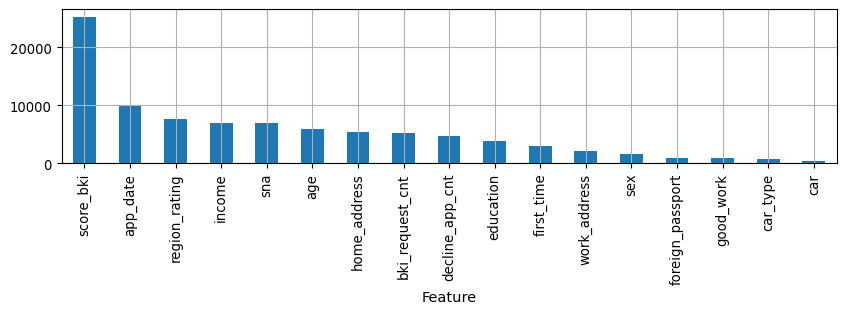

In [229]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp_ut1 = automl_utilized_1.get_feature_scores('fast')
display(fast_features_imp_ut1.sort_values('Importance', ascending = False)[:15])
fast_features_imp_ut1.set_index('Feature')['Importance'].plot.bar(figsize = (10, 2), fontsize = 9.5, grid = True)

In [230]:
# Сохранение модели
joblib.dump(automl_utilized_1, 'automl_utilized_1.pkl')

# Загрузка модели
# automl_utilized_1 = joblib.load('automl_utilized_1.pkl')

['automl_utilized_1.pkl']

# 6. Класс для быстрого проведения предобработки

In [311]:
# Класс для полной подготовки данных и разделения выборки

class CreditScoringPreprocessor():
    def __init__(self, train_df, test_df, sample_submission):
        '''Функция инициализации'''
        
        self.train_df = train_df
        self.test_df = test_df
        self.sample_submission = sample_submission
        self.train_df['sample'] = 1  # Помечаем где трейн и тест
        self.test_df['sample'] = 0 
        self.test_df['default'] = 0
        self.data = self.test_df.append(self.train_df, sort=False).reset_index(drop=True) #Объединяем трейн и тест для обработки

    
    def data_type(self):
        '''Группировка переменных на бинарные, категориальные и числовые'''
        bin_cols, cat_cols, num_cols = get_data_type(self.data, isprint=False)
        bin_cols.remove('default')
        bin_cols.remove('sample')
        num_cols.remove('client_id')
        num_cols.remove('app_date')
        return bin_cols, cat_cols, num_cols
    
    
    def preparing(self):
        '''Подготовка данных: удаление лишних данных, логарифмирование и нормализация числовых переменных, 
           трансформация бинарных и категориальных переменных'''
        bin_cols, cat_cols, num_cols = CreditScoringPreprocessor.data_type(self)
        self.data = self.data.drop(['client_id', 'app_date'], axis = 1)          # Удаление столбцов "client_id" и "app_date" 
        for col in num_cols:
            if col != 'score_bki':
                self.data[col] = np.log(self.data[col] + 1)                      # Логарифмирование числовых переменных
        self.data[num_cols] = RobustScaler().fit_transform(self.data[num_cols])  # Нормализация числовых переменных
        for col in bin_cols:
            self.data[col] = LabelEncoder().fit_transform(self.data[col])
        for col in cat_cols:   
            if self.data[col].isna().sum() > 0:
                self.data = pd.get_dummies(self.data, columns = [col], dummy_na = True)
            else:
                self.data = pd.get_dummies(self.data, columns = [col])
    
    def get_train_and_test_df(self):
        '''Разбиение на train_df и test_df'''
        train_df = self.data.query('sample == 1').drop('sample', axis = 1)
        test_df = self.data.query('sample == 0').drop(['sample', 'default'], axis = 1)  
        return train_df, test_df
    
    def get_X_y(self):
        '''Разбиение на X и y'''
        X = train_df.drop('default', axis = 1)
        y = train_df[['default']]
        return X, y
    

# 7. Kaggle Submission

- Обучение финальной модели на всем тренировочном датасете  
- Предсказание ответов на тестовом датасете
- Kaggle Submission 

#### Финальная модель - LightAutoML (пресет TabularUtilizedAutoML) с измененной конфигурацией на  непредобработанном датасете    
В параметрах пресета вручную определен список алгоритмов, которые участвуют в классификации  
В модель переданы списки категориальных, числовых переменных и переменная "Дата подачи заявления"

In [318]:
## Загрузим обучающий и тестовый датасеты
#data_train = pd.read_csv('/kaggle/input/sf-dst-scoring/main_task.csv')
#data_test= pd.read_csv('/kaggle/input/sf-dst-scoring/kaggle_task.csv')
#sample_submission = pd.read_csv('/kaggle/input/sf-dst-scoring/sample_submission.csv')


# Загрузим обучающий и тестовый датасеты 
train_credit = pd.read_csv('train_credit_scoring.csv')
test_credit = pd.read_csv('test_credit_scoring.csv')
sample_submission = pd.read_csv('sample_submission_credit_scoring.csv')


print(f"Размер обучающего датасета 'train_credit': {train_credit.shape}")        # (73799, 19)
print(f'Пропущенные значения: \n{train_credit.isna().sum()[train_credit.isna().sum() > 0]}')
display(train_credit.head(3))

print(f"\nРазмер тестового датасета 'test_credit': {test_credit.shape}")         # (36349, 18)
print(f'Пропущенные значения: \n{test_credit.isna().sum()[test_credit.isna().sum() > 0]}')
display(test_credit.head(3))

print(f"\nРазмер 'sample_submission': {sample_submission.shape}")                # (36349, 2)
display(sample_submission.head(3)) 

Размер обучающего датасета 'train_credit': (73799, 19)
Пропущенные значения: 
education    307
dtype: int64


client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      25905  01FEB2014       SCH   M   62   Y        Y                0   
1      63161  12MAR2014       SCH   F   59   N        N                0   
2      25887  01FEB2014       SCH   M   25   Y        N                2   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0     -2.009                1             50             1   
1          0     -1.532                3             50             2   
2          0     -1.408                1             80             1   

   work_address  income  sna  first_time foreign_passport  default  
0             2   18000    4           1                N        0  
1             3   19000    4           1                N        0  
2             2   30000    1           4                Y        0


Размер тестового датасета 'test_credit': (36349, 18)
Пропущенные значения: 
education    171
dtype: int64


client_id   app_date education sex  age car car_type  decline_app_cnt  \
0      74835  22MAR2014       GRD   M   29   Y        Y                0   
1      17527  24JAN2014       SCH   F   39   N        N                5   
2      75683  23MAR2014       UGR   M   50   Y        Y                0   

   good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0          0     -2.272                3             50             1   
1          0     -1.505                2             50             1   
2          0     -1.691                1             50             1   

   work_address  income  sna  first_time foreign_passport  
0             2   50000    1           4                N  
1             2    5000    4           3                N  
2             2   30000    1           3                Y


Размер 'sample_submission': (36349, 2)


client_id  default
0      74835        0
1      17527        0
2      75683        0

In [323]:
display(sample_submission.default.value_counts())
display(sample_submission.client_id.nunique()) # 36349

0    36349
Name: default, dtype: int64

36349

### Обучение финальной модели на всем тренировочном датасете

In [324]:
# Зададим параметры-константы
N_THREADS = 8 
N_FOLDS = 5
RANDOM_SEED = 42
TARGET_NAME = 'default'

# Определим задание и роли
task = Task('binary', loss = 'logloss',  metric = 'auc')
roles = {'target': TARGET_NAME,
         'drop': ['client_id'],
         'numeric' : num_cols_list,
         'category' : bin_cols_list + cat_cols_list,
          DatetimeRole(base_date = False, seasonality = ('d', 'm', 'y', 'wd')) : 'app_date'}

# Воспользуемся пресетом TabularUtilizedAutoML для создания модели
final_model = TabularUtilizedAutoML(task = task,             
                                    timeout = 14400,         
                                    cpu_limit = N_THREADS,                               
                                    reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_SEED, 'cv': N_FOLDS},
                                    general_params = {'use_algos' : [['lgb', 'lgb_tuned', 'linear_l2', 'cb', 'cb_tuned'], 
                                                                     ['lgb', 'linear_l2']]})

y_pred_train = final_model.fit_predict(train_credit, roles = roles)

[2023-08-04 17:46:48,906] (INFO): Start automl utilizator with listed constraints:
[2023-08-04 17:46:48,917] (INFO): - time: 14400.00 seconds
[2023-08-04 17:46:48,922] (INFO): - CPU: 8 cores
[2023-08-04 17:46:48,927] (INFO): - memory: 16 GB

[2023-08-04 17:46:48,930] (INFO): If one preset completes earlier, next preset configuration will be started

[2023-08-04 17:46:48,932] (INFO): ==================================================
[2023-08-04 17:46:48,933] (INFO): Start 0 automl preset configuration:
[2023-08-04 17:46:48,935] (INFO): C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[2023-08-04 17:46:48,937] (INFO3): Found reader_params in kwargs, need to combine
[2023-08-04 17:46:48,938] (INFO3): Merged variant for reader_params = {'n_jobs': 8, 'random_state': 42, 'cv': 5}
[2023-08-04 17:46:48,939] (INFO3): Found general

In [325]:
# Посмотрим краткое описание модели
print(final_model.create_model_str_desc())

Final prediction for new objects = 
	0.05028 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
			 5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
			 5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
			 5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

		Final prediction for new objects (level 1) = 
			 0.84902 * (5 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) +
			 0.15098 * (5 averaged models Lvl_1_Pipe_1_Mod_0_LightGBM) 


	+ 0.11569 * 1 averaged models with config = "C:\DsAngelina\anaconda3\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_2_select_mode_1_no_typ.yml" and different CV random_states. Their structures: 

	    Model #0.
		Models on level 0:
			 5 averaged models Lvl_0_Pipe

In [334]:
# Сохранение модели
joblib.dump(final_model, 'final_model_TabularUtilizedAutoML.pkl')

# Загрузка модели
# final_model = joblib.load('final_model_TabularUtilizedAutoML.pkl')

['final_model_TabularUtilizedAutoML.pkl']

In [327]:
print(f'Размер train prediction: {y_pred_train.shape},  NaN-значения: {np.unique(np.isnan(y_pred_train.data))}')
print(f'train roc_auc_score: {round(roc_auc_score(train_credit["default"].values, y_pred_train.data[:, 0]), 5)}')

Размер train prediction: (73799, 1),  NaN-значения: [False]
train roc_auc_score: 0.74006


In [328]:
# Найдем приемлемый порог отсечения (threshold, при котором достигается более высокий F1_score)
get_best_threshold(train_credit["default"].values, y_pred_train.data[:, 0])  

'threshold: 0.17658000000000001, f1_score: 0.3619680549786656'

Метрики качества классификации:
 - Accuracy: 0.7710
 - Precision: 0.2801
 - Recall: 0.5114
 - F1_score: 0.3620
 - Roc_auc_score: 0.7401


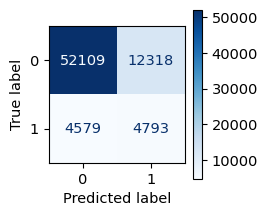

In [329]:
# threshold = 0.17658
y_pred_th = np.where(y_pred_train.data[:, 0] >= 0.17658, 1, 0)

plt.style.use('default')
plt.rcParams.update({'font.size': 10.5, 'figure.figsize' : (2.2, 2.2)})

get_classification_metrics(train_credit["default"].values, y_pred_th, y_pred_train.data[:, 0])
get_confusion_matrix(train_credit["default"].values, y_pred_th)

Feature  Importance
0        score_bki  30,911.060
1         app_date  11,157.751
2    region_rating   8,915.714
3              sna   8,352.735
4           income   7,989.692
5              age   7,270.868
6     home_address   6,464.622
7  bki_request_cnt   5,859.027
8  decline_app_cnt   4,937.483
9        education   4,260.184

<AxesSubplot:xlabel='Feature'>

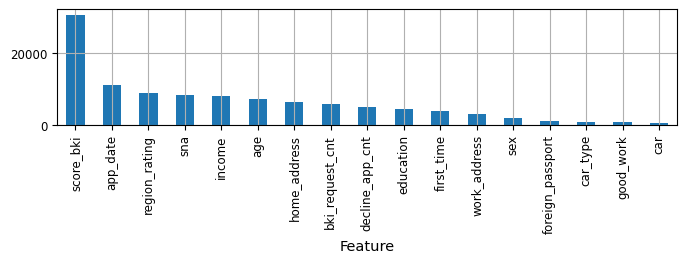

In [333]:
# Посмотрим на график важности признаков (Быстрый способ определения важности признаков)
fast_features_imp = final_model.get_feature_scores('fast')
display(fast_features_imp.sort_values('Importance', ascending = False)[:10])
fast_features_imp.set_index('Feature')['Importance'].plot.bar(figsize = (8, 1.5), fontsize = 8.5, grid = True)

### Предсказание ответов на тестовом датасете и отправка решения на kaggle 

In [336]:
# final_model = joblib.load('final_model_TabularUtilizedAutoML.pkl')

y_submission = final_model.predict(test_credit)

print(f'Размер y_submission: {y_submission.shape},  NaN-значения: {np.unique(np.isnan(y_submission.data))}')
print(y_submission)

Размер y_submission: (36349, 1),  NaN-значения: [False]
array([[0.03778039],
       [0.32692614],
       [0.07533708],
       ...,
       [0.2901042 ],
       [0.29375732],
       [0.22016571]], dtype=float32)


In [360]:
y_pred = np.where(y_submission.data[:, 0] >= 0.17658, 1, 0)
sample_submission['default'] = y_pred
sample_submission.to_csv('y_submission_credit_scoring.csv', index = False)
sample_submission.head()

client_id  default
0      74835        0
1      17527        1
2      75683        0
3      26883        0
4      28862        0

In [ ]:
# !kaggle competitions submit -c sf-scoring -f y_submission_credit_scoring.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'